# Notebook for MAGWAS

The cell below initializes things and loads the pickled files.

In [13]:
##### import csv
import pickle
run_to_case = dict()
run_to_covar = dict()
with open('metadata.csv', mode='r') as infile:
    reader = csv.DictReader(infile)
    mydict = [row for row in reader]

for patient in mydict:
    run = patient['Run']
    case = patient['Case_status']
    bases = patient['Bases']
    age = patient['Age_at_collection']
    
    sex = patient['sex']
    sex = 0 if sex == 'male' else 1
    
    alc = patient['Do_you_drink_alcohol']
    alc = 0 if alc == 'N' else 1
    
    lax = patient['Laxatives']
    lax = 0 if lax == 'N' else 1
    
    prob = patient['Probiotic']
    prob = 0 if prob == 'N' else 1
    
    pain = patient['Pain_med']
    pain = 0 if pain == 'N' else 1    
    
    dep = patient['Depression_anxiety_mood_med']
    dep = 0 if dep == 'N' else 1    
    
    anti = patient['Antihistamines']
    anti = 0 if anti == 'N' else 1    
    
    sleep = patient['sleep_aid']
    sleep = 0 if sleep == 'N' else 1
    
    run_to_case[run] = case
    #print(age,sex,alc,lax,prob,pain,dep,anti,sleep)
    run_to_covar[run] = [float(bases), float(age), sex, alc, lax, prob, pain, dep, anti, sleep]
    
results_file = "contain_results_c100_geq95.txt"
#results_file = "./no-adj_uhgg_c100_on_all_results.txt"
#prefix = ""
#prefix = "98-fixed-covs-"
prefix = "95-fixed-covs-"


# LOAD EVERYTHING

In [3]:
with open(prefix + 'mag_points.pkl', 'rb') as file:
    mag_points = pickle.load(file)
    
with open(prefix + 'mag_abundances.pkl', 'rb') as file:
    mag_abundances = pickle.load(file)

with open(prefix + 'ani_run_vec.pkl', 'rb') as file:
    runs_to_ani_vec = pickle.load(file)

# Collect data. Takes about 30 minutes, CAREFUL!

In [14]:
from dataclasses import dataclass

@dataclass
class nn_res:
    ani: float
    run: str
    mag: str
    eff_cov: float

all_results = []
all_runs = set()
all_mags = set()

f = open(results_file,'r')
next(f)
for line in f:
    if 'ANI' in line:
        continue
    spl = line.split()
    ani = float(spl[2])
    eff_cov = float(spl[5])
    run = spl[0].split('_')[0].split('/')[-1]
    mag = spl[1].split('/')[-1]
    all_results.append(nn_res(ani,run,mag,eff_cov))
    all_runs.add(run)
    all_mags.add(mag)

#PCA for all runs
from collections import defaultdict
import copy
subsampled_mags = sorted(list(all_mags))[0::100]
subsampled_mag_set = set(subsampled_mags)
zero_dict = dict()
for mag in subsampled_mags:
    zero_dict[mag] = 0
runs_to_ani_vec = defaultdict(dict)
for run in all_runs:
    runs_to_ani_vec[run] = copy.deepcopy(zero_dict)

mag_points = dict()
mag_abundances = dict()
nfive = dict()
zero = dict()

for run in all_runs:
    if "98" in prefix:
        nfive[run] = 98
    else:
        nfive[run] = 95
    zero[run] = 0
    
for mag in all_mags:
    mag_points[mag] = copy.deepcopy(nfive)
    mag_abundances[mag] = copy.deepcopy(zero)

for res in all_results:
    if "98" in prefix:
        if res.ani > 98:
            mag_points[res.mag][res.run] = res.ani
            mag_abundances[res.mag][res.run] = res.eff_cov / run_to_covar[res.run][0]
    else:
        mag_points[res.mag][res.run] = res.ani
        mag_abundances[res.mag][res.run] = res.eff_cov / run_to_covar[res.run][0]
    if res.mag in subsampled_mag_set:
        runs_to_ani_vec[res.run][res.mag] = res.ani

import pickle 

with open(prefix + 'mag_points.pkl', 'wb') as file:
    pickle.dump(mag_points, file)

with open(prefix + 'mag_abundances.pkl', 'wb') as file:
    pickle.dump(mag_abundances, file)
    
with open(prefix + 'ani_run_vec.pkl', 'wb') as file:
    pickle.dump(runs_to_ani_vec, file)
    

# Run PCA and visualize data. Pretty fast

[795.7263515181892, -409.7418036052713, -106.61816424132132, -503.028918973133, 33.31973716464839]


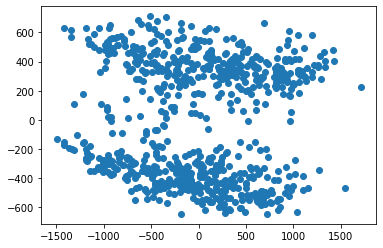


Principal Component 1: 12.29% of the variance
Principal Component 2: 4.74% of the variance
Principal Component 3: 3.46% of the variance
Principal Component 4: 2.72% of the variance
Principal Component 5: 2.28% of the variance


In [15]:
# PCA

import pickle 


from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt

# Here is your dictionary
d = runs_to_ani_vec
from sklearn.preprocessing import StandardScaler

# Convert your dictionary into a pandas DataFrame
df_pre = pd.DataFrame(d).T
df_pre = df_pre.fillna(0)

scaler = StandardScaler()

# Fit and transform the scaler to the data

#df = scaler.fit_transform(df_pre)
df = df_pre
# Normalizing the data
#df = (df - df.mean()) / df.std()
# Perform PCA
pca = PCA(n_components=5)  # we're reducing to 2 features as your dictionary only have 2 features
principalComponents = pca.fit_transform(df)

# Create a DataFrame with the principal components for each data vector
principalDf = pd.DataFrame(data=principalComponents,
                           #columns=['Principal Component 1', 'Principal Component 2', 'Principal Component 3'],
                           index=df_pre.index)

# If you want to retrieve the components for a specific vector:
sample1_components = principalDf.loc['SRR19064316']
print(list(sample1_components))
plt.scatter((principalDf.values)[:,0],(principalDf.values)[:,1])
plt.show()
print()
for i, variance in enumerate(pca.explained_variance_ratio_):
    print(f'Principal Component {i+1}: {variance * 100:.2f}% of the variance')
    



# Cell for plotting specific MAG effects

114


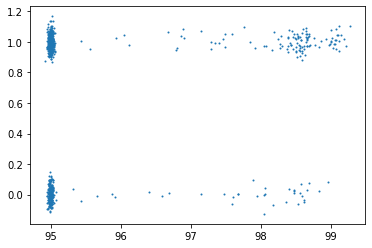

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  724
Model:                          Logit   Df Residuals:                      713
Method:                           MLE   Df Model:                           10
Date:                Thu, 15 Jun 2023   Pseudo R-squ.:                  0.1969
Time:                        01:51:03   Log-Likelihood:                -365.27
converged:                       True   LL-Null:                       -454.84
Covariance Type:            nonrobust   LLR p-value:                 3.521e-33
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -18.5338      7.323     -2.531      0.011     -32.887      -4.181
x1             0.2002      0.077      2.615      0.009       0.050       0.350
x2             0.0131      0.011      1.225      0.2

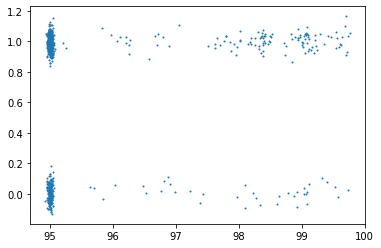

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  724
Model:                          Logit   Df Residuals:                      713
Method:                           MLE   Df Model:                           10
Date:                Thu, 15 Jun 2023   Pseudo R-squ.:                  0.1946
Time:                        01:51:03   Log-Likelihood:                -366.32
converged:                       True   LL-Null:                       -454.84
Covariance Type:            nonrobust   LLR p-value:                 9.596e-33
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -14.3819      6.729     -2.137      0.033     -27.571      -1.193
x1             0.1564      0.070      2.228      0.026       0.019       0.294
x2             0.0135      0.011      1.257      0.2

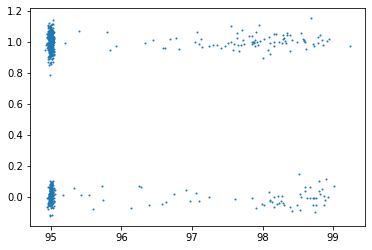

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  724
Model:                          Logit   Df Residuals:                      713
Method:                           MLE   Df Model:                           10
Date:                Thu, 15 Jun 2023   Pseudo R-squ.:                  0.1946
Time:                        01:51:03   Log-Likelihood:                -366.34
converged:                       True   LL-Null:                       -454.84
Covariance Type:            nonrobust   LLR p-value:                 9.780e-33
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.4598      7.008      2.349      0.019       2.725      30.195
x1            -0.1666      0.073     -2.290      0.022      -0.309      -0.024
x2             0.0143      0.011      1.322      0.1

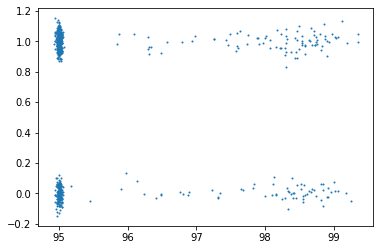

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  724
Model:                          Logit   Df Residuals:                      713
Method:                           MLE   Df Model:                           10
Date:                Thu, 15 Jun 2023   Pseudo R-squ.:                  0.1935
Time:                        01:51:03   Log-Likelihood:                -366.81
converged:                       True   LL-Null:                       -454.84
Covariance Type:            nonrobust   LLR p-value:                 1.535e-32
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.8150      6.466      2.137      0.033       1.143      26.488
x1            -0.1388      0.067     -2.072      0.038      -0.270      -0.008
x2             0.0142      0.011      1.320      0.1

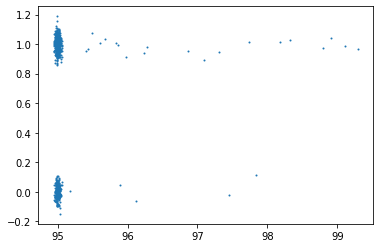

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  724
Model:                          Logit   Df Residuals:                      713
Method:                           MLE   Df Model:                           10
Date:                Thu, 15 Jun 2023   Pseudo R-squ.:                  0.1902
Time:                        01:51:04   Log-Likelihood:                -368.35
converged:                       True   LL-Null:                       -454.84
Covariance Type:            nonrobust   LLR p-value:                 6.662e-32
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -26.5451     27.175     -0.977      0.329     -79.806      26.716
x1             0.2845      0.286      0.996      0.319      -0.275       0.844
x2             0.0151      0.011      1.403      0.1

In [16]:
## import pickle 
import numpy as np
import statsmodels.api as sm

import matplotlib
#matplotlib.use('pdf')
import matplotlib.pyplot as plt
#noise = np.array(range(len(y))) * 0.001
#igh
mag1 = 'MGYG000260137.fa'
#low
mag2 = 'MGYG000076696.fa'

mag3 = 'MGYG000087685.fa'

mag4 = 'MGYG000207059.fa'

mag5 = 'MGYG000049420.fa'
mags = [mag1, mag2, mag3, mag4, mag5]
for mag in mags:
    # import numpy as np

    dicts = mag_points[mag]
    l = [[ run_to_case[a],b, mag_abundances[mag][a] * 10000000] + run_to_covar[a][1:] for a,b in dicts.items()]
    X = np.array([[p[1]] + p[3:] for p in l])
    #X = np.array([[p[1]] for p in l])
    y = np.array([0 if p[0] =='Control' else 1 for p in l])
    noise = np.random.normal(0,.05,len(y))

    #print(len(X))
    #print(sorted(zip(X,y)))
    y_n = y + noise
    ind = 0
    X_n = X[:,ind] + np.random.normal(0,(np.max(X[:,ind]) - np.min(X[:,ind]))/200,len(X[:,ind]))
    print(len([x for x in X[:,ind] if x > 98]))
    plt.plot(X_n, y_n,'o', ms = 1)
    #print(X,y)
    plt.show()

    X = sm.add_constant(X)

    # Perform logistic regression
    model = sm.Logit(y, X)
    result = model.fit(method='newton', disp = 0, maxiters=100)
    print(result.summary())
    print(result.pvalues)

# Perform regression and get p-values

In [17]:
import numpy as np
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')
# Initialize a dictionary to store results
results = {}
count = 0
for mag,dicts in sorted(list(mag_points.items())):
    #if count == 1000:
    #    break
    #mag = 'MGYG000000001.fa'
    #dicts = mag_points[mag]
    #print(result.summary())
    
    l = [[ run_to_case[a],b, mag_abundances[mag][a] * 10000000] + run_to_covar[a][1:] for a,b in dicts.items()]
    X = np.array([[p[1]] + p[3:] for p in l])
    #l = [[ run_to_case[a],b] + list(principalDf.loc[a]) for a,b in dicts.items()]
    #if '98' in prefix:
    #    X = np.array([p[1:4] for p in l])
    #else:
    #    X = np.array([p[1:6] for p in l])
    ani = np.array([p[1] for p in l])
    y = np.array([0 if p[0]=='Control' else 1 for p in l])
    is_same = np.all(ani == ani[0])
    if is_same:
        print('is same:' + mag)
        continue
    # Add constant to the predictor (required for statsmodels)
    X = sm.add_constant(X)

    # Perform logistic regression
    model = sm.Logit(y, X)
    
    try:
        result = model.fit(method='newton', disp = 0, maxiters=200)
        count += 1
        if not result.converged:
            continue
        # Store the result summary into the dictionary
        if len(result.pvalues) >= 2:
            results[mag] = [result.pvalues[1], result.pvalues[2], result.params[1], result.params[2]]  # p-value for x coefficient
            if count % 10 == 0:
                #print(mag,result.pvalues[1], result.pvalues[2], result.params[1], result.params[2])
                print(mag,result.pvalues[1], result.pvalues[2])
    except:
        print('singular')

import pickle 

with open(prefix + 'p_vals_mags.pkl', 'wb') as file:
    pickle.dump(results, file)

MGYG000000017.fa 0.7263069304469957 0.1681462443640046
singular
MGYG000000031.fa 0.16677490269350126 0.19415657348183968
MGYG000000041.fa 0.9698616302720297 0.17484913297245908
MGYG000000055.fa 0.7116118049463036 0.1676854401688751
MGYG000000067.fa 0.14283230347036407 0.19179294032793226
MGYG000000077.fa 0.9471465270797387 0.1698586655376374
MGYG000000092.fa 0.37250325404241913 0.16246793372266544
MGYG000000104.fa 0.7629089450276176 0.17622179112861813
MGYG000000129.fa 0.7858139973313298 0.1722626547981828
MGYG000000139.fa 0.9462620457908439 0.17040524902852572
MGYG000000151.fa 0.30820634365656074 0.18369720083328456
singular
MGYG000000174.fa 0.5910947601092895 0.1672401029692998
MGYG000000185.fa 0.130527141712083 0.21188367242672068
MGYG000000196.fa 0.13111698788473541 0.16060955081192296
MGYG000000206.fa 0.10391633565361177 0.14914216765736255
MGYG000000216.fa 0.5043038956925164 0.1688366254149568
MGYG000000229.fa 0.887774022870953 0.17258636666870497
MGYG000000240.fa 0.6368165701376

MGYG000002964.fa 0.06472046340806015 0.16499953484494434
MGYG000002991.fa 0.5114860850842841 0.173610103516892
MGYG000003002.fa 0.8726138593338246 0.16897650621987303
MGYG000003017.fa 0.17584545559687625 0.194365060761007
MGYG000003029.fa 0.8970623562078736 0.17113597313390738
MGYG000003040.fa 0.984773170882281 0.17023933673728242
MGYG000003050.fa 0.55639195210991 0.16802905282143576
MGYG000003063.fa 0.11390712195267688 0.1980577309420798
MGYG000003088.fa 0.66483212886201 0.17784574368526118
MGYG000003103.fa 0.7707933031146564 0.16892443150631453
MGYG000003122.fa 0.9252488399030844 0.17053233948691893
MGYG000003146.fa 0.5378673487882386 0.1790070713226245
MGYG000003163.fa 0.6276675818839315 0.15379026375690144
MGYG000003190.fa 0.5336478453376393 0.1644033683335202
MGYG000003209.fa 0.784184846042428 0.17090991579929016
MGYG000003220.fa 0.40841729324057796 0.1409590620011924
MGYG000003232.fa 0.00405358404927312 0.16935430179815292
MGYG000003246.fa 0.9853406077900158 0.182517771398779
sin

MGYG000005904.fa 0.600287176934956 0.16423252214876893
MGYG000005917.fa 0.00015539365439054247 0.3521423299048776
MGYG000005932.fa 0.8381979779070263 0.1718890768752397
MGYG000005947.fa 0.14028808014162603 0.1705241030602085
MGYG000005960.fa 0.630916216147881 0.17348310769631448
MGYG000005973.fa 0.3827572956715567 0.1519951557359681
MGYG000005988.fa 0.9976946648519736 0.24490291642351092
singular
MGYG000006015.fa 0.6456431211613634 0.19041913214761408
MGYG000006027.fa 0.9724281846883327 0.17045016323064588
MGYG000006038.fa 0.9069916214724912 0.17060936542667893
MGYG000006068.fa 0.673476789373658 0.19203263831036677
MGYG000006098.fa 0.6603478611833156 0.17304535334854088
MGYG000006110.fa 0.4864189770243198 0.1669260908693203
MGYG000006123.fa 0.3279277048703648 0.18294795712369838
MGYG000006134.fa 0.09607742155816948 0.20204822949294232
MGYG000006146.fa 0.306838936858315 0.19495217841792056
MGYG000006161.fa 0.1432396723616955 0.13229508550402708
MGYG000006188.fa 0.20735769239895074 0.188

MGYG000007857.fa 0.7688878846056597 0.16508611372439963
MGYG000007867.fa 0.2038988513028448 0.20957185280878965
MGYG000007879.fa 0.22171417645262637 0.1449594874301101
MGYG000007889.fa 0.8297769479209536 0.18206001899238033
MGYG000007899.fa 0.04991878752341746 0.2548264671431647
MGYG000007909.fa 0.8346589498622835 0.17181367189315344
MGYG000007919.fa 0.03326232534938676 0.2678632967746791
MGYG000007929.fa 0.8647848942375647 0.16749419304591873
MGYG000007939.fa 0.34973619644183895 0.14728307499064114
MGYG000007949.fa 0.2711253285043087 0.2149348598837354
MGYG000007959.fa 0.176781473784287 0.16094020882102666
MGYG000007969.fa 0.4521402248928458 0.18633062392016586
MGYG000007980.fa 0.5955116656149368 0.17376521205570672
MGYG000007991.fa 0.776136567205841 0.17027574469739537
MGYG000008001.fa 0.2731629203803979 0.18569470979446134
MGYG000008011.fa 0.010337475031748986 0.14984207154680035
MGYG000008021.fa 0.1026739596343473 0.14580060969782976
MGYG000008032.fa 0.004154748581080715 0.25310653

MGYG000009463.fa 0.2541293203055859 0.1630735068491569
MGYG000009473.fa 0.3555210876394378 0.18911385221546473
MGYG000009483.fa 0.31732813754211175 0.18319616232088098
MGYG000009494.fa 0.29052135631397535 0.17293999356036638
MGYG000009505.fa 0.010344165358638753 0.2482206809176547
MGYG000009516.fa 0.10209243080148797 0.14893358320508443
MGYG000009527.fa 0.1776456582732625 0.16875309127806737
MGYG000009549.fa 0.07299880700185803 0.22934710310444484
MGYG000009560.fa 0.4694661227852709 0.20004490666251795
MGYG000009571.fa 0.9134061126719932 0.17395530171013063
MGYG000009581.fa 0.7858701545578838 0.16562583718403778
MGYG000009591.fa 0.3489820721017307 0.14311864437754784
MGYG000009601.fa 0.9165331404736727 0.16944027583041743
MGYG000009612.fa 0.5590344421016591 0.15589566013266581
MGYG000009623.fa 0.017952379982087964 0.2766176770032869
MGYG000009634.fa 0.6852564157951393 0.1687403591220088
MGYG000009644.fa 0.5838660488617217 0.18166892339900131
MGYG000009654.fa 0.44299742469754766 0.15416

MGYG000011083.fa 0.0004924979019859271 0.3025518973627349
MGYG000011093.fa 0.5420861877804136 0.17726297949024095
MGYG000011105.fa 0.014767162594930798 0.3130978843200686
MGYG000011117.fa 0.6110308857386713 0.1760565627737869
MGYG000011128.fa 0.6959353444725167 0.1665379733768274
MGYG000011139.fa 0.06683531899179057 0.1643031653822289
MGYG000011149.fa 0.0813118312291558 0.16317270330209177
MGYG000011159.fa 0.5312066102989077 0.19572323833315142
MGYG000011170.fa 0.292966223573486 0.15912254948807847
MGYG000011182.fa 0.20191434730531066 0.17567269399228003
MGYG000011192.fa 0.9255629292108833 0.17105204389692563
MGYG000011202.fa 0.6969404739982578 0.1767002852655546
MGYG000011212.fa 0.8161764197367396 0.17244920403263253
MGYG000011224.fa 0.6620561190350371 0.1599461251529024
MGYG000011246.fa 0.11701752413402869 0.19518086356670883
MGYG000011256.fa 0.026751775002928635 0.12186192306325405
MGYG000011266.fa 0.05819178607339315 0.1365699320002694
MGYG000011276.fa 0.0009833620865739557 0.26170

MGYG000012694.fa 0.33269531609778435 0.15116012876704416
MGYG000012705.fa 0.3888877043553981 0.16157804755163696
MGYG000012718.fa 0.5165449652510801 0.19016318748169758
MGYG000012729.fa 0.37308299576783 0.14999079214408112
MGYG000012739.fa 0.889799406203954 0.1760425180212294
MGYG000012749.fa 0.09856744006846939 0.2135730548628726
MGYG000012759.fa 0.7883093546328911 0.17141860380370777
MGYG000012772.fa 0.4788979191578866 0.15493396961746436
MGYG000012782.fa 0.3914353219028712 0.17320003255097294
MGYG000012792.fa 0.8303350013959101 0.170881206045168
MGYG000012802.fa 0.5844906001033339 0.1557973544744891
MGYG000012812.fa 0.36408057187216514 0.1451814819282893
MGYG000012822.fa 0.9041375566880296 0.17318737650555038
MGYG000012832.fa 0.3729484154781929 0.14747007862462044
MGYG000012842.fa 0.8864213674985693 0.17154004721922822
MGYG000012853.fa 0.3963790259827834 0.16171054159302323
MGYG000012864.fa 0.10831050923665826 0.2132299741201572
MGYG000012874.fa 0.008061308113198891 0.17015147271263

MGYG000014353.fa 0.037353425232639875 0.13422041477369054
MGYG000014363.fa 0.9845271512508452 0.17020936503447714
MGYG000014373.fa 0.017482346385040228 0.1740140672426258
MGYG000014383.fa 0.08680996005394087 0.1871223038952342
MGYG000014393.fa 0.0009928779279327496 0.37584933934451714
MGYG000014404.fa 0.10167441295857448 0.1316659325864599
MGYG000014415.fa 0.35322607722790766 0.16356690438839883
MGYG000014425.fa 0.0842681655501118 0.26225828502444115
MGYG000014435.fa 0.049669362407665583 0.16818206867292151
MGYG000014445.fa 0.49956260847140577 0.18215573624063164
MGYG000014455.fa 0.24529837058489246 0.1912183303816678
MGYG000014467.fa 0.09541705805883507 0.1298745473476139
MGYG000014478.fa 0.00013248371945821693 0.3828257341941539
MGYG000014509.fa 0.24735736107007145 0.15815756387393398
MGYG000014520.fa 0.03857015332597688 0.24825248222376495
MGYG000014531.fa 0.015080032093154646 0.24646031185886563
MGYG000014542.fa 0.00032090881976425047 0.25648422697452355
MGYG000014563.fa 0.40858848

MGYG000015996.fa 0.033694916157881775 0.24007850064337144
MGYG000016006.fa 0.276007532309803 0.1857270198562726
MGYG000016016.fa 0.011042859396353777 0.24579415268537452
MGYG000016026.fa 0.7431377404711672 0.16429822085156442
MGYG000016036.fa 0.22742901723556286 0.16015975547735717
MGYG000016050.fa 0.12180781900243653 0.1793081087540246
MGYG000016062.fa 0.02380319372094821 0.16363478885386418
MGYG000016074.fa 0.5500568671350323 0.17911918148567985
MGYG000016085.fa 0.26113000819661725 0.18862921665166787
MGYG000016095.fa 0.8686106958672606 0.1698765595674291
MGYG000016106.fa 0.039893756810101495 0.1323694626610795
MGYG000016117.fa 0.36644550478319793 0.1609750227030171
MGYG000016127.fa 0.17129880754391658 0.1811220009807325
MGYG000016137.fa 0.2760604114771391 0.1936120925299305
MGYG000016147.fa 0.727304763275872 0.1708074688521224
MGYG000016157.fa 0.40539689511693455 0.1929389970172002
MGYG000016167.fa 0.28033885143654247 0.1866383841812661
MGYG000016178.fa 0.17167357734159183 0.1686145

MGYG000017599.fa 0.3474595570874466 0.18337899215144937
MGYG000017609.fa 0.11890525734393392 0.20375734377116517
MGYG000017620.fa 0.05875342434472284 0.15416438835589086
MGYG000017630.fa 0.1033738195418079 0.20359205820799098
MGYG000017641.fa 0.4505307595246758 0.1491760611761057
MGYG000017652.fa 0.45710991575102233 0.1774703065640728
MGYG000017663.fa 0.020802634661979957 0.2559333475443737
MGYG000017674.fa 0.35152660473833475 0.16563232163080932
MGYG000017684.fa 0.07562905452599615 0.1973480318880596
MGYG000017695.fa 0.7345483551455124 0.17357550299228408
MGYG000017705.fa 0.019079894388248714 0.2048562492293432
MGYG000017715.fa 4.1276174836576344e-05 0.332701471112857
MGYG000017726.fa 0.8437666603484063 0.17101950396093735
MGYG000017737.fa 0.43879939020494796 0.18424055003476736
MGYG000017748.fa 0.5358456618135943 0.17712795877278942
MGYG000017759.fa 0.28419029626193104 0.1898452194826692
MGYG000017769.fa 0.30443149975483463 0.18945444851386328
MGYG000017780.fa 0.14845760083972487 0.1

MGYG000019179.fa 0.580309344555745 0.16376310605688937
MGYG000019189.fa 0.7456799093555289 0.1929970421337327
MGYG000019199.fa 0.7198477323051852 0.16145078002553015
MGYG000019210.fa 0.28775866122509375 0.143903309379082
MGYG000019221.fa 0.8729958122794219 0.16741684386812405
MGYG000019232.fa 0.0581301699276669 0.1974997184406001
MGYG000019242.fa 0.5306683969960575 0.1974081631178951
singular
MGYG000019254.fa 0.07009735343153725 0.113939203498853
MGYG000019264.fa 0.4646627476994236 0.15603416668001982
MGYG000019274.fa 0.0004775912690494446 0.3813740894062827
MGYG000019285.fa 0.4019960103103446 0.1492110881686668
MGYG000019295.fa 0.06285418460197398 0.11694918099364712
MGYG000019306.fa 0.11001137210720184 0.147216498992176
MGYG000019317.fa 0.8606544189622021 0.18281474915482998
MGYG000019328.fa 0.8088761375830334 0.17360742205036628
MGYG000019339.fa 0.02701092851592643 0.14719108590671567
MGYG000019349.fa 0.0783666310119783 0.21383185523033366
MGYG000019360.fa 0.9856810040158841 0.17068

MGYG000020768.fa 0.9164863569214726 0.17653104530128094
MGYG000020778.fa 0.6237462370162301 0.16651885058593152
MGYG000020791.fa 0.5437886086274704 0.19486873204571442
singular
MGYG000020804.fa 0.0039610527528438876 0.17224161978402697
MGYG000020815.fa 0.35431447494377744 0.1508452437011828
MGYG000020828.fa 0.2709938209152075 0.20013608307526132
MGYG000020839.fa 0.3750277346218195 0.16149104932920766
MGYG000020849.fa 0.41060891888934103 0.1790652718176048
MGYG000020860.fa 0.46071764611877775 0.16168747561932895
MGYG000020870.fa 0.07530580555688776 0.13606791838384277
MGYG000020880.fa 0.09349760476573853 0.23340435960985173
MGYG000020891.fa 0.3424106886911056 0.1314565475370474
MGYG000020901.fa 0.013533067586291046 0.25403056146075587
MGYG000020911.fa 0.31495666625189167 0.1877751657136535
MGYG000020921.fa 0.3581933960259923 0.18719347817191478
MGYG000020931.fa 0.6902174750045191 0.17048602251773437
MGYG000020953.fa 0.9743607210035261 0.1701486631814606
MGYG000020964.fa 0.18112716726386

MGYG000022353.fa 0.6660683772620003 0.1601674107711777
MGYG000022363.fa 0.09959361605661293 0.21379872183378712
MGYG000022374.fa 0.6523363754888949 0.1744414424730566
MGYG000022385.fa 0.39612036199028233 0.15100816128879768
MGYG000022395.fa 0.33495171518364486 0.1548936029722269
MGYG000022405.fa 0.9939545685143224 0.1703573492311975
MGYG000022416.fa 0.0004092228341946374 0.41107933648640915
MGYG000022427.fa 0.11894225022972235 0.17331458750258888
MGYG000022437.fa 0.10017267617168508 0.20150322867025494
MGYG000022448.fa 0.7689448856379203 0.17002458318792346
MGYG000022458.fa 0.20430254274066262 0.19021536601882894
MGYG000022468.fa 0.3456378247577242 0.16599112177207564
MGYG000022478.fa 0.32317897014173425 0.15878774236710325
MGYG000022488.fa 0.8310680647947857 0.16618406526126406
MGYG000022500.fa 0.6261332142074338 0.18792037872966516
MGYG000022510.fa 0.5166965101325731 0.1926838918208934
MGYG000022523.fa 0.8161704625388518 0.17284947598885925
MGYG000022533.fa 0.7315442614927864 0.17733

MGYG000023961.fa 0.23939763370023504 0.19941096878218467
MGYG000023972.fa 0.16617439345460172 0.20492541198917114
MGYG000023984.fa 0.6340202519766962 0.17370982095760068
MGYG000023994.fa 0.1378673659161383 0.18662094659322215
MGYG000024006.fa 0.48860365400355843 0.1726939622348913
MGYG000024016.fa 0.711054945885381 0.17903543374760122
MGYG000024027.fa 0.8842896496721022 0.168437437796213
MGYG000024038.fa 0.000795786692133859 0.37306198388980094
MGYG000024049.fa 0.16508688035193597 0.18120852964813183
MGYG000024061.fa 0.11214836810761719 0.2118934068498628
MGYG000024072.fa 0.7918514796896621 0.17046002380545044
MGYG000024082.fa 0.5632988117437676 0.14649228776698653
MGYG000024092.fa 0.2216797034045298 0.18146170970611142
MGYG000024103.fa 0.7097446217471857 0.18043870110614801
MGYG000024113.fa 0.016665476963005636 0.15256720350057018
MGYG000024126.fa 0.7060580602012954 0.16140529035840334
MGYG000024136.fa 0.8079894097133112 0.1763865860244732
MGYG000024147.fa 0.11578403844517317 0.128882

MGYG000025563.fa 0.1572225731170714 0.20534088174368603
MGYG000025573.fa 0.03508593508712953 0.24494372728970537
MGYG000025583.fa 0.09707142688618355 0.21508694876181444
MGYG000025594.fa 0.8461644125401898 0.17147831508396372
MGYG000025604.fa 0.008229987395531253 0.2622857307238029
MGYG000025614.fa 0.062279087627318826 0.16890275338306482
MGYG000025624.fa 0.1723359604178376 0.16240128802021125
MGYG000025634.fa 0.9630502495448504 0.17051018919966954
MGYG000025644.fa 0.021006554128394736 0.23374877961457208
MGYG000025655.fa 0.10261564170976051 0.21390317384870816
MGYG000025669.fa 0.6128687790541335 0.19108492554597623
MGYG000025680.fa 0.04589858337143417 0.19705185994258312
MGYG000025691.fa 0.05631477297435485 0.16598720276941348
MGYG000025701.fa 0.010498667111162771 0.1046808585556954
MGYG000025711.fa 0.473838939644723 0.16226656658208283
MGYG000025722.fa 0.8825780730151755 0.17073527396027632
MGYG000025732.fa 0.08023908060207982 0.15740778968745373
MGYG000025742.fa 0.02925839828661035 

MGYG000027189.fa 0.015215174384901347 0.2639274015994172
MGYG000027199.fa 0.5379999676770738 0.1593306051754303
MGYG000027209.fa 0.5903727688030943 0.1644150111655983
MGYG000027219.fa 0.20305634616085289 0.24600494873384882
MGYG000027241.fa 0.5202465403527434 0.1918789679425088
MGYG000027251.fa 0.6175388232337357 0.1652992239215184
MGYG000027261.fa 0.0009673801268009488 0.3876976269518265
MGYG000027271.fa 0.09797370184835953 0.19042874396336806
MGYG000027281.fa 0.9295789600913128 0.1700910284495012
MGYG000027293.fa 0.7824509689542565 0.1712794693250279
MGYG000027304.fa 0.11180228933787408 0.1331340090858767
MGYG000027314.fa 0.8096211427111516 0.170809226583851
MGYG000027324.fa 0.10344393913480336 0.1431868232901198
MGYG000027335.fa 0.4549714537980549 0.1630572433820261
MGYG000027345.fa 0.010221906713565706 0.15369044967372297
MGYG000027356.fa 0.39627244028482134 0.16446068507475264
MGYG000027367.fa 0.020537754486918396 0.16774896882606494
MGYG000027377.fa 0.25725925392528604 0.16676928

MGYG000028804.fa 0.24885184394696291 0.18969795296579328
MGYG000028815.fa 0.08987543642194781 0.16917640039305892
MGYG000028826.fa 0.7554367714485235 0.17081819890202032
MGYG000028839.fa 0.10603346507784003 0.2314006995585557
MGYG000028849.fa 0.9924076983132257 0.17029280033205463
MGYG000028861.fa 0.046578375430543564 0.12870517858514538
MGYG000028871.fa 0.010563915986010912 0.2548583061716744
MGYG000028882.fa 6.493721637128976e-05 0.4001427700449435
MGYG000028892.fa 0.15220598348606834 0.13840892698276458
MGYG000028902.fa 0.13929161819927877 0.2260563996313374
MGYG000028922.fa 0.4354938186035757 0.151035221442267
MGYG000028932.fa 0.7336131604116872 0.18470014370544252
MGYG000028943.fa 0.43180319027110114 0.1864621399045765
MGYG000028953.fa 0.4100434883881924 0.18016305318979875
MGYG000028964.fa 0.2867226962986231 0.1779514159066662
MGYG000028974.fa 0.6887012367967729 0.18999912235410454
MGYG000028984.fa 0.003901255057884928 0.2589880767595446
MGYG000028994.fa 0.700729630978082 0.17178

MGYG000030407.fa 0.4214487982539663 0.1895036351923849
MGYG000030417.fa 0.7930087450139961 0.16804212835401433
MGYG000030427.fa 0.028974853957831156 0.2729108543466584
MGYG000030437.fa 0.7246368680981056 0.1719459302863835
MGYG000030449.fa 0.3446602502930176 0.15495239270920294
MGYG000030461.fa 0.1125073625392634 0.20857485713566848
MGYG000030472.fa 0.049566875691155476 0.12860371432095788
MGYG000030484.fa 0.2810318820696238 0.17787182810448154
MGYG000030496.fa 0.3890151452444771 0.16208810264901985
MGYG000030506.fa 0.004206208519141418 0.2752960201421939
MGYG000030516.fa 0.24809457512298982 0.1746310233827768
MGYG000030527.fa 0.04563790574921401 0.16387356134519737
MGYG000030549.fa 0.732582654551949 0.16982853851064095
MGYG000030559.fa 0.36532984143317704 0.18006243881470752
MGYG000030570.fa 0.008885071450412335 0.2541856881721678
MGYG000030582.fa 0.00970455748555065 0.268276290228861
MGYG000030592.fa 0.1625251945094789 0.17563740147816498
MGYG000030603.fa 0.6113924807308745 0.1804773

MGYG000032056.fa 0.23352714133216212 0.19258967512490677
MGYG000032066.fa 0.004533445136115302 0.2947170747465232
MGYG000032076.fa 0.06035958125246555 0.16655130032067145
MGYG000032088.fa 0.8829414233092688 0.17001976899025617
MGYG000032098.fa 0.3184812364597617 0.1873549103458626
MGYG000032108.fa 0.0562361436322207 0.17008650006250658
MGYG000032118.fa 0.6486023543566366 0.17635661571532124
MGYG000032128.fa 0.18905049815108588 0.1779821200365741
MGYG000032139.fa 0.3860742854764404 0.1860770220434813
MGYG000032150.fa 0.19955740405959033 0.1637293060525996
MGYG000032160.fa 0.39993095978826765 0.15250528066351982
MGYG000032171.fa 0.7013558205922958 0.1755407387739112
MGYG000032181.fa 0.9979543605084238 0.1703517197845733
MGYG000032192.fa 0.4687130931103637 0.1868205723756443
MGYG000032204.fa 0.4798745110114456 0.1625253492544091
MGYG000032214.fa 0.19516872748459446 0.17233121642122684
MGYG000032224.fa 0.1096155360340294 0.22304128501090437
MGYG000032236.fa 0.7088293706222654 0.16617350644

MGYG000033662.fa 0.24193407612330642 0.19156570556850283
MGYG000033673.fa 0.21686417674199754 0.14025156921652052
MGYG000033684.fa 0.39648153165927424 0.20580467251730594
MGYG000033696.fa 0.6116275784318457 0.1712943267309487
MGYG000033707.fa 1.323477325594384e-07 0.42390983621964573
MGYG000033717.fa 0.002314970682569887 0.3428929474281064
MGYG000033728.fa 0.6141712475979577 0.17385267655371373
MGYG000033741.fa 0.17604741423403902 0.13781040956847462
MGYG000033751.fa 0.1491702855077282 0.14882699659893833
MGYG000033761.fa 0.23173968832340497 0.20653214748636484
MGYG000033771.fa 0.2703639768526762 0.17811868286447197
MGYG000033781.fa 0.8545249080778412 0.17667415244583795
MGYG000033793.fa 0.6982864820087833 0.16662021540972272
MGYG000033803.fa 0.0003087007624697792 0.2901299361133237
MGYG000033813.fa 0.007804289621011784 0.25903443113185687
MGYG000033823.fa 0.11017379817215656 0.22323576958034774
MGYG000033833.fa 0.012104251540015381 0.23517172988393287
MGYG000033843.fa 0.46861176908461

MGYG000035290.fa nan 0.17057891207496367
MGYG000035301.fa 0.5738626526371373 0.15943610274680442
MGYG000035313.fa 0.8148384748843348 0.18831535218949047
MGYG000035323.fa 0.8138943529457078 0.16859283045750528
MGYG000035334.fa 0.04040752267795237 0.2698214193588726
MGYG000035344.fa 0.008088744667111267 0.2444861399515329
MGYG000035354.fa 0.00034246688267157747 0.32995270178554603
MGYG000035366.fa 0.05714715630342055 0.16992818210857574
MGYG000035376.fa 0.46957584767590765 0.15294476691452744
MGYG000035387.fa 0.2674450289004914 0.18483175665350704
MGYG000035398.fa 0.9575251555775147 0.17573402391556714
MGYG000035408.fa 0.5170268610933362 0.1861417938697929
MGYG000035418.fa 0.9817920345849486 0.17013337287245134
MGYG000035428.fa 0.11034001651560174 0.21126102762410648
MGYG000035440.fa 0.007588527230912778 0.3067726415327183
MGYG000035450.fa 0.24292585172381498 0.16325194128208842
MGYG000035460.fa 0.2439113138334289 0.17279539855286408
MGYG000035470.fa 0.013462009263026882 0.25744078696901

MGYG000036896.fa 0.3913371416276308 0.16356496000103404
MGYG000036906.fa 0.058748825697743486 0.16907505209863227
MGYG000036916.fa 0.19711309936661292 0.18310602128344045
MGYG000036927.fa 0.8536274377475405 0.16694396762103325
MGYG000036938.fa 0.10501540289095124 0.1299292324636041
MGYG000036948.fa 0.4533954151339672 0.1610968352946739
MGYG000036958.fa 0.43818957729279184 0.17503738934902735
MGYG000036969.fa 0.46632455407194073 0.15073404720965008
MGYG000036980.fa 0.08298074187691484 0.24230241538814346
MGYG000036990.fa 0.7304496318218296 0.1758407603859805
MGYG000037003.fa 0.19997506236987161 0.1743787538173066
MGYG000037014.fa 0.3558029133093361 0.18512480428567146
MGYG000037024.fa 0.40378130265264456 0.1564977883164748
MGYG000037034.fa 0.5294598867755733 0.16521861023869933
MGYG000037046.fa 0.8827607676397533 0.17140904849366068
MGYG000037056.fa 0.009493474876318254 0.28990509246579377
MGYG000037067.fa 0.529877944946949 0.16509834965745906
MGYG000037077.fa 0.014312042355854347 0.260

MGYG000038527.fa 0.6115564290174462 0.16640484166295577
MGYG000038537.fa 0.0724668734053814 0.21767022321543672
MGYG000038547.fa 0.08271297517299459 0.1487528460524003
MGYG000038558.fa 0.2535065190648441 0.19134863479081443
MGYG000038568.fa 0.3437436507794449 0.1725911435178581
MGYG000038579.fa 0.004392100896226328 0.1516361618419234
MGYG000038591.fa 0.6972926917625992 0.1778705161655838
MGYG000038601.fa 0.40446988772846326 0.18714580761573896
MGYG000038614.fa 0.9921051230204727 0.17021195807570977
MGYG000038624.fa 0.9659611697098889 0.17066398448640108
MGYG000038635.fa 0.9236771901224924 0.17531159619254033
MGYG000038648.fa 3.611057693987162e-05 0.3903903715505289
MGYG000038659.fa 0.41753907045438166 0.18331068761475322
MGYG000038669.fa 0.28576852743126413 0.16062107097065348
MGYG000038679.fa 0.11769054733531446 0.2661225595754739
MGYG000038690.fa 0.00045918811571312004 0.4167966884900438
MGYG000038700.fa 0.30250931499247 0.17349765272464523
MGYG000038710.fa 0.8136073637876924 0.17214

MGYG000040123.fa 0.5521424730890738 0.17239509431005784
MGYG000040133.fa 0.009776685579262192 0.26500443934492524
singular
MGYG000040144.fa 0.8162861134461635 0.16831961133903517
MGYG000040155.fa 0.15367723791974358 0.16844735540881017
MGYG000040166.fa 0.0011943104914273832 0.25885009707592577
MGYG000040177.fa 0.7313069315503372 0.17640205322367009
MGYG000040187.fa 0.05035364378383354 0.13698393985518578
MGYG000040198.fa 0.5539766581646217 0.15250800299900086
MGYG000040209.fa 0.1807016410313116 0.17030725686716275
MGYG000040220.fa 0.005397973727695377 0.3115176326142304
MGYG000040232.fa 0.3678485049705309 0.15363491513353705
MGYG000040243.fa 0.812667086336245 0.1689333627531615
MGYG000040254.fa 0.9994772582010241 0.16544257625609127
MGYG000040265.fa 0.5193315856311679 0.1802913232619554
MGYG000040287.fa 0.011251681203981994 0.21685200700092855
MGYG000040298.fa 0.6699564327742178 0.1998132890577642
MGYG000040309.fa 0.5307825398156267 0.1779404996679934
MGYG000040320.fa 0.628311657087884

MGYG000041720.fa 0.11746992713555922 0.21988810753798194
MGYG000041731.fa 0.6182515207023487 0.17330641123941581
MGYG000041741.fa 0.4603279837029497 0.1857039536693147
MGYG000041751.fa 0.33389007315008157 0.19421760115994446
MGYG000041762.fa 0.5849782759536393 0.18166472685786939
MGYG000041772.fa 0.9654855912838068 0.17224705891878955
MGYG000041782.fa 0.9682748478350504 0.17797185896608358
MGYG000041793.fa 0.5950558832812738 0.1890315094276619
MGYG000041803.fa 0.20797215286295156 0.16752979096644804
MGYG000041813.fa 0.6439894621894915 0.162201832531239
MGYG000041825.fa 2.384986629296208e-05 0.2539173354759473
MGYG000041835.fa 0.9272016776292282 0.16964558938612184
MGYG000041845.fa 0.1360666960927974 0.1480704160938912
MGYG000041856.fa 0.22417063197053733 0.17907206703450085
MGYG000041868.fa 0.12328817772527106 0.2180833041287079
MGYG000041878.fa 0.07210059992780489 0.16695584466961166
MGYG000041889.fa 0.10348947596341279 0.22997918900918235
MGYG000041899.fa 0.5021754706247537 0.1707388

MGYG000043317.fa 0.5160392198623804 0.15247251034959938
MGYG000043328.fa 0.10630436081752885 0.15950571496006216
MGYG000043349.fa 0.028406073485451763 0.132658529492477
MGYG000043359.fa 0.5703455728830102 0.19086593012034148
MGYG000043381.fa 0.36482117724116336 0.16941307040719178
MGYG000043392.fa 0.27072813815148267 0.15362334979497716
MGYG000043402.fa 0.6831940695168212 0.16957772306198693
MGYG000043426.fa 0.27676481165060973 0.1868364626395823
MGYG000043436.fa 0.1301214176818964 0.1748309824516665
MGYG000043447.fa 0.10468893713571144 0.2276336472125461
MGYG000043458.fa 0.46562226180797084 0.20115328392749598
MGYG000043472.fa 0.5466728592920311 0.17172913567135262
MGYG000043482.fa 0.05227903463606617 0.1633450467472627
MGYG000043492.fa 0.7372091268414303 0.16311696717963198
MGYG000043502.fa 0.007299542676859097 0.1487671015167149
MGYG000043515.fa 0.0004034039391638796 0.31986007424043905
MGYG000043526.fa 0.2846423835976645 0.17327209261051457
MGYG000043536.fa 0.19746333549112594 0.19

MGYG000044959.fa 0.7052868830218122 0.16641775646154355
MGYG000044970.fa 0.08863394890337375 0.13790068786934193
MGYG000044980.fa 0.06144052158251228 0.21123078224120406
MGYG000044990.fa 0.023607155539762628 0.2143041000027036
MGYG000045002.fa 0.6526739881680057 0.1935312900341467
MGYG000045024.fa 0.9083435890501268 0.17190952340655818
MGYG000045035.fa 0.04364995738506568 0.22138742447174753
MGYG000045045.fa 0.40758108379424307 0.1598893834858366
MGYG000045056.fa 0.5936175014330846 0.16596876736205501
MGYG000045066.fa 0.07515031310807367 0.18519918868141372
MGYG000045076.fa 0.2603115894283591 0.20611988863050412
MGYG000045086.fa 0.5710356246963821 0.1536311350331957
MGYG000045096.fa 0.5111999090648544 0.15405997727251908
MGYG000045106.fa 0.24190269551799803 0.1477946037743465
MGYG000045116.fa 0.0598360492201635 0.16463731417592253
MGYG000045128.fa 0.1208026811101319 0.1853248314098408
MGYG000045139.fa 0.0009907714835260953 0.3731879669335557
MGYG000045150.fa 0.011476075296343282 0.2515

MGYG000046603.fa 0.34126802740726236 0.1595498019744308
MGYG000046613.fa 0.8400572878965713 0.1672838174509087
MGYG000046625.fa 0.03188781350543985 0.2881284987318634
MGYG000046636.fa 0.0009357915761231444 0.3940924344442007
MGYG000046648.fa 0.031437096201176094 0.1318474069958707
MGYG000046658.fa 0.9661100863595037 0.1700522161517104
MGYG000046670.fa 0.70911416349757 0.16950407092821485
MGYG000046681.fa 0.3763865385587726 0.16115823540078622
MGYG000046702.fa 0.9024157933210571 0.17106532213442438
MGYG000046712.fa 0.33206433492815035 0.18541321392849508
MGYG000046722.fa 0.66483751804817 0.1735999402221149
MGYG000046733.fa 0.2858156686588369 0.15724716643303524
MGYG000046743.fa 0.1763942916970327 0.19924630796820342
MGYG000046754.fa 0.0024173053023159134 0.14401174418475338
MGYG000046764.fa 0.3734393769841179 0.18510282808184908
MGYG000046775.fa 0.08136089938992569 0.21402345202837314
MGYG000046786.fa 0.4519611737549133 0.18602933215517126
MGYG000046796.fa 0.42675688742757045 0.16565966

MGYG000048192.fa 0.3046631490637872 0.16405577191809484
MGYG000048216.fa 0.956109118681502 0.17153530180528653
MGYG000048226.fa 0.5562523624115668 0.18223931052715225
MGYG000048238.fa 0.18394782104813934 0.1625016784905643
MGYG000048248.fa 0.47180774257705327 0.14973774011545046
MGYG000048258.fa 0.19144438518746587 0.1744864434804606
MGYG000048268.fa 0.05226593104654632 0.2476784274631334
MGYG000048278.fa 0.0003294310034689565 0.3138206649748657
MGYG000048288.fa 0.7150438656557851 0.1704477758696723
MGYG000048298.fa 0.9767213903269192 0.1754148717788233
MGYG000048308.fa 0.03985517710245262 0.28710013168176673
MGYG000048318.fa 0.020950378954321346 0.16218941894894545
MGYG000048331.fa 0.5048161635321127 0.2021761527682452
MGYG000048343.fa 0.48063827042026885 0.18392529067670027
MGYG000048354.fa 0.889609787652403 0.1714886688493017
MGYG000048364.fa 0.2868567603708705 0.1766020691522402
MGYG000048376.fa 0.026718502782247296 0.16778153656842199
MGYG000048387.fa 0.1641757883764503 0.20410265

MGYG000049787.fa 0.2863817197993588 0.16850221080069483
MGYG000049797.fa 0.8134081424207704 0.16511678258618234
MGYG000049807.fa 0.566747193989013 0.19178435118553305
MGYG000049817.fa 0.18785161882339574 0.15074819371223186
MGYG000049828.fa 0.40845431358504647 0.13598111239208002
MGYG000049838.fa 0.9871000344260477 0.17023096910884683
MGYG000049848.fa 0.17052366399443786 0.20242250579553078
MGYG000049858.fa 0.4254194829060195 0.18169657272828188
MGYG000049870.fa 0.29086183460067383 0.18741862156778832
MGYG000049880.fa 0.0013076474566989051 0.3571770830784209
MGYG000049890.fa 0.2835056791106284 0.20414098071297748
MGYG000049902.fa 0.7463820930777292 0.167300244423761
MGYG000049912.fa 0.08695515442955541 0.19645467775046566
MGYG000049926.fa 0.03142403957544086 0.12333680219896558
MGYG000049936.fa 0.5063287210066391 0.16493907117170004
MGYG000049949.fa 0.14263600012257216 0.1703698211405803
MGYG000049960.fa 0.30532496969274514 0.17019201900276293
MGYG000049971.fa 0.7996310457996784 0.1690

MGYG000051387.fa 0.8219096975840385 0.1712213788975806
MGYG000051397.fa 0.20354974638207246 0.17271598939684185
MGYG000051407.fa 0.596885106253511 0.17052286583960607
MGYG000051417.fa 0.8958928082513957 0.1712898327040373
MGYG000051429.fa 0.04595209835192733 0.1988501047146335
MGYG000051440.fa 0.06429806097965969 0.16301845600936904
MGYG000051450.fa 0.4506558015607771 0.16219753499519218
MGYG000051460.fa 0.0069329675330402326 0.15497047145546372
MGYG000051470.fa 0.6200034966517736 0.16662821391376836
MGYG000051480.fa 0.6466690806013939 0.16544332390668692
MGYG000051500.fa 0.4740795597737646 0.18670091405030875
MGYG000051511.fa 0.939762811943057 0.17221032913228462
MGYG000051521.fa 0.4079925340981818 0.16542842008440062
MGYG000051531.fa 0.9573495588066926 0.17049455060878982
MGYG000051542.fa 0.5301663610249294 0.18226027122006005
MGYG000051553.fa 2.2538195504722775e-06 0.41470934358139544
MGYG000051563.fa 0.07119671578737584 0.13739990242532354
MGYG000051573.fa 0.3501754655413154 0.1837

MGYG000053029.fa 0.17815656354761966 0.19614117497628258
MGYG000053039.fa 0.18054319395947638 0.19514287898125626
MGYG000053051.fa 0.12584454310434529 0.19883036096800588
MGYG000053063.fa 0.3156888118746414 0.2050623127737552
MGYG000053074.fa 0.76726846727389 0.17413787624834376
MGYG000053084.fa 0.06341141223713422 0.2430180280029719
MGYG000053094.fa 0.7119987789060626 0.16150699479564734
MGYG000053105.fa 0.4298939880198772 0.18488133709675947
MGYG000053115.fa 0.8472033337963508 0.16826439061628318
MGYG000053125.fa 0.4286036707923927 0.18411750231276214
MGYG000053135.fa 0.7165134747283286 0.18160697604621512
MGYG000053146.fa 0.01255862964993846 0.25687244029182876
MGYG000053157.fa 0.38809437627274346 0.1960747943911133
MGYG000053168.fa 0.01111167233678816 0.25741458037455134
MGYG000053179.fa 0.25457175082660377 0.14635065691913723
MGYG000053190.fa 0.7381172110465333 0.17752388713310663
MGYG000053201.fa 0.5552977927368588 0.17325599358907207
MGYG000053211.fa 0.8958251181629362 0.1685015

MGYG000054628.fa 0.32671084526347005 0.15553789310006808
MGYG000054638.fa 0.6861455892874264 0.17218119084703065
MGYG000054650.fa 0.3931084639377558 0.18256822581730558
MGYG000054660.fa 0.2639793932347665 0.15355809511951563
MGYG000054670.fa 0.6333131414687665 0.18861425519679897
MGYG000054681.fa 0.18414351524691375 0.21798378529868379
MGYG000054693.fa 0.676962606990255 0.16220078237857005
MGYG000054703.fa 0.7979229386394083 0.173319174805025
MGYG000054714.fa 0.15977007471161497 0.20425292189162614
MGYG000054726.fa 0.9921150124128222 0.17021842689154243
MGYG000054736.fa 0.8225355477306355 0.16572027244653798
MGYG000054746.fa 0.0005057035804084427 0.38270073922321113
MGYG000054757.fa 0.6298600101995081 0.1805641120955519
MGYG000054769.fa 0.9138140680819508 0.17055381478080744
MGYG000054779.fa 0.8952501824512665 0.17478559250615844
MGYG000054790.fa 8.266421981763356e-05 0.3574855293226603
MGYG000054802.fa 0.09378099094010157 0.20967356823564753
MGYG000054812.fa 0.8918496774348322 0.17168

MGYG000056191.fa 0.3664462111039226 0.16103965535986442
MGYG000056204.fa 0.43346993504670295 0.16239765140491724
MGYG000056214.fa 0.6314726505551032 0.17756035841550066
MGYG000056224.fa 0.5253140533774552 0.17720487862191692
singular
MGYG000056235.fa 0.030368125635273847 0.26482623433723984
MGYG000056245.fa 0.9734803241733585 0.1707536670652846
MGYG000056255.fa 0.8275563217002159 0.1809922328013468
MGYG000056265.fa 0.6309574177633179 0.16293169352922543
MGYG000056276.fa 0.21307171200365105 0.1719873107501777
MGYG000056286.fa 0.8039194892773321 0.17028625891378124
MGYG000056296.fa 0.7109800954243642 0.16834808820007374
MGYG000056310.fa 0.8983867083586164 0.17119584314525316
MGYG000056320.fa 0.7603796426247743 0.1713793635941656
MGYG000056330.fa 0.40506321421707603 0.20536150818762333
MGYG000056341.fa 0.9013040560494695 0.1781268596539407
MGYG000056351.fa 0.09181664882860982 0.20055608204657305
MGYG000056361.fa 0.0005653825606422907 0.35599559312471074
MGYG000056372.fa 0.4083377477001402

MGYG000057805.fa 0.11131156147681669 0.17440740398854981
MGYG000057816.fa 0.2898443363429676 0.19224668168062442
MGYG000057828.fa 0.8075897893354045 0.16688848798430023
MGYG000057838.fa 0.013053131368373282 0.2439211507439053
MGYG000057848.fa 0.022069346006917834 0.12957136748827888
MGYG000057858.fa 0.7501239243543544 0.1758223158078983
MGYG000057869.fa 0.13146655482634578 0.17258440254498097
MGYG000057880.fa 0.05218804475464491 0.18480104448020973
MGYG000057895.fa 0.05140636712920743 0.1392691982159499
MGYG000057905.fa 0.011389351830734619 0.26747203004615405
MGYG000057916.fa 0.006631640490629673 0.14145927697178381
MGYG000057926.fa 0.8704785050917137 0.16729676678129268
MGYG000057936.fa 0.7383519362017291 0.17442838352176715
MGYG000057947.fa 0.9705896542192377 0.1704790868856879
MGYG000057957.fa 0.4123226149868845 0.18775627085075153
MGYG000057969.fa 0.5186413355057172 0.17501167704909926
MGYG000057979.fa 0.37795480422847405 0.1719708271597118
MGYG000057989.fa 0.009694091710960358 0.

MGYG000059436.fa 0.5665811322017951 0.17501193477394816
MGYG000059446.fa 0.6352980115790867 0.1768002032327023
MGYG000059456.fa 0.47940468302628403 0.190924243634213
MGYG000059466.fa 0.33393096999770044 0.16153538153791058
MGYG000059478.fa 0.5552181064951849 0.16852775970999068
MGYG000059489.fa 0.518551499320957 0.16331625841456232
MGYG000059499.fa 0.17573157125622874 0.18178347304430953
MGYG000059509.fa 0.7309781211347588 0.1648943182243242
MGYG000059520.fa 0.17388224943424768 0.1566965389099814
MGYG000059530.fa 0.16037909512202075 0.17226552516994953
MGYG000059541.fa 0.9992401937717305 0.17038387242419262
MGYG000059553.fa 0.06457301498745674 0.16326760645935756
MGYG000059573.fa 0.07267248696435345 0.18684000605743223
MGYG000059584.fa 0.410597855736895 0.14966430065340353
MGYG000059594.fa 0.06356250400468015 0.27011858497630215
MGYG000059605.fa 0.44611073643355703 0.15206098098209767
MGYG000059616.fa 0.9155689766403299 0.17155100373582433
MGYG000059627.fa 0.2658837840128133 0.18394640

MGYG000061056.fa 0.025672307829006834 0.10239639800332236
MGYG000061066.fa 0.08398542919832445 0.19655878644422065
MGYG000061076.fa 0.29456132549660985 0.15950999879425187
MGYG000061088.fa 0.03753076436153608 0.13386909263096716
MGYG000061099.fa 0.04375130534807952 0.15547303853197417
MGYG000061109.fa 0.37975052410324195 0.14588700497689708
MGYG000061119.fa 0.4493270426934177 0.15118258979875365
MGYG000061130.fa 0.20249449853189216 0.14067106549778308
MGYG000061140.fa 0.04179843719918533 0.1856188583018008
MGYG000061150.fa 0.7080697758302981 0.17724361024887558
MGYG000061160.fa 0.4315666790361291 0.1567268813152768
MGYG000061170.fa 0.031745880323741926 0.2399523553431845
MGYG000061181.fa 0.6452828116027891 0.19344099547618632
MGYG000061192.fa 0.520278776137308 0.1614333063679554
MGYG000061202.fa 0.6951910658009243 0.17670788633751788
MGYG000061212.fa 0.005354309839079107 0.13627330573010465
MGYG000061224.fa 0.3898959633911815 0.17570405031745218
MGYG000061234.fa 0.5728222482500688 0.16

MGYG000062691.fa 0.48664067172345415 0.1577382831713966
MGYG000062702.fa 0.5693083156566676 0.17376468084862828
MGYG000062713.fa 0.6938412981663359 0.18579109850088982
MGYG000062723.fa 0.884437667708742 0.17033778465213112
MGYG000062733.fa 0.00014468153356113645 0.36682315230100193
MGYG000062744.fa 0.5081148083371265 0.15870670094885309
MGYG000062755.fa 0.5408574404052459 0.17274532135143605
MGYG000062765.fa 0.2670913491786946 0.17085956458190665
MGYG000062776.fa 0.5750351005991937 0.17507880075646087
MGYG000062786.fa 0.4140015672051298 0.16248691078495603
MGYG000062797.fa 0.10471113806550263 0.21371103379378165
MGYG000062807.fa 0.8482859222403377 0.16912690753486326
MGYG000062817.fa 0.0001213345198294916 0.3747223630898755
MGYG000062827.fa 0.04821706214178997 0.17283535359595803
MGYG000062838.fa 0.7225722201590644 0.17517208490283354
MGYG000062848.fa 0.5500447540759483 0.18895712936551567
MGYG000062859.fa 0.0060785549665729535 0.1730860925939709
MGYG000062869.fa 0.7586408251113765 0.1

MGYG000064255.fa 0.9843660334858221 0.1722079058946807
MGYG000064266.fa 0.37805023756501077 0.18411355595992607
MGYG000064279.fa 0.3210969730326352 0.18673118677593448
MGYG000064292.fa 0.6411541556136526 0.18009256202649293
MGYG000064302.fa 0.37081493940515 0.16428299823714554
MGYG000064313.fa 0.7553211251049863 0.1795512518432152
MGYG000064324.fa 0.7049835258172652 0.19723282179194557
MGYG000064335.fa 0.006762079815773734 0.2596427191453622
MGYG000064345.fa 0.8606192010699842 0.1666930666450327
MGYG000064355.fa 0.9246740648497733 0.17065634013240283
MGYG000064368.fa 0.017736310702503227 0.25316015092690425
MGYG000064378.fa 0.9007090199606453 0.16953011083892622
MGYG000064390.fa 0.8101822185565628 0.179743902782028
MGYG000064400.fa 0.42811087857395 0.18076393464574503
MGYG000064411.fa 0.5407580766004573 0.1808294983223162
MGYG000064434.fa 0.09223710382305733 0.23495629869166135
MGYG000064445.fa 0.7526023070590755 0.16568033060298892
MGYG000064455.fa 0.24598956384715165 0.19321306707736

MGYG000065884.fa 0.003396901201721057 0.29664521008362943
MGYG000065894.fa 0.3933523564548477 0.16467189843770258
MGYG000065904.fa 0.566581476934622 0.16567869333026752
MGYG000065914.fa 0.8408850625997136 0.17796930295093072
MGYG000065925.fa 0.4338245648637751 0.1864011866744003
MGYG000065935.fa 0.4023211485994519 0.17211788024801422
MGYG000065945.fa 0.3795465361784208 0.1715079971787723
MGYG000065955.fa 0.7812234813552548 0.16968649990586326
MGYG000065966.fa 0.16855203613633019 0.1624105411433564
MGYG000065977.fa 0.21539774795101585 0.14662016199619524
MGYG000065987.fa 0.08984818940987412 0.20712845212396336
MGYG000065998.fa 0.31670077448649225 0.1260607193822866
MGYG000066008.fa 0.007707053412103734 0.22084584160726461
MGYG000066018.fa 0.4279065831449185 0.17347209314426748
MGYG000066028.fa 0.11716615613683476 0.20899394038974928
MGYG000066038.fa 0.14687292409700783 0.18317337495206332
singular
MGYG000066050.fa 0.3051535549946113 0.18097734797446707
MGYG000066061.fa 0.101353551849007

MGYG000067496.fa 0.4064455865727544 0.186482189633831
singular
MGYG000067508.fa 0.21837443050901117 0.178844347828101
MGYG000067519.fa 0.7080051228273183 0.17030623492126706
MGYG000067529.fa 0.2508378998520764 0.17205923700004444
MGYG000067539.fa 0.7787060871896275 0.17036083163156923
MGYG000067549.fa 0.17547254683403168 0.142543508598886
MGYG000067559.fa 0.12376848807558254 0.16337092990775115
MGYG000067569.fa 0.05006140970730232 0.24126089083165292
MGYG000067580.fa 0.3378466813059088 0.17185303530137808
MGYG000067590.fa 0.6771362806584447 0.16338374004575273
MGYG000067602.fa 0.011858609692009742 0.15322674038164558
MGYG000067612.fa 0.15113993313849905 0.18003953687611318
MGYG000067623.fa 0.5316434614742044 0.17382302930183036
MGYG000067633.fa 0.7282971266528371 0.1718479594731248
MGYG000067644.fa 0.01748239171624754 0.2534328308476148
MGYG000067654.fa 0.03965786837962289 0.18927566185098554
MGYG000067664.fa 0.2756063883411276 0.14801181278919553
MGYG000067674.fa 0.07506722714660387 0

MGYG000069079.fa 0.5925427442014192 0.1670294622381937
MGYG000069089.fa 0.9747005265961444 0.17086634601714956
MGYG000069099.fa 0.0024696750918673386 0.3751163242186508
MGYG000069109.fa 0.3369199239620204 0.19008783109692406
MGYG000069120.fa 0.008802919324712107 0.24949236292013244
MGYG000069131.fa 0.8960302200475893 0.17209505395169622
MGYG000069141.fa 0.6834480813937345 0.1825568107203045
MGYG000069151.fa 0.37941556911110164 0.15077080328527248
MGYG000069161.fa 0.7234552439296793 0.17757712428058403
MGYG000069171.fa 0.3453211993556724 0.15453706868784972
MGYG000069181.fa 0.8605614465437932 0.17057232643430553
MGYG000069192.fa 0.6279236162582807 0.18729704525519308
MGYG000069202.fa 0.19239071877607727 0.20490702241231773
MGYG000069214.fa 0.14291706176597446 0.2008099819760103
MGYG000069226.fa 0.009418645424568932 0.2624361553449932
MGYG000069236.fa 0.009632852712880717 0.26262018410427623
MGYG000069246.fa 0.3731722452579861 0.1649657405955416
MGYG000069258.fa 0.07468700072211887 0.213

MGYG000070664.fa 0.06146343604693548 0.15015704515836853
MGYG000070674.fa 0.4736277645951501 0.1756698241623823
MGYG000070686.fa 5.025523087794612e-05 0.40511457955004104
MGYG000070697.fa 0.0010866682545731187 0.24225992299571253
MGYG000070707.fa 0.16993717510658923 0.21315165515132783
MGYG000070717.fa 0.8598499696133569 0.17004254439756816
MGYG000070729.fa 0.0019220004375862048 0.24541371594183947
MGYG000070741.fa 0.01223819903743913 0.23300715083524393
MGYG000070752.fa 0.09295744750926972 0.2091794393865687
MGYG000070762.fa 0.7500000635286853 0.1680719805846126
MGYG000070772.fa 0.11575863668765914 0.20676765434300404
MGYG000070782.fa 0.001680199907540348 0.29089576940696793
MGYG000070794.fa 0.2183382461362302 0.20164488305378103
MGYG000070804.fa 0.01998313517327063 0.12663895845678458
MGYG000070814.fa 0.2212692128068825 0.18917123423847193
MGYG000070824.fa 0.9569550664248689 0.1701900000112404
MGYG000070834.fa 0.41604645492444414 0.19940500710321973
MGYG000070844.fa 0.008797130949645

MGYG000072303.fa 0.3682603778350676 0.15315484923717654
MGYG000072314.fa 0.1591064988405363 0.18322052795626187
MGYG000072324.fa 0.13503564787908606 0.18976009927139126
MGYG000072334.fa 0.5108117672279109 0.2057321360756491
MGYG000072346.fa 0.38759616381361806 0.16201884433523395
MGYG000072356.fa 0.26076470004810026 0.12376464433297103
MGYG000072367.fa 0.18989955943168146 0.21761388767819623
MGYG000072377.fa 0.0005328512776616811 0.31303827519041516
MGYG000072387.fa 0.01581764005337994 0.2517763046001853
MGYG000072397.fa 0.3235714658773383 0.1793642449635653
MGYG000072408.fa 0.7264212023419105 0.17542070395990106
MGYG000072418.fa 0.32241454289801497 0.18616413844086932
MGYG000072428.fa 0.05130244208526756 0.16679268411559134
MGYG000072438.fa 0.12843342139462313 0.21787555683781268
MGYG000072449.fa 0.9433061170054247 0.1707265016575048
MGYG000072462.fa nan 0.0023863668842712643
MGYG000072472.fa 0.0006045721897499251 0.3838496343201865
MGYG000072483.fa 0.29697404865800514 0.1697216927686

MGYG000073914.fa 0.517106101667973 0.18422800679202422
MGYG000073924.fa 0.007581005274351929 0.25237854491102096
MGYG000073936.fa 0.16798357808115572 0.19393674866384902
MGYG000073948.fa 0.26098944496478527 0.15464320201934684
MGYG000073960.fa 0.5690270389221936 0.16221149352932795
MGYG000073973.fa 0.08472779575508839 0.19778111014448174
MGYG000073984.fa 0.839451074859519 0.16985224655512454
MGYG000073996.fa 0.7262030979732372 0.16819905467060448
MGYG000074008.fa 0.28467577840561 0.15249424866757127
MGYG000074019.fa 0.7366353727594938 0.18450083830005437
MGYG000074029.fa 0.14981338205087721 0.22056878107686517
MGYG000074039.fa 0.2033909573111532 0.1541470253532404
MGYG000074049.fa 0.3828067191682588 0.15257825595907637
MGYG000074059.fa 0.07784656128851844 0.11768057580355593
MGYG000074069.fa 8.938236951412548e-05 0.310616794977315
MGYG000074079.fa 0.10271149945943875 0.23096783297640233
MGYG000074091.fa 0.0582540201051599 0.2638709300249549
MGYG000074103.fa 0.9379494319413495 0.1701769

MGYG000075555.fa 0.10524741877520162 0.20469847995954848
MGYG000075566.fa 0.00492368086207373 0.19143692691113012
MGYG000075577.fa 1.9858637178343808e-05 0.4228636697768906
MGYG000075591.fa 0.9837805953129745 0.17059737387339668
MGYG000075601.fa 0.2762986498655825 0.18491232853042505
MGYG000075611.fa 0.8878164665830638 0.17100251516328024
MGYG000075622.fa 0.0005202014007382754 0.2952442520531796
MGYG000075634.fa 0.4072067828592095 0.16357910331676573
MGYG000075645.fa 0.5874954185051322 0.16907956229484555
MGYG000075656.fa 0.0013615282498557985 0.297584547995137
MGYG000075666.fa 0.03236917538625143 0.13605083049381025
MGYG000075678.fa 0.43969789082972754 0.16260581252972395
MGYG000075689.fa 0.2701436879756228 0.1786754714849459
MGYG000075699.fa 0.7017326044125589 0.16751157807653105
MGYG000075711.fa 0.5629137750857492 0.15642969980425742
MGYG000075721.fa 0.4456574380690459 0.16279578766378977
MGYG000075731.fa 0.0012279711386292426 0.29523176588398126
MGYG000075741.fa 0.4480187570469828 

MGYG000077184.fa 0.16178567060582183 0.2112133322926003
MGYG000077195.fa 0.11947963523084078 0.21769903913536848
MGYG000077205.fa 0.47670114908592465 0.16700033260230818
MGYG000077216.fa 0.023674669158312445 0.1754170252164221
MGYG000077226.fa 0.968684210985645 0.17027352570055276
MGYG000077236.fa 0.01509473829730986 0.11739721445237417
MGYG000077246.fa 0.6351971438890871 0.17781417867727012
MGYG000077257.fa 0.3762620203581537 0.14911239342713858
MGYG000077277.fa 0.5017497317080504 0.20448053651344866
MGYG000077287.fa 0.6597081627918147 0.19375179817272226
MGYG000077308.fa 0.012155897464003059 0.21612347928226783
MGYG000077320.fa 0.5561558062058765 0.16284252494687323
MGYG000077331.fa 0.47655174603090467 0.18334652514399485
MGYG000077341.fa 0.2995359589341382 0.1456846908981268
MGYG000077351.fa 0.240021078984891 0.1857136776889191
MGYG000077372.fa 0.001162330609569455 0.30842273062909986
MGYG000077383.fa 0.42756390551279766 0.17597447170986347
MGYG000077394.fa 0.31660615116857516 0.154

MGYG000078837.fa 0.13349114168656176 0.1803967723760369
MGYG000078850.fa 0.5140399691900477 0.15243965637336276
MGYG000078873.fa 0.9817816894766244 0.17024088984882912
MGYG000078884.fa 0.5237027682883794 0.19532277256040165
MGYG000078894.fa 0.36650795714920625 0.17613117110087273
MGYG000078906.fa 0.999739977400828 0.17028120915378198
MGYG000078917.fa 0.3059824531373284 0.14844729528286593
MGYG000078927.fa 0.05230116525308844 0.16780322671678383
MGYG000078937.fa 0.6517217167443403 0.17608258806581878
MGYG000078947.fa 0.8421301807631989 0.18154109393206597
MGYG000078967.fa 0.10335273761017283 0.11867941670906036
MGYG000078977.fa 0.24316825503542072 0.1672912070166941
MGYG000078987.fa 0.7401893347492355 0.1727813181898622
MGYG000078998.fa 0.32713280027290936 0.15286359613855696
MGYG000079008.fa 0.8373551994574691 0.17105465628203986
MGYG000079018.fa 0.13378383806722488 0.14788460486183994
MGYG000079028.fa 0.7592040643766602 0.17643178104286794
MGYG000079038.fa 0.47277397325989634 0.182402

MGYG000080464.fa 0.5497633020702194 0.17221250937460186
MGYG000080474.fa 0.06130431484812334 0.19531391628654693
MGYG000080484.fa 0.4516735985432775 0.15267568890282762
MGYG000080495.fa 0.5250959876295698 0.18087161367959104
MGYG000080505.fa 0.32588889840744717 0.16002897487090428
MGYG000080515.fa 0.03919744411520303 0.2908067166648407
MGYG000080526.fa 0.6832486276490142 0.1838244409768005
MGYG000080536.fa 0.3897433318782396 0.17620870638502317
MGYG000080546.fa 0.09885905186725376 0.20987835981399683
MGYG000080556.fa 0.15387681438528658 0.1732660870375513
MGYG000080567.fa 0.0008444287752485582 0.367083988626127
MGYG000080577.fa 0.0007424452629223151 0.31187797533599837
MGYG000080587.fa 0.3965597305285895 0.18747287084003306
MGYG000080597.fa 0.4791174616982533 0.1629094232021091
MGYG000080609.fa 0.9684734191349968 0.1756947841766966
MGYG000080620.fa 0.01934479402312956 0.1771116389837567
MGYG000080631.fa 0.23793110403197504 0.20373265337801572
MGYG000080643.fa 0.2773606199123876 0.14817

MGYG000082079.fa 0.5316715145486173 0.18076795539797208
MGYG000082089.fa 0.3714582904162491 0.19691489192518452
MGYG000082100.fa 0.37229580410901253 0.17576603777241717
MGYG000082110.fa 0.2448232804579391 0.170835158513995
MGYG000082120.fa 0.17865690857646943 0.14292524900253448
MGYG000082130.fa 0.33250362714293846 0.18671707594777176
MGYG000082140.fa 0.38293692558393355 0.18670863825215323
MGYG000082150.fa 0.4747281916262974 0.17725758931711955
MGYG000082160.fa 0.014411218749015858 0.14737445447335945
MGYG000082170.fa 0.011929243326252859 0.2662730677840506
MGYG000082180.fa 0.011377390665632411 0.21330058484268966
MGYG000082191.fa 0.3004905497468777 0.1857271282199684
MGYG000082201.fa 0.4082632799723883 0.16205178755548855
MGYG000082212.fa 0.6636665696306452 0.16580985872090492
MGYG000082222.fa 0.008596351078913251 0.25878757219784276
MGYG000082233.fa 0.012940296593068288 0.26173403023551955
MGYG000082243.fa 0.9106650428655267 0.1730443460520017
MGYG000082253.fa 0.30384651385033 0.184

MGYG000083699.fa 0.6502642495133624 0.16384031780630492
MGYG000083709.fa 0.5332135918075058 0.1455152589451044
MGYG000083719.fa 0.16265419957479377 0.18361855756970114
MGYG000083729.fa 0.5875311443808863 0.15852337120463378
MGYG000083739.fa 0.06608545634135739 0.23063335562495424
MGYG000083749.fa 0.5028728762935594 0.16912709707110274
MGYG000083759.fa 0.2042676691818539 0.16085281678207208
MGYG000083769.fa 0.01928219334773823 0.16147656540148625
MGYG000083781.fa 0.7550729627283763 0.16643736327957914
MGYG000083791.fa 0.00011185927288605354 0.3931766808162047
MGYG000083801.fa 0.49815566725943694 0.17253267594745547
MGYG000083811.fa 2.4614962692029816e-07 0.41156978199929617
MGYG000083821.fa 0.6745179215774382 0.16426432038796102
MGYG000083832.fa 0.21287661019257276 0.1919879913465894
MGYG000083844.fa 0.01327408625643123 0.2549445051523357
MGYG000083856.fa 0.03300330606306019 0.1441654402261521
MGYG000083867.fa 0.41238559220181115 0.18874977973144147
MGYG000083877.fa 0.24383802821794853 

MGYG000085328.fa 0.0007736374230290678 0.31057638220257633
MGYG000085340.fa 0.09205974167038919 0.12250829842380438
MGYG000085350.fa 0.0004624418203017659 0.3789726151459899
MGYG000085360.fa 0.01735013713573854 0.2453500263726649
MGYG000085371.fa 0.1680293835121116 0.20304034072871235
MGYG000085381.fa 0.6680365409160598 0.18107480850585211
MGYG000085391.fa 0.07556568286807681 0.11612782893102017
MGYG000085403.fa 0.07216964947099902 0.23443929113279627
MGYG000085413.fa 0.36045133675770125 0.1980835493948816
MGYG000085423.fa 0.4683775404419598 0.18349196968345893
MGYG000085433.fa 0.19165489560986693 0.16650286715975005
MGYG000085443.fa 0.013432126089881395 0.31551660100190126
MGYG000085453.fa 0.009143275587155204 0.21746269862368217
MGYG000085464.fa 0.07014200744744911 0.2100390025655814
MGYG000085474.fa 0.15257178248907094 0.1692978504945608
MGYG000085484.fa 0.9860032428218986 0.17245694689580993
MGYG000085494.fa 0.5856670810355094 0.17091832533062834
MGYG000085504.fa 0.2067521333715826

MGYG000086979.fa 0.4360979651868694 0.16226462645819217
MGYG000086989.fa 0.08949640954658296 0.21097321318418283
MGYG000086999.fa 0.20355348821701869 0.19521006388351958
MGYG000087009.fa 0.4000425840147125 0.16335689454012148
MGYG000087020.fa 0.054353061848942154 0.2529026844790574
MGYG000087031.fa 0.4261213027452151 0.19438405955182136
MGYG000087041.fa 0.0004698779818100775 0.2370166093676508
MGYG000087051.fa 0.1752700206922243 0.16016159110948747
MGYG000087061.fa 0.48444696582099367 0.15746756469645662
MGYG000087081.fa 0.12348465232689357 0.2224451006676046
MGYG000087092.fa 2.2800695811799825e-05 0.38997067898117477
MGYG000087102.fa 0.7743476860880761 0.17235535710553285
MGYG000087113.fa 0.005669967448490463 0.25303759641444545
MGYG000087125.fa 0.1649272805214148 0.21599122186566433
MGYG000087135.fa 0.26945129106515975 0.19199170041110447
MGYG000087145.fa 4.778734611780721e-05 0.36338443976793433
MGYG000087158.fa 0.6709726602024675 0.17279835907858943
MGYG000087168.fa 0.1283741347644

MGYG000088586.fa 4.446694708904463e-05 0.3918460750557653
MGYG000088597.fa 0.6181091343297309 0.17541995167780455
MGYG000088607.fa 0.0042715589312914215 0.24532001461510322
MGYG000088617.fa 0.10858439930899783 0.19768718703238974
MGYG000088627.fa 0.02653025992296305 0.13254953790539326
MGYG000088638.fa 0.6947666840010644 0.1787261897087632
MGYG000088649.fa 0.05481171682770772 0.19810409713620314
MGYG000088660.fa 0.7099116915011943 0.1867106251406141
MGYG000088672.fa 0.838895938544145 0.17001184509411416
MGYG000088682.fa 0.5447040817622936 0.17994987478728308
MGYG000088692.fa 0.3105740055142445 0.15015491725964175
MGYG000088702.fa 0.875736398485375 0.17862200254161942
MGYG000088712.fa 0.5014034857445022 0.17684507321622667
MGYG000088723.fa 0.75780601191441 0.1746771417401034
MGYG000088733.fa 0.8439102498483937 0.17107586985952972
MGYG000088743.fa 0.12788768812131363 0.18826054893796862
MGYG000088754.fa 0.7264335899680381 0.1649274377798845
MGYG000088764.fa 0.016786083943936606 0.2684902

MGYG000090202.fa 0.036851708368534956 0.17269705025027127
MGYG000090213.fa 0.02622807781040661 0.16186368195038447
MGYG000090223.fa 0.6476815051654226 0.17512134208921304
MGYG000090234.fa 0.06713657333005903 0.11785522824492571
MGYG000090244.fa 0.46033473574566963 0.17340258598762792
MGYG000090254.fa 0.13644149431127672 0.14809857990391476
MGYG000090265.fa 0.6633147811853884 0.1797003476165686
MGYG000090275.fa 0.5548696874305257 0.1623077453844347
MGYG000090287.fa 0.5003045718562216 0.17264356081565502
MGYG000090297.fa 0.9675671191105488 0.17039550419048843
MGYG000090308.fa 0.3663380992369546 0.16397143447711982
MGYG000090318.fa 0.03633769051795853 0.2706868992967425
MGYG000090330.fa 0.8446403403715227 0.1736587531194136
MGYG000090340.fa 0.5439393592972973 0.17982281181287252
MGYG000090350.fa 0.39609641799359974 0.16611541381874195
MGYG000090361.fa 0.001195449325350015 0.29575300971489427
MGYG000090371.fa 0.21343053398558032 0.16442680157193845
MGYG000090381.fa 0.003755794593664357 0.2

MGYG000091805.fa 0.6469757813812699 0.17483928294538287
MGYG000091815.fa 0.5423853538301215 0.16424497728777498
MGYG000091825.fa 0.42166619091306057 0.1618366949212332
MGYG000091835.fa 0.13210519207573093 0.12315616682022361
MGYG000091856.fa 0.1435952917756128 0.21177920829901242
MGYG000091867.fa 0.20638051355820453 0.16269260711992084
MGYG000091877.fa 0.12951017172334592 0.14527500024213982
MGYG000091887.fa 0.32026484596104177 0.17195175196604884
MGYG000091897.fa 0.0723126755129215 0.26465824530592585
MGYG000091908.fa 0.34667636646828903 0.1692919713342561
MGYG000091918.fa 0.7850287070464514 0.1699822276789068
MGYG000091928.fa 0.25111782356051304 0.1710768951352578
MGYG000091938.fa 0.25979597836130475 0.17060992784462847
MGYG000091948.fa 0.7451028847239696 0.1673043370196845
MGYG000091960.fa 0.5527822335313723 0.18489307399592714
MGYG000091971.fa 0.26105378554500613 0.16059902521512948
MGYG000091981.fa 0.3935123703240886 0.17591968198715136
MGYG000091991.fa 0.25882993147846256 0.17276

MGYG000093450.fa 0.16357544803451307 0.20550152418026224
MGYG000093460.fa 0.5924300366979777 0.17488781115823682
MGYG000093471.fa 0.33202791013827626 0.14633713461277081
MGYG000093481.fa 0.008939009215441511 0.3389414315745205
MGYG000093493.fa 0.4734973236239597 0.1717873757231131
MGYG000093505.fa 0.11670783638714939 0.17047919991648308
MGYG000093517.fa 0.0642504791212179 0.15613822926836363
MGYG000093527.fa 0.2380902897903171 0.17037659929117532
singular
MGYG000093540.fa 0.7435413127867222 0.17557605460175918
MGYG000093551.fa 0.7092889294867901 0.17570861467989085
MGYG000093561.fa 0.0012097969047456514 0.312757891728382
MGYG000093571.fa 0.024367520188330417 0.23171402375077133
MGYG000093581.fa 0.3519082698071543 0.17103618989524372
MGYG000093593.fa 0.1297422055561635 0.17976072593895243
MGYG000093605.fa 0.6441390949684123 0.1777431233443093
MGYG000093615.fa 0.3307854227851751 0.20250678547487744
MGYG000093625.fa 0.008106671769421515 0.267762197791207
MGYG000093647.fa 0.146168322926840

MGYG000095092.fa 0.0224140402998433 0.15991603910585983
MGYG000095104.fa 0.09343681147256856 0.1311625648127047
MGYG000095115.fa 0.14538911060525156 0.1396943203047171
MGYG000095128.fa 0.025010969952999982 0.23181085400869805
MGYG000095139.fa nan 0.178114600132098
MGYG000095151.fa 0.8836905402497838 0.1699888350473877
MGYG000095162.fa 0.42518437286485666 0.16153837081375577
MGYG000095173.fa 0.22091497046479414 0.14858975976607533
MGYG000095184.fa 0.09779361332875473 0.2108164066238638
MGYG000095195.fa 0.18231360188512402 0.19596814680526853
MGYG000095205.fa 0.2563953488621855 0.16693485665532948
MGYG000095217.fa 0.06590535558544154 0.13681333073779475
MGYG000095229.fa 0.02888917800747562 0.19654560212820393
MGYG000095241.fa 0.0006245573760839917 0.3588552445347165
MGYG000095252.fa 0.001422405324775914 0.2502987531920209
MGYG000095264.fa 0.20381350525243103 0.17100194120559808
MGYG000095274.fa 0.00023093523405302182 0.44144399787611877
MGYG000095284.fa 0.5629762200583824 0.1766154372225

MGYG000096652.fa 0.32305808306171213 0.17115883779002838
MGYG000096663.fa 0.0039434106816152266 0.1654833755932419
MGYG000096675.fa 0.5126368561952451 0.15660784660521895
MGYG000096685.fa 0.7044027026366662 0.1987082125609121
MGYG000096695.fa 0.019746675865232335 0.16776336286699134
MGYG000096705.fa 0.009150932570400014 0.15119715378468102
MGYG000096716.fa 0.00010457296636944729 0.3748234466685192
MGYG000096727.fa nan 0.17843679452754058
MGYG000096737.fa 0.8098152573803241 0.19033693321606326
MGYG000096749.fa 0.0188297273295714 0.17422216561779735
MGYG000096763.fa 0.0035626014219583184 0.21819020141993484
MGYG000096773.fa 0.6874588526192182 0.16693637629072677
MGYG000096783.fa 0.44177612469864813 0.16495314249373794
MGYG000096793.fa 0.669282391648333 0.16958951280509582
MGYG000096814.fa 0.4486869218937738 0.17707335607275354
MGYG000096824.fa 0.27349603194274474 0.19542395052621309
MGYG000096834.fa 0.0031765164514538403 0.19284967569505695
MGYG000096846.fa 0.4271838012303113 0.168372340

MGYG000098296.fa 0.11103020031362894 0.13280128032107777
MGYG000098306.fa 0.02465219410017983 0.2628289589332239
MGYG000098316.fa 0.5505985691365924 0.17562427085810772
MGYG000098326.fa 0.0012710319838413382 0.2483281991040539
MGYG000098336.fa 0.0698159584053161 0.25150868630179635
MGYG000098346.fa 0.09276333677869786 0.22571657588939187
MGYG000098357.fa 0.17286372418711937 0.16926570606507851
MGYG000098368.fa 0.4000654943013905 0.17912703938613062
MGYG000098378.fa 0.049512353710837176 0.13663499537298224
MGYG000098388.fa 0.35013571779183705 0.19898072730609062
MGYG000098399.fa 0.13953765363415216 0.19896773229170928
MGYG000098409.fa 0.645717883810548 0.15865505158895432
MGYG000098419.fa 0.10014197156406701 0.18474684517950746
MGYG000098430.fa 0.20579050200990134 0.16718893432010684
MGYG000098440.fa 0.3605326175869602 0.18590204571748048
MGYG000098450.fa 0.31517131460948544 0.17976633817572174
MGYG000098461.fa 0.012433826382353767 0.2506000178729314
MGYG000098472.fa 0.47705713794720994

MGYG000099881.fa 0.03622467187069601 0.18216723330041895
MGYG000099891.fa 0.0926484088273464 0.2685470596858067
MGYG000099902.fa 0.38460204400768805 0.16551421656780307
MGYG000099912.fa 0.3718287970604678 0.1669767915131103
MGYG000099926.fa 0.5246718129000424 0.16706443836191998
MGYG000099937.fa 0.019415374984052727 0.12650500906301465
MGYG000099947.fa 0.6438509166077935 0.1609277756607147
MGYG000099957.fa 0.671079948909701 0.1771920812724167
MGYG000099968.fa 0.12640201986993874 0.20787377038882604
MGYG000099979.fa 0.12547100467059955 0.1336364265176553
MGYG000099989.fa 0.004057261499849118 0.13869188539853466
MGYG000100000.fa 0.5495426832299157 0.16219218088741072
MGYG000100012.fa 7.466068384370797e-06 0.3522305422784975
MGYG000100025.fa 0.0006132881829589255 0.4048918975351047
MGYG000100035.fa 0.8507929489380559 0.16694144941752997
MGYG000100045.fa 0.7069616740093547 0.1706454379629715
MGYG000100056.fa 0.10180078513080522 0.2142769009351131
MGYG000100066.fa 0.13655800087274345 0.1698

MGYG000101482.fa 0.4264968066991972 0.1617597631571367
MGYG000101494.fa 0.38247226785715127 0.18470158713223384
MGYG000101504.fa 0.015392745462225065 0.24681693106665437
MGYG000101517.fa 0.39360113635340355 0.17131945136166504
MGYG000101528.fa 0.17404286333356678 0.21433939346021258
MGYG000101539.fa 0.49992452639649265 0.15761837460509276
MGYG000101550.fa 0.19817841803552927 0.16372701375281107
MGYG000101560.fa 0.8537293270947556 0.1709158476154743
MGYG000101570.fa 0.38816589727402906 0.14778520697030922
MGYG000101580.fa 0.3628863253106316 0.16059877360821573
MGYG000101590.fa 0.5231471276854837 0.15634896410298196
MGYG000101601.fa 0.3858895089547182 0.18463540518560295
MGYG000101612.fa 0.03606062024958765 0.1875168955728026
MGYG000101624.fa 0.4231731648012774 0.15473057035930018
MGYG000101635.fa 0.3410351627565399 0.18939353566971895
MGYG000101645.fa 0.44364820758307144 0.1864322597817788
MGYG000101657.fa 0.3752706316070962 0.17642735488845418
MGYG000101667.fa 0.019424148963576852 0.27

MGYG000103098.fa 0.7237839848036156 0.17192875216158432
MGYG000103108.fa 0.4003225202370819 0.19751298574788478
MGYG000103119.fa 0.7163790339676551 0.17555148262668097
MGYG000103129.fa 0.4701162779242143 0.18292475227702032
MGYG000103141.fa 0.38271417239371686 0.17068175391671447
MGYG000103151.fa 0.48323361378641205 0.19627835917853131
MGYG000103161.fa 0.9194071260767723 0.16973855980586072
MGYG000103171.fa 0.3323573475305017 0.1533482678746206
MGYG000103182.fa 0.15559463753675679 0.16460766154447448
MGYG000103195.fa 0.26051068535378685 0.15208462512954185
MGYG000103217.fa 0.1336816628790246 0.17716250140750633
MGYG000103229.fa 0.16996939490190432 0.16243865644768485
MGYG000103239.fa 0.41702280656440116 0.17613555284131477
MGYG000103249.fa 0.7971500898249265 0.18205601533282056
MGYG000103260.fa 0.05528792381767417 0.1649026348379472
MGYG000103270.fa 0.41659400892916665 0.18241004698658458
MGYG000103280.fa 0.27782277384241394 0.15340004651090466
MGYG000103292.fa 0.8601753541995956 0.171

MGYG000104739.fa 0.4706926975055302 0.15118563936330254
MGYG000104750.fa 0.0002849039113181681 0.39594438272676946
MGYG000104771.fa 0.09336963340172308 0.2395906689476579
MGYG000104781.fa 0.621675043560153 0.19729663036734935
MGYG000104792.fa 0.33118732864040057 0.1579052381379521
MGYG000104806.fa 0.9406593833463825 0.17033607567186682
MGYG000104817.fa 0.35052372047997127 0.18365601426920275
MGYG000104829.fa 0.04519258550005165 0.10957668992154239
MGYG000104839.fa 0.6245672557847641 0.1779153387125879
MGYG000104849.fa 0.45936514315960375 0.16700157902766322
MGYG000104859.fa 0.22354876874790197 0.20010156634868614
MGYG000104871.fa 0.5161940509694423 0.1641413778235763
MGYG000104882.fa 0.021277156370551817 0.2469523803869339
MGYG000104893.fa 0.006077816246703904 0.14463149699622882
MGYG000104903.fa 0.4200553327689408 0.14870746520772832
MGYG000104913.fa 0.04133732791536965 0.242686808068442
MGYG000104924.fa 0.7263537131473521 0.16799037302066355
MGYG000104934.fa 0.041878626499193425 0.13

MGYG000106375.fa 0.0004992462050953018 0.2876785326544431
MGYG000106385.fa 0.7672278511206815 0.1703224413402804
MGYG000106396.fa 0.5221715234035369 0.17049119986785988
MGYG000106418.fa 0.4791173323748227 0.17713628402089132
MGYG000106428.fa 0.004984825171649908 0.18044604239207473
MGYG000106439.fa 0.22667347038180208 0.2117543062457521
MGYG000106451.fa 0.7672060900961083 0.17278624899026473
MGYG000106461.fa 0.9243444897554552 0.16989694819430046
MGYG000106471.fa 0.11662963446069015 0.2181261101737515
MGYG000106481.fa 0.10130272356486145 0.21279025461690437
MGYG000106504.fa 0.07784843285722609 0.1163122612313036
MGYG000106515.fa 0.46236326912303727 0.16306676974653145
MGYG000106525.fa 0.561835546911218 0.1868884511601724
MGYG000106535.fa 0.915520348971777 0.17222573362637184
MGYG000106545.fa 0.8516717111533976 0.1688801846842256
singular
MGYG000106558.fa 0.5021443451018746 0.17239958363437102
MGYG000106568.fa 0.014334859052528638 0.22682642105076145
MGYG000106579.fa 0.085851099869698 0

MGYG000108022.fa 0.10584415463282541 0.2028446566169
MGYG000108032.fa 0.17186264979051358 0.16001939715640978
MGYG000108042.fa 0.8954613142022427 0.17094984177672234
MGYG000108052.fa 0.6836056156382875 0.1882078909524605
MGYG000108062.fa 0.2280512186105238 0.15346266266148675
MGYG000108072.fa 0.029969079465735425 0.20737171991968184
MGYG000108083.fa 0.5269394073632729 0.17355480503472154
MGYG000108093.fa 0.013519748493150073 0.21631831181761352
MGYG000108104.fa 0.6123097100352075 0.18581479612742147
MGYG000108115.fa 0.47421413136463175 0.16673796034745114
MGYG000108125.fa 0.7754435017265711 0.17649859729067707
MGYG000108135.fa 0.264425299156557 0.15556950179716278
MGYG000108145.fa 0.1346662182072839 0.16691169426942243
MGYG000108155.fa 0.4018715571671547 0.17261890995280182
MGYG000108165.fa 0.39349400080404606 0.14919213268863463
MGYG000108176.fa 0.6111258597452385 0.16965408804156556
MGYG000108187.fa 0.409484376372117 0.1607505246511426
MGYG000108197.fa 0.9402386147974051 0.1699659645

MGYG000109630.fa 0.17502606321120862 0.15340790341163701
MGYG000109640.fa 0.8335260633393684 0.16566516834654088
MGYG000109651.fa 0.0008174454232557365 0.284227424005043
MGYG000109661.fa 0.0069363105307306125 0.26109125329974325
MGYG000109671.fa 0.16420955884179045 0.1628086038778218
MGYG000109681.fa 0.7754874418552045 0.17475401920834688
MGYG000109691.fa 0.08510202588732246 0.19014942099062815
MGYG000109701.fa 0.81896277771661 0.17889592163575163
MGYG000109711.fa 0.19302564260998134 0.19237018667620875
MGYG000109721.fa 0.3655386239422488 0.18728172064450943
MGYG000109732.fa 0.07586523871099562 0.17434983395735126
MGYG000109742.fa 0.4663006452851364 0.18203333947693023
MGYG000109752.fa 0.009841842246267088 0.16061864218536592
MGYG000109762.fa 0.4224944034200472 0.187934628495518
MGYG000109773.fa 0.04188785152251562 0.16063459763391152
MGYG000109785.fa 0.4547302187197956 0.1828291756092727
MGYG000109795.fa 0.22029830934408434 0.1929502200815123
MGYG000109805.fa 0.05659790198994701 0.167

MGYG000111188.fa 0.4130651048195325 0.15286731649135807
MGYG000111198.fa 0.44989886025587356 0.17034951671967213
MGYG000111209.fa 0.03997676490477899 0.15722506352520346
MGYG000111220.fa 0.21129016079114415 0.14342328196243306
MGYG000111232.fa 0.8655751229432683 0.1688501427479434
MGYG000111242.fa 0.05458608201434807 0.13165079556383052
MGYG000111253.fa 0.41862608719261796 0.18095366348285546
MGYG000111263.fa 0.5754331733395845 0.18313969001595432
MGYG000111273.fa 0.9255184192617016 0.17023309165362832
MGYG000111285.fa 0.07004008353220872 0.22046992781630037
MGYG000111307.fa 0.2659113169498043 0.20083042018282726
MGYG000111318.fa 0.11329835631452895 0.1333529418426906
MGYG000111328.fa 0.00013340570912291324 0.35093596992821585
MGYG000111338.fa 0.008466405982767218 0.21930208726376643
MGYG000111349.fa 0.00024374059006402089 0.4464324187471035
MGYG000111359.fa 0.9954428964594384 0.16665683943980591
MGYG000111370.fa 0.11160325498564272 0.20367770030236132
MGYG000111381.fa 0.21353064528942

MGYG000112845.fa 0.14003839807103333 0.20126701477072417
MGYG000112855.fa 0.02255870102257232 0.1763541901361655
MGYG000112865.fa 0.6563839565041067 0.15934757330455285
MGYG000112876.fa 0.4668431067806238 0.16396651195154155
MGYG000112886.fa 0.34489779486606176 0.18553443165720007
MGYG000112898.fa 0.0838938502798959 0.21613439125285927
MGYG000112908.fa 0.6298782643075935 0.16830805691748196
MGYG000112918.fa 0.5995488871870529 0.19814587891785407
MGYG000112928.fa 0.33186295671151544 0.14918412980512996
MGYG000112940.fa 0.3072022415642951 0.19026473885717765
MGYG000112953.fa 0.36603008096457124 0.17508773804450872
MGYG000112965.fa 0.15256542870580794 0.1390862734914124
MGYG000112977.fa 0.7419498520080127 0.1672624615344378
MGYG000112987.fa 0.593025020919758 0.17357513890567233
MGYG000112998.fa 0.6448709805919035 0.18914610730482306
MGYG000113008.fa 0.1115702991560472 0.2123913753265707
MGYG000113019.fa 0.014110124594081385 0.3057102495539653
MGYG000113029.fa 0.008240513861866623 0.254071

MGYG000114454.fa 0.4580718606333528 0.14827452712077685
MGYG000114464.fa 0.5630105221766946 0.1532944486039949
MGYG000114474.fa 0.20599858818462802 0.17608075320995553
MGYG000114484.fa 0.3989464228093662 0.16522757407062738
MGYG000114496.fa 0.16459116477784075 0.16708297539576955
MGYG000114506.fa 0.6991666859281147 0.1639005448654821
MGYG000114517.fa 0.2967536301207775 0.19596327313186424
MGYG000114527.fa 0.8333677838640053 0.17012678097113054
MGYG000114538.fa 0.40349288065518585 0.16390163613287645
MGYG000114548.fa 0.06305935686606795 0.11565367390546773
MGYG000114558.fa 0.22825314915330708 0.1846735147180164
MGYG000114568.fa 0.0007505854700801817 0.2598965648720549
MGYG000114579.fa 0.870302143755611 0.16966533123499983
MGYG000114591.fa 0.004407428828409453 0.13459062448698733
MGYG000114601.fa 0.5671157908429024 0.17041394325915038
MGYG000114612.fa 0.4931666631481577 0.17883042865684107
MGYG000114622.fa 0.7841189073458873 0.17041909962838897
MGYG000114633.fa 0.23376751545266794 0.1675

MGYG000116066.fa 0.2775319328278685 0.17629976929446944
MGYG000116078.fa 0.12918373448607687 0.23509625716436033
MGYG000116088.fa 0.23398752169440618 0.15253822990015628
MGYG000116098.fa 0.01650759705661417 0.15744527920530227
MGYG000116109.fa 0.3813209560953137 0.17442908830967963
MGYG000116119.fa 0.3080155961691773 0.15222684790526292
MGYG000116129.fa 0.09830072906710954 0.21140330311478883
MGYG000116139.fa 0.22590326346619172 0.193997171706342
MGYG000116149.fa 0.09015125753853391 0.19686012798544195
MGYG000116159.fa 0.16521789917636698 0.1702261792474571
MGYG000116170.fa 0.4924976408703665 0.18170327353792926
MGYG000116190.fa 0.103894134408051 0.21137489687669742
MGYG000116203.fa 0.10794089520067943 0.21566424803246353
MGYG000116214.fa 0.8618614645252343 0.16797004310461505
MGYG000116224.fa 0.128981597906608 0.18884516893581516
MGYG000116234.fa 0.005973275215959407 0.09455709676280973
MGYG000116245.fa 0.5750464755079652 0.18184983877927585
MGYG000116256.fa 0.4293926346280117 0.16163

MGYG000117700.fa 0.40276112445299317 0.1600758062589921
MGYG000117711.fa 0.3773622792085948 0.16047326358012248
MGYG000117722.fa 0.6838032728336344 0.17240160998547005
MGYG000117732.fa 0.5613904630872509 0.18194785983856154
MGYG000117743.fa 0.03382006586201789 0.1270753450889221
MGYG000117754.fa 0.03951800524729421 0.1313452983144369
MGYG000117764.fa 0.9613640385504301 0.170000499355919
MGYG000117774.fa 0.0171800000450893 0.19652856442071165
MGYG000117794.fa 0.4398141674850151 0.15545092214785383
MGYG000117806.fa 0.3479793873726338 0.19380314082684236
MGYG000117816.fa 0.5275796486822009 0.1659273327574402
MGYG000117826.fa 0.555070345886374 0.1655807147204026
MGYG000117837.fa 0.004369723143557912 0.26295520890362756
MGYG000117849.fa 0.9684977273378286 0.17050585819017494
MGYG000117859.fa 0.42377911938290036 0.16291635209080557
MGYG000117869.fa 0.0025704677094438317 0.3008509495614171
MGYG000117879.fa 3.760299588805171e-05 0.4104118555505243
MGYG000117890.fa nan 0.16687241596207425
MGYG0

MGYG000119292.fa 0.00030686585078940694 0.3156946949227458
MGYG000119302.fa 0.020898597964497747 0.21049211407939028
MGYG000119314.fa 0.16866969549531374 0.18360757994457844
MGYG000119324.fa 0.5483926721093548 0.1827609221782469
MGYG000119334.fa 0.34431336947591673 0.1944875286575486
MGYG000119344.fa 0.7515801086366188 0.18071037664966005
MGYG000119355.fa 0.4549574876051903 0.19250060905821909
MGYG000119366.fa 0.09556456085671974 0.13239127696541156
MGYG000119377.fa 0.03008570247142185 0.15886247450161317
MGYG000119387.fa 0.08873885066167994 0.11993674083982157
MGYG000119398.fa 0.13001366742534823 0.1408274274814762
MGYG000119409.fa 0.6020708370229462 0.1654998312410726
MGYG000119421.fa 0.6291425768254559 0.1727848898783494
MGYG000119432.fa 0.37723276012120166 0.1634450840893924
MGYG000119442.fa 0.04598910985610677 0.26445912438162245
MGYG000119455.fa 0.7435045124132418 0.17421026631999714
MGYG000119466.fa 0.7407521474558407 0.1839014869905583
MGYG000119477.fa 0.5197355010515089 0.1882

MGYG000120892.fa 0.9813032166423721 0.1702738399640309
MGYG000120902.fa 0.28371215221667745 0.16058352569528622
MGYG000120912.fa 0.8219518092586313 0.17195500004972575
MGYG000120922.fa 0.6437241683649554 0.19591223705889982
MGYG000120932.fa 0.0005970705452738334 0.23332034294744008
MGYG000120942.fa 0.29172175156724867 0.17119005502724483
MGYG000120952.fa 0.1499195462708446 0.13417646308871622
MGYG000120963.fa 0.7088069519791457 0.17878562678660737
MGYG000120975.fa 0.3645722402632242 0.16628325267050403
MGYG000120985.fa 0.8114535721368201 0.16846508909017932
MGYG000120996.fa 0.05954016264161186 0.1662786676335497
MGYG000121016.fa 0.907950630861954 0.1706356271640418
MGYG000121027.fa 0.4944481414015044 0.19387624468662834
MGYG000121037.fa 0.1332297712335014 0.1568650495998207
MGYG000121048.fa 0.466062052322888 0.16002096042713432
MGYG000121058.fa 0.41719269747832266 0.16841567447139083
MGYG000121069.fa 0.4944308730917839 0.17639070893033748
MGYG000121079.fa 0.2961549218538878 0.152010905

MGYG000122486.fa 0.025638944099420236 0.2699805243363502
MGYG000122496.fa 0.4923123303578605 0.17692818586230474
MGYG000122506.fa 0.9300934386130967 0.18386520562332787
MGYG000122516.fa 0.18992096157406424 0.17439612781299474
MGYG000122526.fa 0.20074913961299556 0.1722485637350376
MGYG000122547.fa 0.5418922357730123 0.17234004852654838
MGYG000122558.fa 0.5531452442961164 0.17367732790645185
MGYG000122569.fa 0.0025497603383998957 0.3547207204577497
MGYG000122580.fa 0.02957242705202778 0.17283972281715387
MGYG000122600.fa 0.09610147066274227 0.21116276803810985
MGYG000122610.fa 0.04181095070945622 0.1815677893756681
MGYG000122620.fa 9.332351465604893e-08 0.4539916241777284
MGYG000122631.fa 0.6487745048026278 0.18779021698245202
MGYG000122642.fa 0.003779948070721033 0.3226249135221232
MGYG000122653.fa 0.5162100960205234 0.17297629258186975
MGYG000122664.fa 0.009074554317195001 0.26198723365608634
MGYG000122675.fa 0.5323279031014698 0.16191903711483913
MGYG000122687.fa 0.4897320283150728 0

MGYG000124076.fa 0.9431474429835272 0.1726577755837303
MGYG000124087.fa 0.8147082935446451 0.18919413728467993
MGYG000124098.fa 0.029535990092634874 0.23420159545864783
MGYG000124108.fa nan 0.17140961258713217
MGYG000124134.fa 0.769729731721529 0.17026579002190112
MGYG000124145.fa 0.18097088767359792 0.22129240644606207
MGYG000124155.fa 0.5579562345264211 0.15790239363623915
MGYG000124166.fa 0.7340600267590729 0.18392015873908696
MGYG000124176.fa 0.195330521833591 0.19082627917668038
MGYG000124187.fa 0.8485748878281536 0.17054271040780666
MGYG000124198.fa 0.00038998288418511817 0.42719328359413855
MGYG000124208.fa 0.06752275745731644 0.17136329200161426
MGYG000124218.fa 0.1445618571154488 0.169067794127843
MGYG000124228.fa 6.925095314471278e-05 0.3978246886006388
MGYG000124238.fa 0.17662087174840946 0.20517101942854443
MGYG000124248.fa 0.9417714070360661 0.17987272214609407
MGYG000124259.fa 0.0025941181072995727 0.22824321382253598
MGYG000124270.fa 0.2574896628040708 0.1893704927188634

MGYG000125737.fa 0.7090762360790789 0.16721212318282475
MGYG000125747.fa 0.39489571785339916 0.1708668888967847
MGYG000125757.fa 0.34082309210632444 0.1843929166046684
MGYG000125768.fa 0.7269685347021202 0.1676959841987684
MGYG000125780.fa 0.46331846231559204 0.17259007689014827
MGYG000125800.fa 0.0699813236882954 0.25115037188526457
MGYG000125810.fa 0.39333344953812444 0.1629930275572068
MGYG000125820.fa 0.34457889640625405 0.16203652718616768
MGYG000125830.fa nan 0.17299188917213015
MGYG000125840.fa 0.1994902135905583 0.20337724076493835
MGYG000125851.fa 0.6102204845135615 0.17460325528900222
MGYG000125864.fa 0.6322019237363132 0.1800409917583604
MGYG000125874.fa 0.6846330424791427 0.17678628601706237
MGYG000125886.fa 0.8745798157376553 0.16898114808780706
MGYG000125896.fa 0.6873155270971814 0.16457529314922958
MGYG000125906.fa 0.061548025593951464 0.16982787307716507
MGYG000125916.fa 0.5679603904915749 0.18149973295051158
MGYG000125926.fa 0.13919210134661744 0.15923071681556467
MGYG

MGYG000127327.fa 0.3936648757326361 0.1845831098982429
MGYG000127338.fa 0.5718940372382249 0.14756361707609175
MGYG000127350.fa 0.4122909197870308 0.1838732958703272
MGYG000127361.fa 0.9865268206017498 0.17045546748453377
MGYG000127371.fa 0.19679616567718372 0.15103227474405384
MGYG000127381.fa 0.28999169942098924 0.14177776374340267
MGYG000127392.fa 0.9922837620514381 0.17027291226301655
MGYG000127403.fa 0.8194617032987954 0.1711397879556461
MGYG000127413.fa 0.446491660466263 0.17397107442643212
MGYG000127423.fa 0.1528781059804122 0.1563268544581891
MGYG000127433.fa 0.5186887885949445 0.1725075469133348
MGYG000127443.fa 0.9825761804881376 0.17022799925605292
MGYG000127455.fa 0.13163079940853908 0.2083823741901638
MGYG000127466.fa 0.10326593363761159 0.21657874728216098
MGYG000127476.fa 0.21644394601899652 0.1424918443538687
MGYG000127486.fa 0.010036586536434359 0.2215498755824835
MGYG000127496.fa 0.28491688215467725 0.18543411842080182
MGYG000127508.fa 0.30272010952066164 0.1696589460

MGYG000128919.fa 0.45045729081837904 0.1538751819816716
MGYG000128944.fa 0.7883659609783717 0.17534471233674043
MGYG000128954.fa 0.6627930121804128 0.16334994510908185
MGYG000128966.fa 0.868943951984756 0.16766615188703504
MGYG000128978.fa 0.44941620945442307 0.13856104448488388
MGYG000128989.fa 0.01695997616685936 0.24750025554910737
MGYG000128999.fa 0.2647043461477897 0.1975636175145391
MGYG000129010.fa 0.04731186727084612 0.233802066983694
MGYG000129020.fa 0.5822284788566996 0.19569389555982475
MGYG000129031.fa 0.33169744241018584 0.1524039242462987
MGYG000129041.fa 8.763042499556454e-05 0.44091328945364716
MGYG000129051.fa 0.09799864487080719 0.21515036519345332
MGYG000129062.fa 0.22135559613805667 0.16400450882232565
MGYG000129072.fa 0.08112406713188612 0.18986429196778432
MGYG000129083.fa 0.06782044403738764 0.2203195252986494
MGYG000129095.fa 0.13436311379384505 0.12953952764828128
MGYG000129106.fa 0.21190647124223794 0.15500935106234506
MGYG000129118.fa 0.26471027935862423 0.17

MGYG000130537.fa 0.09257498143467596 0.16018251030405473
MGYG000130547.fa 0.29295303108358073 0.18868753296380836
MGYG000130560.fa 0.0985191394032561 0.16382181794062278
MGYG000130570.fa 0.009393492390947361 0.20118123391373344
MGYG000130582.fa 0.47052729179964226 0.16130219003149915
MGYG000130592.fa 0.054498750006889946 0.3019196621682724
MGYG000130602.fa 0.4437999516150972 0.16273665391910563
MGYG000130613.fa 0.010029033439751856 0.2540583393829047
MGYG000130623.fa 0.017886240899516914 0.16045709402908037
MGYG000130635.fa 0.2970062531729364 0.20282980980059828
MGYG000130645.fa 0.1983929642458918 0.16073334512163706
MGYG000130655.fa 0.25308255850561423 0.15711032033262062
MGYG000130665.fa 0.01638872946702239 0.2513056933706298
MGYG000130676.fa 0.610207170849953 0.17184121936587726
MGYG000130686.fa 0.1573968835233751 0.1823130051828763
MGYG000130696.fa 0.06637238771861893 0.2120770483771648
MGYG000130717.fa 0.0013251495756274932 0.3023698474179538
MGYG000130727.fa 0.266329148453191 0.1

MGYG000132175.fa 0.03595868260281376 0.23429024804079546
MGYG000132185.fa 0.0007680697119026324 0.3996564761324761
MGYG000132196.fa 0.2541538814291042 0.15531126500303352
MGYG000132206.fa 0.009355407821347222 0.15277929773134385
MGYG000132216.fa 0.054629333556538553 0.11423819699039098
MGYG000132226.fa 0.7186033489666335 0.1696743686435791
MGYG000132237.fa 0.4816732863755696 0.17680102762691552
MGYG000132249.fa 0.08450248236938601 0.2466016826137526
MGYG000132259.fa 0.28744510531488754 0.1896793471669015
MGYG000132269.fa 0.11686425847094514 0.1850963663300218
MGYG000132279.fa 0.1141082048774453 0.13238628910795558
MGYG000132289.fa 0.4793082143467364 0.2064233471082838
MGYG000132299.fa 0.009009658710324378 0.2647622142138719
MGYG000132311.fa 0.09143845801913117 0.1867707199457933
MGYG000132322.fa 0.0005030950955958845 0.31929751924884575
MGYG000132334.fa 0.35254813747316804 0.15161762360524197
MGYG000132344.fa 0.030597045985850224 0.21462543623186014
MGYG000132354.fa 0.5036066058470274 

MGYG000133766.fa 0.0043592679507157926 0.19237694901336222
MGYG000133777.fa 1.4184345059790094e-07 0.4187586714847964
MGYG000133788.fa 0.3338508712070005 0.168817942932603
MGYG000133799.fa 0.270159343348801 0.15681728179184531
MGYG000133809.fa 0.09451740367500114 0.21498009685957664
MGYG000133820.fa 0.24592296286606563 0.18873641770907346
MGYG000133830.fa 0.015794089819167807 0.17760295511890722
MGYG000133842.fa 0.6801804811537921 0.17433539004121978
MGYG000133852.fa 0.4661278919892271 0.1577021328968623
MGYG000133863.fa 0.35891088765084045 0.20335346115261155
MGYG000133873.fa 0.8082247845986354 0.16657770959577545
MGYG000133883.fa 0.19123188842050753 0.21307885106321278
MGYG000133893.fa 0.02358612881763465 0.24018362183255626
MGYG000133903.fa 0.03863287012093687 0.12188098575827089
MGYG000133913.fa 0.17165981533744712 0.1637246837732479
MGYG000133923.fa 0.1662659001284762 0.1679473024815601
MGYG000133935.fa 0.9741857713933636 0.17067210345969686
MGYG000133945.fa 0.14257176835956634 0.

MGYG000135473.fa 0.38844604065464994 0.16307213034517298
MGYG000135483.fa 0.0016416720047764274 0.3567605653562397
MGYG000135493.fa 0.849693393210006 0.18596464422680992
singular
MGYG000135505.fa 0.681474055511482 0.1708725303848745
MGYG000135515.fa 0.14578263414839185 0.19752243161000738
MGYG000135525.fa 0.6077746340246127 0.18794707993477788
MGYG000135535.fa 0.36470642160538436 0.14761122634987092
MGYG000135555.fa 0.4841323809833393 0.1545040748269045
MGYG000135567.fa 0.7331314075795099 0.17448160766571452
MGYG000135577.fa 0.5021552589628411 0.1583186576240576
MGYG000135588.fa 0.20886868349472887 0.17916646062165142
MGYG000135599.fa 0.2863499067543158 0.18613064261825973
MGYG000135610.fa 0.6480972053820138 0.1739394333550759
MGYG000135620.fa 0.013907354132666278 0.2616989142842503
MGYG000135630.fa 0.5029267961613677 0.18411869614717868
MGYG000135641.fa 0.7058416417829547 0.17837247417495605
MGYG000135652.fa 0.14209585666314098 0.17495031419885798
MGYG000135664.fa 0.007334568014242117

MGYG000137097.fa 0.9992038047928328 0.17030833759701436
MGYG000137108.fa 0.5731286041021035 0.1900184586421092
MGYG000137118.fa 0.15092552624439803 0.264281411398128
MGYG000137129.fa 0.3540096559021887 0.16080647719923802
MGYG000137139.fa 0.5081202972683683 0.19308390481411308
MGYG000137150.fa 0.5305366950788934 0.18269735693180322
MGYG000137160.fa 0.7015470093537204 0.174569153458495
MGYG000137171.fa 0.408882029644522 0.18447267934250156
MGYG000137181.fa 0.1610605445261496 0.20361813013507768
MGYG000137191.fa 0.7562693228653679 0.17270309625389735
MGYG000137201.fa 0.00655325555304414 0.238297220507645
MGYG000137213.fa 0.011127340701528791 0.2588827640358723
MGYG000137223.fa 0.4354665714715795 0.15384542022403475
MGYG000137233.fa 0.5046702509892347 0.15125267411320586
MGYG000137254.fa 0.030804284618407268 0.25759693711198206
MGYG000137265.fa 0.4908374856486748 0.163072937486058
MGYG000137275.fa 0.2608815404447957 0.17511855247585217
MGYG000137285.fa 0.6039951734413642 0.162741350475311

MGYG000138766.fa 0.7075249197429305 0.17043202168402505
MGYG000138776.fa 0.6387588175627381 0.19554111407973562
MGYG000138787.fa 0.5284538081401442 0.15255010929821844
MGYG000138798.fa 6.570385893802818e-05 0.4004594142045669
MGYG000138808.fa 0.00018889163985230382 0.3524212541730166
MGYG000138820.fa 0.12012165651253412 0.16343946311081736
MGYG000138830.fa 0.3790400573508531 0.1520086046736613
MGYG000138842.fa 0.13456193715043197 0.21385447565662508
MGYG000138852.fa 0.5073630750393936 0.1748741289085225
MGYG000138864.fa 0.5162918795156908 0.18501759322615896
MGYG000138876.fa 0.3029088611829698 0.17402443067566864
MGYG000138886.fa 0.22431586491087563 0.21660499918440546
MGYG000138896.fa 0.9278652318896536 0.1703256288339381
MGYG000138906.fa 0.8458881464595054 0.17817697416829859
MGYG000138916.fa 0.3364615425670464 0.1686088894151333
MGYG000138926.fa 0.5137808680246994 0.19689071417059023
MGYG000138937.fa 0.3472556319199852 0.16929652478063173
MGYG000138947.fa 0.1608178462584472 0.204870

MGYG000140366.fa 0.02193774914394064 0.21844607293849705
MGYG000140377.fa 0.22253124794879353 0.21588059560162165
MGYG000140389.fa 0.0006062064335881856 0.2661570187314164
MGYG000140399.fa 0.3804212303558977 0.16789736323860038
MGYG000140414.fa 0.4364528202580973 0.17504142578891113
MGYG000140425.fa 0.30347922334903576 0.17040984255947855
MGYG000140435.fa 0.010008473273629087 0.1208659161069362
MGYG000140445.fa 0.41646208495333814 0.15241656391643338
MGYG000140455.fa 0.6359150673100323 0.18630512349225847
MGYG000140465.fa 0.24919407988018982 0.20160609435040144
MGYG000140475.fa 0.40600020093279643 0.15473481902703787
MGYG000140485.fa 0.4648439239740182 0.1665536951003752
MGYG000140495.fa 0.44067174915916485 0.17214800770564953
MGYG000140505.fa 0.5942510143799036 0.1757011765133587
MGYG000140515.fa 0.5728709869660029 0.18800103055406137
MGYG000140526.fa 0.5898608134684342 0.18188588992819799
MGYG000140536.fa 0.7698449014202571 0.16825646942580152
MGYG000140546.fa 0.1100018601604985 0.21

MGYG000141965.fa 0.4283040276126623 0.18246618374740153
MGYG000141975.fa 0.4349798966183376 0.16291482157928738
MGYG000141986.fa 0.3921491149247167 0.1864712492430508
MGYG000141996.fa 0.0004337349824011348 0.37012991752118374
MGYG000142007.fa 0.6259027873253735 0.17679039086690473
MGYG000142017.fa 0.07558154587331802 0.14030501843706403
MGYG000142027.fa 0.569873966744328 0.1900789359479954
MGYG000142037.fa 0.08778767496045957 0.20919420821507195
MGYG000142047.fa 0.634338782068129 0.17925256378704424
MGYG000142058.fa 0.3987060844608775 0.17430718122592814
MGYG000142068.fa 0.0949437833238042 0.19598963468138508
MGYG000142078.fa 0.32420273347997774 0.16199432909865596
MGYG000142088.fa 0.42430808779049123 0.18614251276648386
MGYG000142099.fa 0.7266228983729939 0.1770297532664672
MGYG000142111.fa 0.3889419884996036 0.17766343955394925
MGYG000142121.fa 0.0183863330416302 0.1755478111053138
MGYG000142134.fa 0.01569397801882105 0.14853134262144793
MGYG000142146.fa 0.03249873765204906 0.2735902

MGYG000143603.fa 0.13116302407811067 0.16464755952607568
MGYG000143614.fa 0.16051541775424583 0.20398636864883624
MGYG000143625.fa 0.8532119790614023 0.1721607072356951
MGYG000143636.fa 0.5966767549763541 0.1662934256901636
MGYG000143647.fa 0.07074318457250212 0.16732859203644146
MGYG000143657.fa 0.552936019800763 0.1824011432092566
MGYG000143677.fa 0.5615688337724178 0.1640020596945787
MGYG000143687.fa 0.165526101683117 0.2143923108968243
MGYG000143697.fa 0.024141857108153267 0.1692430690078941
MGYG000143708.fa 0.03423255708588852 0.2641896093078836
MGYG000143718.fa 0.5999764401208578 0.18169154763812045
singular
MGYG000143729.fa 0.05315555309946757 0.1403544029553907
MGYG000143740.fa 0.28903652781009515 0.17909528152995902
MGYG000143750.fa 0.43409162612122265 0.182760513845884
MGYG000143760.fa 0.2707202094440333 0.19880940084263177
MGYG000143771.fa 0.4478019821993915 0.1875577649530742
MGYG000143781.fa 0.9022254171145594 0.17029277384500663
MGYG000143791.fa 0.5257444991363466 0.17280

MGYG000145177.fa 0.34329916800049265 0.1545347506786404
MGYG000145188.fa 0.35502229719522915 0.17807367768775073
MGYG000145198.fa 0.36389036419687637 0.1739685301084679
MGYG000145209.fa 0.010962679542428926 0.15874966813718683
MGYG000145231.fa 0.23079666375538854 0.18225986042982012
MGYG000145242.fa 0.05573397330001211 0.19728626732529408
MGYG000145253.fa 0.45260799430186804 0.16985297984794367
MGYG000145268.fa 0.5934629402419372 0.1579281601648721
MGYG000145278.fa 0.3084163460229272 0.1887683236390474
MGYG000145289.fa 0.38656718365891196 0.16527103720114988
MGYG000145300.fa 0.3588478961904681 0.1475791808756673
MGYG000145310.fa 0.5230919228698929 0.1631902364962583
MGYG000145325.fa 0.1876958393445809 0.18125922217771373
MGYG000145337.fa 0.19462098191762078 0.16366741623561354
MGYG000145348.fa 0.9242708825333367 0.1701824788013675
MGYG000145359.fa 0.5282154761190145 0.161785456451637
MGYG000145369.fa 0.7320187148674926 0.17557820550970182
MGYG000145379.fa 0.30728189863540145 0.17490768

MGYG000146807.fa 0.2653245144247913 0.1801418470523225
MGYG000146818.fa 0.8729257878771327 0.1683123557918783
MGYG000146829.fa 0.8314070538375276 0.16643300421278207
MGYG000146841.fa 0.009567079690309727 0.2456821054314332
MGYG000146852.fa 0.1684070580733078 0.17257420565237158
MGYG000146863.fa 0.5254559515021029 0.1635795800838229
MGYG000146873.fa 0.9708433073157043 0.17010090589359994
MGYG000146885.fa 0.9230166450540022 0.1701290245620729
MGYG000146897.fa 0.5627923893028032 0.19195259479437132
MGYG000146907.fa 4.376340573075282e-05 0.429205075478181
MGYG000146918.fa 0.813389861435813 0.172767447202692
MGYG000146928.fa 0.6113686872318044 0.17117546090811264
MGYG000146939.fa 0.1543181859962423 0.16696369161031632
MGYG000146950.fa 0.37251468414984723 0.17088944082041568
MGYG000146961.fa 0.3811569021005895 0.17027051591939446
MGYG000146971.fa 0.027244644144271205 0.21032143689043148
MGYG000146981.fa 0.3490977175353295 0.16036572231103086
MGYG000146991.fa 0.6051705614141755 0.161442021019

MGYG000148414.fa 0.2826829408805167 0.15125500258741625
MGYG000148424.fa 0.9073321500432427 0.1703252782228306
MGYG000148435.fa 0.29516768911897495 0.16291049354474207
MGYG000148445.fa 0.008227522140259432 0.18609346663192217
MGYG000148456.fa 0.39922424604554485 0.18676927361591078
MGYG000148467.fa 0.2397436419494685 0.17790622006845025
MGYG000148479.fa 0.8134222504068475 0.18138117699767098
MGYG000148490.fa 0.8674927076256607 0.18699927693340457
MGYG000148500.fa 0.10107733951619573 0.19820240699666358
MGYG000148510.fa 0.8806874176788965 0.17089498399174496
MGYG000148520.fa 0.5071890551510729 0.15169712319615472
MGYG000148531.fa 0.07239434025223859 0.1366212951181022
MGYG000148543.fa 0.6811704887051943 0.17718420037285232
MGYG000148554.fa 0.04548266219280875 0.23996340556279505
MGYG000148564.fa 0.004404791180939414 0.214968491536365
MGYG000148574.fa 0.436377695196304 0.1724870990113082
MGYG000148585.fa 0.07632709565822178 0.16817183847897232
MGYG000148595.fa 0.006431410543461517 0.2828

MGYG000150005.fa 0.005515680917354773 0.34488656367912296
MGYG000150015.fa 0.511442373143673 0.16514894254748302
MGYG000150026.fa 0.5061118087801133 0.18390627351899114
MGYG000150047.fa 0.0884031296919614 0.16347359461048372
MGYG000150057.fa 0.233934793992168 0.1729089730024268
MGYG000150068.fa 0.3449607280991638 0.15952830436668464
MGYG000150079.fa 0.11174424628636268 0.20536983540824438
MGYG000150090.fa 0.36876624233036515 0.17645944898669508
MGYG000150102.fa 0.5409550244215633 0.17298972822075043
MGYG000150112.fa 0.09191203068802979 0.207720881568758
MGYG000150124.fa 0.44696247332070116 0.1633883517243958
MGYG000150134.fa 0.3449814133510044 0.19420243333533993
MGYG000150145.fa 0.6271316763367866 0.1691259092837728
MGYG000150157.fa 0.0015017596274906127 0.2484726990879974
MGYG000150177.fa 0.5439966386371766 0.1630563160789391
MGYG000150187.fa 0.8977017663717826 0.16841253389990352
MGYG000150198.fa 0.0016413100339659967 0.378759715642881
MGYG000150209.fa 0.05162262649480585 0.22913829

MGYG000151601.fa 0.4928271901757957 0.18243993374869816
MGYG000151613.fa 0.8588747774268695 0.1706116667539218
MGYG000151624.fa 0.6772132942898128 0.19166386326337248
MGYG000151634.fa 0.6771835390417511 0.1618565932486049
MGYG000151655.fa 0.4340498877120559 0.19938820064914142
MGYG000151677.fa 0.09225227777881487 0.16141030655085342
MGYG000151687.fa 0.8514627646640995 0.1687228846282275
MGYG000151697.fa 0.13044860080121176 0.16714552745053468
MGYG000151708.fa 0.37810758987209037 0.1871193855107287
MGYG000151719.fa 0.4828170813030662 0.16164399614617464
MGYG000151729.fa 0.0576764677832415 0.16531060120114938
MGYG000151740.fa 0.019588859922621132 0.25816484895629255
singular
MGYG000151751.fa 0.34132666305520976 0.16151040685793183
MGYG000151761.fa 0.15135541298864535 0.2219380985185534
MGYG000151773.fa 0.6306343601249205 0.1694900584635144
MGYG000151785.fa 0.016596256626799304 0.2390466079533009
MGYG000151807.fa 0.010100859412710689 0.24587615238871974
MGYG000151817.fa 0.0007504726617735

MGYG000153234.fa 0.10979778357632299 0.21049811887240466
MGYG000153245.fa 0.327123099249388 0.1577115813383393
MGYG000153257.fa 0.9026812146658221 0.16897227177948182
MGYG000153267.fa 0.07644517377676828 0.2045263951394587
MGYG000153278.fa 0.004996251328934334 0.29189914433412345
MGYG000153291.fa 0.2525808354184902 0.18952126584450513
MGYG000153301.fa 0.889149885377064 0.17030041378617233
MGYG000153311.fa 0.07420509550093088 0.21225821273487344
MGYG000153322.fa 0.0018233626682542803 0.2245141546137548
MGYG000153332.fa 0.013808333703685413 0.2535336915360529
MGYG000153353.fa 0.0779304682153405 0.21559251898038978
MGYG000153363.fa 0.08021223188221115 0.16641984487440753
MGYG000153374.fa 0.8524475498515633 0.17052479632054685
MGYG000153386.fa 0.9008215416967829 0.1708747805429317
MGYG000153398.fa 0.00010403074484560694 0.3907542199964992
MGYG000153410.fa 0.1094812523317782 0.21246187818634732
MGYG000153423.fa 0.2730637032256876 0.16711925324419308
MGYG000153434.fa 0.6980802140634598 0.183

MGYG000154869.fa 0.03851588134866553 0.14032839930163213
MGYG000154879.fa 0.9657865769051486 0.171327734547028
MGYG000154889.fa 0.7688573718099759 0.18011179192181226
MGYG000154899.fa 0.17600890086529442 0.1747336370019963
MGYG000154909.fa 0.4780220949569164 0.15440836599460334
MGYG000154920.fa 0.6411527556157537 0.166315516084094
MGYG000154932.fa 0.6116668286185292 0.16786296738916517
MGYG000154942.fa 0.17072261523012733 0.1639403989126509
MGYG000154953.fa 0.13342370482974772 0.19248488268239594
MGYG000154963.fa 0.20372996562066759 0.19029499700942876
MGYG000154973.fa 0.03345553873345133 0.15951919533612113
MGYG000154983.fa 0.2425362584662275 0.1600380693060398
MGYG000154995.fa 0.04172442674722858 0.25927673231180526
MGYG000155005.fa 0.21671136141432967 0.15185410137453179
MGYG000155015.fa 0.09643691234560547 0.2095514981314598
MGYG000155025.fa 0.5141524908975155 0.16691271631250015
MGYG000155036.fa 0.3769770954111987 0.18538946790187472
MGYG000155046.fa 2.5348240900180383e-07 0.41724

MGYG000156472.fa 0.8297516584215441 0.17081707899256482
MGYG000156483.fa 0.08224954726048692 0.21818869490215298
MGYG000156493.fa 0.2761587274318352 0.18980878026830328
MGYG000156504.fa 0.0913355655593827 0.2212559590672577
MGYG000156514.fa 0.5144991999309492 0.1718296696654077
MGYG000156526.fa 0.4892208957805022 0.18174815309697123
MGYG000156537.fa 0.35455151727405554 0.18898784472285568
MGYG000156547.fa 0.9117551501653411 0.17014891488314898
MGYG000156558.fa 0.11014846325481108 0.1538288702898771
MGYG000156568.fa 0.8162737366575047 0.1791929176321706
MGYG000156578.fa 0.5535411099750228 0.18164883242631602
MGYG000156588.fa 0.48461508852563995 0.16260601962083054
MGYG000156600.fa 3.782226839146088e-05 0.39311286317760774
MGYG000156611.fa 0.2627068873464966 0.17037478502785908
MGYG000156623.fa 0.4007120068223555 0.16986731057862858
MGYG000156634.fa 0.1113149895789736 0.23308108786848114
MGYG000156645.fa 0.33029726959349015 0.1698175551852481
MGYG000156668.fa 0.9055423086050425 0.1769932

MGYG000158064.fa 0.5771582553949075 0.17987081257977
MGYG000158074.fa 0.5348875681765446 0.1722510993000551
MGYG000158084.fa 0.7340963509834533 0.17099494956844297
MGYG000158094.fa 0.23351195005676983 0.17662844224143548
MGYG000158105.fa 0.011233570697925988 0.2449848904504094
MGYG000158116.fa 0.4215122219286236 0.15735468902457728
MGYG000158127.fa 0.8501659278279905 0.17155638707518417
MGYG000158138.fa 0.0825229526507666 0.14778237029303723
MGYG000158158.fa 0.6441035564122879 0.1658545891023988
MGYG000158168.fa 0.28511237168008763 0.16468621795613692
MGYG000158178.fa 0.2582669568765922 0.14711895735472544
MGYG000158190.fa 0.7429172580455565 0.19457091972556884
MGYG000158200.fa 0.16317173650267458 0.11294273915503118
MGYG000158210.fa 0.474496582426266 0.17741933326032244
MGYG000158221.fa 0.05604716469140518 0.16060839831956597
MGYG000158231.fa 0.35906359707419344 0.1851979786375476
MGYG000158241.fa 0.008765239994185832 0.1490314721866085
MGYG000158252.fa 0.9178637868318357 0.1696134849

MGYG000159645.fa 0.582187084096373 0.19056273542681268
MGYG000159655.fa 0.1953553948091662 0.163672246668787
MGYG000159665.fa 0.017508230336253074 0.1578105504055921
MGYG000159676.fa 0.5558336043569605 0.15355943485106371
MGYG000159687.fa 0.23087416940264993 0.19498682069767248
MGYG000159697.fa 0.5135254312869548 0.17938976812334573
MGYG000159710.fa 0.056860386873497974 0.2040103262227717
MGYG000159720.fa 0.2828611833430785 0.16184128251037144
MGYG000159731.fa 0.04165434568960799 0.205741788809772
MGYG000159742.fa 0.5227435751955116 0.18930635875591784
MGYG000159753.fa 0.11660795893133089 0.14600662741311102
MGYG000159764.fa 0.1845007007915216 0.1401031173312797
MGYG000159776.fa 0.3225442753057489 0.1750555388324332
MGYG000159788.fa 0.1287828307193332 0.1488160869664086
MGYG000159798.fa 0.0016316115734456597 0.23975359786336936
MGYG000159809.fa 0.6298736290184519 0.17378594789436974
MGYG000159819.fa 0.31239269682215676 0.17720722705434355
MGYG000159830.fa 0.07959529726853756 0.26583969

MGYG000161293.fa 0.46952419669658185 0.16186655652035942
MGYG000161303.fa 0.06699007631417507 0.12104494746478658
MGYG000161315.fa 0.7873899789450947 0.1710789946248118
MGYG000161326.fa 0.7137081356969217 0.16891979599189866
MGYG000161338.fa 0.9291038556370095 0.17001929174967134
MGYG000161349.fa 0.7270678986808599 0.1733684917077577
MGYG000161359.fa 0.47056987071622425 0.18249136026998025
MGYG000161369.fa 0.6919652997071744 0.17556562738040593
MGYG000161379.fa 0.4765755831395584 0.1553019534316736
MGYG000161390.fa 0.5867576917492423 0.16334422114079394
MGYG000161400.fa 0.13361288369867694 0.20580511070501728
MGYG000161410.fa 0.017457625502998328 0.245376139012498
MGYG000161422.fa 0.5509902902658221 0.17446349585655574
MGYG000161432.fa 0.4944873440117967 0.17228265833943046
MGYG000161442.fa 0.5539202220364714 0.17648445446736893
MGYG000161452.fa 0.0017342259747493655 0.3937407471571278
MGYG000161462.fa 0.26104402280797 0.17363686721753113
singular
MGYG000161473.fa 0.4024409073643337 0.

MGYG000162900.fa 0.7318978582101743 0.18371996017060277
MGYG000162911.fa 0.3568300003203376 0.16049240772519102
MGYG000162922.fa 0.008766883458586392 0.2176315914003235
MGYG000162932.fa 0.502265087485547 0.1654616920172064
MGYG000162942.fa 0.7070374509121502 0.1676705000611396
MGYG000162953.fa 0.25337853234210284 0.19428416923220526
MGYG000162964.fa 0.6011449800310307 0.19414352096304077
MGYG000162974.fa 0.05352550097722535 0.16565305248503848
MGYG000162985.fa 0.4958705046725369 0.17756524761012815
MGYG000162997.fa 0.36410928889786187 0.14934373781788823
MGYG000163009.fa 0.46702681451768213 0.18858810676808735
MGYG000163019.fa 0.8027012279040175 0.1649326618901139
MGYG000163029.fa 0.24431087048325095 0.1899168203934416
MGYG000163039.fa 0.5139595523083631 0.1732025140157475
MGYG000163049.fa 0.4309895039279328 0.17506073598404037
MGYG000163059.fa 0.9910115408861757 0.17032834221105952
MGYG000163070.fa 0.6606044382581877 0.20116374014925997
MGYG000163080.fa 0.740591924677691 0.16582201320

MGYG000164516.fa 0.684835594534683 0.16596731595999104
MGYG000164527.fa 0.6721358344120887 0.1844914792902116
MGYG000164538.fa 0.6097904616934031 0.15742168418437186
MGYG000164548.fa 0.007896116182422978 0.25019539637891197
MGYG000164558.fa 0.08820122039718627 0.16812861171869609
MGYG000164568.fa 0.04449358780887386 0.16041183306821372
MGYG000164579.fa 0.8786935044784275 0.1841772163162303
MGYG000164589.fa 0.07415094426171207 0.16553369843297683
MGYG000164599.fa 0.18600211252414478 0.22339829700119718
MGYG000164610.fa 0.01057802695545094 0.3071539631459044
MGYG000164622.fa 0.1449147442953407 0.17272578785771542
MGYG000164632.fa 0.007302976455217034 0.15230093968915437
MGYG000164642.fa 0.04992058458639887 0.13138968851616395
MGYG000164654.fa 0.01831936613744978 0.19594864483861085
MGYG000164665.fa 0.19575835040716982 0.20447471271925222
MGYG000164675.fa 0.8401614717603894 0.17063375292169536
MGYG000164685.fa 0.4464525729759039 0.15378543876022915
MGYG000164695.fa 0.6708728218359474 0.19

MGYG000166104.fa 0.45701978972205604 0.16771142781815507
MGYG000166116.fa 0.48352555288154575 0.157846261357936
MGYG000166126.fa 0.34777408717944924 0.1489439804589014
MGYG000166136.fa 0.8716373896740799 0.1707623220435952
MGYG000166146.fa 0.17959364807879696 0.13675031107717217
MGYG000166156.fa 0.009692197985774063 0.2597126024031797
MGYG000166179.fa 0.27119786159861226 0.19161708375576036
MGYG000166189.fa 0.6855709711933666 0.19799457429510325
MGYG000166199.fa 0.6289314614107507 0.16320606101475155
MGYG000166209.fa 0.05184918248630283 0.17854005839620612
MGYG000166220.fa 0.08728183309503523 0.12813914887786643
MGYG000166231.fa 0.05542737024421406 0.19712573975911107
MGYG000166242.fa 0.9069464416321188 0.1692007239288117
MGYG000166252.fa 0.05730089179565366 0.19770017921478966
MGYG000166262.fa 0.39058084747517396 0.16277638315402487
MGYG000166272.fa 0.1993172449920828 0.17717148494397772
MGYG000166282.fa 0.1640952098223214 0.16255740871527036
MGYG000166293.fa 0.16769927433316556 0.218

MGYG000167744.fa 0.0851862840296973 0.16251574001028413
MGYG000167757.fa 0.35718926040241805 0.16287271361096434
MGYG000167767.fa 0.4039051347605994 0.18146448348404098
MGYG000167777.fa 0.8068275124370925 0.16855750463170893
MGYG000167787.fa 0.248939894670565 0.20918040011209993
MGYG000167798.fa 0.08893032715569635 0.11832853260190415
MGYG000167811.fa 0.09835678704252088 0.23294674164043172
MGYG000167823.fa 0.23055524184915765 0.15049004603061605
MGYG000167835.fa 0.39258158278504296 0.15526911523974873
MGYG000167845.fa 0.7661014819971242 0.17481744326617632
MGYG000167855.fa 0.8949922734902189 0.16840094921893478
MGYG000167866.fa 0.1232792651455918 0.21164789318607258
MGYG000167876.fa 0.36972641647092586 0.1733456505990404
MGYG000167886.fa 0.7441706467031441 0.16225518740585043
MGYG000167896.fa 0.06315447056497932 0.16356634506103107
MGYG000167907.fa 0.48953187613726745 0.17699535528172372
MGYG000167920.fa 0.14674549516111354 0.16904476900491971
MGYG000167930.fa 0.3167973700935893 0.150

MGYG000169362.fa 0.762870595376727 0.17073301493433268
MGYG000169374.fa 0.8557572173862391 0.17378798667558537
MGYG000169384.fa 0.4278071381360625 0.1514211207513269
MGYG000169394.fa 0.0008498730831747881 0.38537291938082274
MGYG000169404.fa 0.8677880113117918 0.17122058682655683
MGYG000169415.fa 0.8380371837587965 0.16614637960195056
MGYG000169426.fa 0.3775421572430372 0.187756937791569
MGYG000169436.fa 0.4635853456439515 0.1985321861976017
MGYG000169446.fa 0.9963725980901048 0.1723176468193337
MGYG000169457.fa 0.19886079930234435 0.146024351507805
MGYG000169468.fa 0.7840581493973071 0.17763144751439863
MGYG000169480.fa 0.402856723784901 0.18487356021741852
MGYG000169492.fa 0.4088780867240789 0.1617352617799398
MGYG000169502.fa 0.12703926742504915 0.1698843835572621
MGYG000169512.fa 0.023354632650598135 0.21140473614005217
MGYG000169523.fa 0.17848279799137223 0.18077145635970704
MGYG000169534.fa 0.0034000550080870544 0.21933102941006666
MGYG000169544.fa 0.3418350683908403 0.1872514733

MGYG000171032.fa 0.3005136272196711 0.1887951441279463
MGYG000171042.fa 0.054324970787403996 0.16690476361042517
MGYG000171052.fa 0.7336444238256006 0.1760210406690479
MGYG000171063.fa 0.42341308075147266 0.1709659278295872
MGYG000171075.fa 0.43486895134161874 0.17505111913282279
MGYG000171086.fa 0.014698419448824102 0.09081291423087144
MGYG000171096.fa 0.47418540003663856 0.15510432059945312
MGYG000171108.fa 0.1335122634358086 0.22271205147274586
MGYG000171118.fa 0.3872210536561024 0.17152559250665378
MGYG000171128.fa 0.34699126039989314 0.19628150560959723
MGYG000171140.fa 0.8426912520575709 0.17465376868324212
MGYG000171151.fa 0.9046001245484766 0.16899977443520686
MGYG000171161.fa 0.15162998910086828 0.19628436035008512
MGYG000171173.fa 0.012756642139263509 0.24786920748926333
MGYG000171185.fa 0.27441338819403316 0.17345275255021886
MGYG000171195.fa 0.18765645199569414 0.19378857166038732
MGYG000171205.fa 0.4916900609108986 0.1568774029563303
MGYG000171217.fa 0.3907344138788671 0.1

MGYG000172649.fa 0.005673438877978184 0.2659582547785444
MGYG000172659.fa 0.42552611833615583 0.14821814205981051
MGYG000172671.fa 0.0014620572777017833 0.33874056889941806
MGYG000172683.fa 0.6012464879008357 0.17883154777761678
MGYG000172693.fa 0.6164529182225973 0.1621854620469666
MGYG000172703.fa 0.49468000346041896 0.17665798250554077
MGYG000172713.fa 0.22358274806714595 0.18878117887864598
MGYG000172723.fa 0.6550913973056625 0.18011045123014624
MGYG000172733.fa 0.032913209089174354 0.19996787984782793
MGYG000172744.fa 0.20437694351693314 0.16822232144906535
MGYG000172754.fa 0.44219133504743513 0.17930798739735387
MGYG000172764.fa 0.43309741057792517 0.16186712806284687
MGYG000172774.fa 0.6687351704501472 0.19297300939751483
MGYG000172784.fa 0.8086655282035029 0.16772816975686755
MGYG000172795.fa 9.365114461795413e-08 0.45217742774283554
MGYG000172806.fa 0.5475787203568853 0.17160422989083557
MGYG000172817.fa 0.8688689804536641 0.1672878300281364
MGYG000172827.fa 0.8165133051689504

MGYG000174243.fa 0.41462813971304857 0.15191484480006787
MGYG000174253.fa 0.2185017409072929 0.1940594256922622
singular
MGYG000174264.fa 0.010830599660816858 0.21185249055655841
MGYG000174274.fa 0.0012781505042672753 0.30166127740709403
MGYG000174284.fa 0.11237247753146447 0.2168067223114083
MGYG000174294.fa 0.6610330722176316 0.17510015638377996
MGYG000174304.fa 0.4185203672621848 0.18561860499253724
MGYG000174314.fa 0.03543928316044769 0.16200760385292068
MGYG000174324.fa 0.6116524047000826 0.1630680518761004
MGYG000174335.fa 0.048553502245284666 0.24138709238211287
MGYG000174346.fa 0.031936811931603935 0.2868988560924358
MGYG000174356.fa 0.8555982874915649 0.17247671101825868
MGYG000174366.fa 0.2766933036796754 0.15180318049323632
MGYG000174378.fa 0.08205291642992779 0.24742248429126457
MGYG000174388.fa 0.47510559885053816 0.15693576223984163
MGYG000174398.fa 0.07616172873379023 0.21074071443469067
MGYG000174409.fa 0.33221345852155626 0.16123804357071758
MGYG000174419.fa 0.13381689

MGYG000175916.fa 0.131426608498866 0.19312623334873857
MGYG000175926.fa 0.42836139767418535 0.15556434542618444
MGYG000175937.fa 0.0004376760571326902 0.4092572306200474
MGYG000175948.fa 0.1815684933012729 0.16921239404880095
MGYG000175958.fa 0.07270740527864733 0.19504471657002742
MGYG000175968.fa 0.8593792511853857 0.17312336023538566
MGYG000175978.fa 0.4529120718073433 0.15294206796427276
MGYG000175988.fa 0.9494091796407763 0.17037455602931773
MGYG000176013.fa 0.41174635044522956 0.16817008144970347
MGYG000176026.fa 0.6851592838752893 0.17707692874799696
MGYG000176036.fa 0.18694247598290614 0.152716809025003
MGYG000176047.fa 0.8602767409445757 0.17084657932587743
MGYG000176057.fa 0.010137228606310654 0.26656243353264164
MGYG000176067.fa 0.33704018141327796 0.1699107933953845
MGYG000176077.fa 0.47849599884085714 0.1630697550963982
MGYG000176087.fa 0.27750043659758894 0.18587250715561732
MGYG000176107.fa 0.6474687169500397 0.15748017512734025
MGYG000176120.fa 0.001034149996802306 0.40

MGYG000177556.fa 0.7477678372953255 0.18581264914608298
MGYG000177566.fa 0.5010889196708854 0.1847250493849023
MGYG000177576.fa 0.05602885024909393 0.20910967416206871
MGYG000177586.fa 0.2978602550430186 0.17647626634751779
MGYG000177598.fa 0.8130252648669579 0.16738010367920453
MGYG000177609.fa 0.4103929495280195 0.1802777109649134
MGYG000177619.fa 0.49076222798225744 0.1766900603183894
MGYG000177629.fa 0.12202550362557146 0.16390030007151968
MGYG000177639.fa 0.0038318047887032293 0.2138268736413934
MGYG000177651.fa 0.06613806408705945 0.24582914535356493
MGYG000177664.fa 0.19170540650420764 0.17768902901029193
MGYG000177676.fa 0.243664397273208 0.13646016666937863
MGYG000177688.fa 0.3622140059052581 0.16516118053625928
MGYG000177699.fa 0.01000540408722558 0.25544201884984574
MGYG000177710.fa 0.5095440117743131 0.1707252539262919
MGYG000177721.fa 0.6867748702407185 0.17246835347899425
MGYG000177732.fa 0.7907097602514562 0.17642053291335302
MGYG000177753.fa 0.0015904739989388817 0.2929

MGYG000179155.fa 0.18130200073523473 0.16853640549567495
MGYG000179167.fa 0.06250358274607408 0.24122975617969278
MGYG000179177.fa 0.3104337211036554 0.14727752627744736
MGYG000179187.fa 0.3555568987426382 0.1630281762483039
MGYG000179199.fa 0.9297037372722965 0.17145507354795064
MGYG000179209.fa 0.7873199470887221 0.17628574402360697
MGYG000179220.fa 0.3827601724762292 0.18432610763047697
MGYG000179230.fa 0.2500056726077089 0.16842763354805002
MGYG000179242.fa 0.5981135951121943 0.18610098645042839
MGYG000179252.fa 0.5371875444565175 0.1654820963134208
MGYG000179263.fa 0.3789295820252 0.18174421929881057
MGYG000179274.fa 0.6519812647137946 0.16387145340600684
MGYG000179284.fa 0.06608078512494221 0.12072194670229507
MGYG000179294.fa 0.000746466468276296 0.3698408820928457
MGYG000179304.fa 0.5124642154525472 0.18515449128864048
MGYG000179315.fa 0.1439480548018992 0.13549393550087552
MGYG000179326.fa 0.7660552392172109 0.17456062897304414
MGYG000179336.fa 0.7572446575645656 0.17316850566

MGYG000180775.fa 0.9730223872863182 0.17054689853411742
MGYG000180785.fa 0.842332270933044 0.17051476492718542
MGYG000180806.fa 0.6892930270810906 0.16228160950170978
MGYG000180816.fa 0.4073904717828707 0.1541223512377356
MGYG000180826.fa 0.5965948358427922 0.1810575574467459
MGYG000180836.fa 0.7041466066450814 0.1977356661077252
MGYG000180846.fa 0.7656038978455445 0.19222747187617228
MGYG000180857.fa 0.018053122744140063 0.2077994222142806
MGYG000180867.fa 0.5294599916377669 0.17968933315952373
MGYG000180877.fa 0.9047918923030869 0.1773458577192819
MGYG000180887.fa 0.00016722525375711565 0.4081879077481614
MGYG000180898.fa 0.12435780074436793 0.20168617229039898
MGYG000180909.fa 0.19513504023832717 0.18266971922468234
MGYG000180919.fa 0.0326384654386285 0.12006862264475429
MGYG000180930.fa 0.00036091153457287316 0.44810917273158946
MGYG000180941.fa 0.4430077648473517 0.18410024089072774
MGYG000180951.fa 0.08172183430810144 0.2617189699179656
MGYG000180962.fa 0.8608252753369066 0.17656

MGYG000182401.fa 0.0005372516584058339 0.2877718673526882
MGYG000182411.fa 0.8374714800874846 0.180411726828399
MGYG000182421.fa 0.03525024001329076 0.13054541180740942
MGYG000182432.fa 0.5283747934430434 0.18762171104928616
MGYG000182443.fa 0.8537990238246855 0.17808539450270122
MGYG000182455.fa 0.08170287331734488 0.19908512301062253
MGYG000182465.fa 0.44515846251690205 0.1625500548350336
MGYG000182475.fa 0.9982104113450094 0.17397033231904835
MGYG000182487.fa 0.2603335326824675 0.19068570143972519
MGYG000182499.fa 0.020187001125438232 0.16162844108059482
MGYG000182511.fa 0.8569475506085728 0.1704941260116578
MGYG000182522.fa 0.01823944666849234 0.23868187313956246
MGYG000182533.fa 0.6208528480490496 0.1688468037390014
MGYG000182545.fa 0.0155113793813034 0.1534876499773211
MGYG000182556.fa 0.9694392886976865 0.17109592516597916
MGYG000182567.fa 0.11903499711713048 0.1698664353710092
MGYG000182579.fa 0.6942091795261945 0.16243787050434555
MGYG000182589.fa 0.7770340343591262 0.17544771

MGYG000183997.fa 0.28815862484094645 0.16041174296331706
MGYG000184007.fa 0.04875787248647308 0.13201645335382595
MGYG000184017.fa 0.6820320053107242 0.17427109892068338
MGYG000184028.fa 0.3623384462289354 0.19617580017926728
MGYG000184041.fa 0.9152477616995194 0.1709052579266237
MGYG000184051.fa 0.04293202600887539 0.1280685205741095
MGYG000184061.fa 0.17908551927520633 0.20324212898667526
MGYG000184072.fa 0.2156304551993431 0.20014586586981098
MGYG000184083.fa 0.0810942186276962 0.19132720757757982
MGYG000184093.fa 0.05236792430899616 0.16386266678856087
MGYG000184103.fa 0.825910772233986 0.1768467636026948
MGYG000184124.fa 0.8009679192498046 0.1711063659095009
MGYG000184134.fa 0.5705485235543154 0.1741682877397035
MGYG000184144.fa 0.10730594823593638 0.23605502653354637
MGYG000184157.fa 8.883778187318084e-05 0.3944746109896362
MGYG000184167.fa 0.8893119673989807 0.17244271781230913
MGYG000184177.fa 0.6214851039218521 0.17421423494189991
MGYG000184199.fa 0.12906030728265425 0.2009109

MGYG000185634.fa 0.7564451554871721 0.17582115089301065
MGYG000185644.fa 0.03638260300624811 0.13290916289796414
MGYG000185654.fa 0.045630554435297906 0.1664144382941266
MGYG000185665.fa 0.5880184521500379 0.17842531317642063
MGYG000185676.fa 0.7088733213131324 0.17215345103956703
MGYG000185686.fa 0.02970199862339178 0.19868432681914194
MGYG000185696.fa 0.20666050415419368 0.1535186347745104
MGYG000185706.fa 0.044615939398506436 0.1529059254885357
MGYG000185716.fa 0.8237018595087667 0.16978006946397617
MGYG000185726.fa 0.15031252380537058 0.14792634939022573
MGYG000185736.fa 0.1102293666422787 0.23505640511495307
MGYG000185746.fa 0.5230678550499093 0.1587556120452649
MGYG000185758.fa 0.9901213973151888 0.17025371590936889
MGYG000185768.fa 0.9872579418195427 0.17045978692453112
MGYG000185778.fa 0.034823696631514016 0.2559993545861361
MGYG000185789.fa 0.23028443079172445 0.17201566275647884
MGYG000185800.fa 0.05115867798524717 0.26070461618950214
MGYG000185810.fa 0.41489937897644547 0.17

MGYG000187243.fa 0.5234238334883541 0.17767737044614373
MGYG000187254.fa 0.10360506966093969 0.21358435647341467
MGYG000187264.fa 0.7121279645964246 0.1968989056809044
MGYG000187274.fa 0.1626312867391857 0.197144406811119
MGYG000187284.fa 0.2932998372837533 0.1863635352849754
MGYG000187294.fa 0.0003195058670976051 0.38987003964272404
MGYG000187304.fa 0.0005229220713502848 0.3090551931998913
MGYG000187315.fa 0.4274916417541321 0.1806965631494637
MGYG000187335.fa 0.5896638103961899 0.18125453185039553
MGYG000187346.fa 0.5027567001831317 0.19633829861361196
MGYG000187356.fa 0.037702418487435885 0.17964027844935837
MGYG000187366.fa 0.4060955781399259 0.1722743359310025
MGYG000187376.fa 0.4549155888377261 0.17660072572862917
MGYG000187387.fa 0.08307802978141435 0.22506793239193035
MGYG000187397.fa 0.2091437446266744 0.2689656079109728
MGYG000187409.fa 0.22754699597393135 0.19880712736689565
MGYG000187419.fa 0.638645670413925 0.17183714131315375
MGYG000187429.fa 0.005757555661528649 0.174337

MGYG000188832.fa 0.6190926692647452 0.20245369432617388
MGYG000188842.fa 0.3999367490232342 0.19749391460613497
MGYG000188853.fa 0.014259565325749407 0.2347188567793882
MGYG000188865.fa 0.6615247940989583 0.1685976957586719
MGYG000188875.fa 0.07874775877927365 0.23792563708230496
MGYG000188886.fa 0.6306154925799408 0.16614453877424873
MGYG000188896.fa 0.14386993813685797 0.15346888214359006
MGYG000188907.fa 0.37017827327310093 0.19038450554393505
MGYG000188918.fa 0.8704155315446863 0.17882576811105466
MGYG000188929.fa 0.08028224742543291 0.16795512940261892
MGYG000188940.fa 0.2280812940120206 0.14190822607317918
MGYG000188951.fa 0.08806163958963796 0.21345723253646132
MGYG000188961.fa 0.7083427910022438 0.16354697506745774
MGYG000188972.fa 0.03478175716675965 0.2950842808845785
MGYG000188983.fa 0.0007324474531264661 0.30981716667620474
MGYG000188993.fa 0.8989480253143252 0.1702980753067299
MGYG000189003.fa 0.07983030901107761 0.18733111521548207
MGYG000189013.fa 0.1221540480070817 0.22

MGYG000190472.fa 0.34178585247543103 0.19440088935027422
MGYG000190482.fa 0.838536756578345 0.16828504789249232
MGYG000190492.fa 0.8994483487812639 0.1705349398562821
MGYG000190503.fa 0.3286739051685117 0.183767358648957
MGYG000190513.fa 0.5580771917639413 0.1892983084151575
MGYG000190523.fa 0.3581715101672399 0.16258133925652296
MGYG000190533.fa 0.046590979057046226 0.26511483882862896
MGYG000190543.fa 0.018317423178283755 0.23898115122022978
MGYG000190554.fa 0.13191454153578905 0.1478193061599396
MGYG000190565.fa 0.23567158322778892 0.16539055958921278
MGYG000190585.fa 0.5667172975422072 0.17001294721458826
MGYG000190595.fa 0.9591768331071118 0.17096152562014322
MGYG000190606.fa 0.0006841452278008612 0.38633448968808803
MGYG000190618.fa 0.5906696075125466 0.18181060243646807
MGYG000190629.fa 0.1782339544177527 0.22840007078058333
MGYG000190639.fa 0.013945232013947765 0.21063992830425038
MGYG000190649.fa 0.01703208955146328 0.26250382687016294
MGYG000190660.fa 0.8352304987117714 0.171

MGYG000192085.fa 0.21559392900858243 0.1683395904789532
MGYG000192095.fa 0.016706021572988627 0.25374453520137163
MGYG000192105.fa 0.3468789012247624 0.17348887606060925
MGYG000192115.fa 0.5671255459134829 0.18708071559193384
MGYG000192128.fa 0.16541130765437162 0.13783319139501504
MGYG000192139.fa 0.2442304716283058 0.14632276010909384
MGYG000192150.fa 0.00534894061878721 0.18080179768017712
MGYG000192160.fa 0.9521125687899845 0.1713027444743942
MGYG000192170.fa 0.6402362973617668 0.17306461995862732
MGYG000192181.fa 0.36227887737182196 0.15353759700407504
MGYG000192192.fa 0.022375208134614948 0.15854148095622245
MGYG000192204.fa 0.05537603262777264 0.19705408545587222
MGYG000192214.fa 0.2517561354094634 0.14339692856443098
MGYG000192224.fa 0.6055190211218276 0.1752736820824803
MGYG000192237.fa 0.8248532553206547 0.1778261924090615
MGYG000192247.fa 0.14652655662023967 0.14681509693795736
MGYG000192257.fa 0.9645116421442308 0.17004225469847856
MGYG000192267.fa 0.21737952451474707 0.151

MGYG000193656.fa 0.12001244482189592 0.23135057694948846
MGYG000193666.fa 0.004661454641990801 0.35017035031636023
MGYG000193676.fa 0.6933356647015843 0.17438116669364112
MGYG000193687.fa 0.09639979000205146 0.1741624022845747
MGYG000193698.fa 0.45705198942062597 0.18278144076659641
MGYG000193709.fa 0.0318247252383642 0.16788441577899738
MGYG000193719.fa 0.6428525961095479 0.1735459287809673
MGYG000193740.fa 0.05774325588036946 0.13000575460309854
MGYG000193750.fa 0.7004661074774622 0.17609746897575285
MGYG000193760.fa 0.09370720440991209 0.2424262513533959
MGYG000193771.fa 0.29625451263953884 0.15163000359999704
MGYG000193781.fa 0.04806510702195811 0.12879476560341502
MGYG000193791.fa 0.0029504123033911164 0.19806501975721824
MGYG000193801.fa 0.011108271478880416 0.2704919543258927
MGYG000193814.fa 0.7007147010211565 0.17133884122438015
MGYG000193825.fa 0.34070391665902955 0.16005808632244034
MGYG000193835.fa 0.6358462426073545 0.1684806284199606
MGYG000193845.fa 0.43474824281728275 0

MGYG000195303.fa 0.7609206537398429 0.17157929010730388
MGYG000195313.fa 0.882360441726666 0.17043862494989503
MGYG000195323.fa 0.27607264731059944 0.18848655963017924
MGYG000195333.fa 0.8483810552895645 0.1792375953426616
MGYG000195344.fa 0.6214635652094357 0.17827136162244517
MGYG000195354.fa 0.1526159152814706 0.16936273326759888
MGYG000195365.fa 0.3527478306254235 0.18855073648163945
MGYG000195375.fa 0.43849670989650225 0.1851174354794063
MGYG000195386.fa 0.7206250418919457 0.1780644738993603
MGYG000195396.fa 0.0769308229362088 0.17818287453450388
MGYG000195406.fa 0.1321487017375576 0.1264594966039958
MGYG000195416.fa 0.03020668519620129 0.12175646576314159
MGYG000195426.fa 0.27567733673162775 0.19755915576444416
MGYG000195437.fa 0.07394025265019952 0.11939914464723379
MGYG000195447.fa 0.4431801278058941 0.15456598484679118
MGYG000195458.fa 0.46334928908930895 0.16237884401550196
MGYG000195469.fa 0.2643360471811037 0.18391134214252192
MGYG000195481.fa 0.41788270091348845 0.18694593

MGYG000196920.fa 0.1766829130098595 0.15984213028023764
MGYG000196931.fa 0.16221352563518188 0.16787006793817805
MGYG000196941.fa 0.7476187385382654 0.17587364927462867
MGYG000196951.fa 0.4414462954395042 0.1851950093034831
MGYG000196961.fa 0.6267449027080291 0.16989358136370025
MGYG000196971.fa 0.556743663890522 0.17635117973363856
MGYG000196982.fa 0.047127280729112174 0.1650583562975838
MGYG000196993.fa 0.03527569628552644 0.2280684609018312
MGYG000197003.fa 0.06934444359222265 0.16754252452514384
MGYG000197013.fa 0.12119508215010896 0.2027662547715504
MGYG000197023.fa 0.0017080801986636483 0.2997616433283874
MGYG000197034.fa 0.11431168058856875 0.20802190959129807
MGYG000197056.fa 0.37491108514384563 0.17780178228388166
MGYG000197066.fa 0.29766764307386684 0.16267562135988933
MGYG000197076.fa 0.9616056213130594 0.17619768677123704
MGYG000197086.fa 0.3528693302919137 0.18980297703666094
MGYG000197097.fa 0.029461540712725286 0.2718682488301416
MGYG000197107.fa 0.5117324014175784 0.202

MGYG000198565.fa 0.95207708360505 0.17034994299311412
MGYG000198575.fa 0.4415682348873118 0.15551196302542927
MGYG000198586.fa 0.6639268618565489 0.18981565538078882
MGYG000198596.fa 0.2900443212032223 0.12744943762928596
MGYG000198606.fa 0.0006682308817858708 0.3817632002503031
MGYG000198618.fa 0.041585161427190764 0.1622969591829051
MGYG000198628.fa 0.007256856808737464 0.208099031761675
MGYG000198640.fa 0.06738130451012882 0.2062650970755754
MGYG000198651.fa 0.000959865730024167 0.38139704991804424
MGYG000198661.fa 0.6525552217294599 0.18505413252300384
MGYG000198671.fa 0.4241135205108054 0.16834618464939533
MGYG000198681.fa 0.04311568825991339 0.2814917263867387
MGYG000198692.fa 0.009475398535349115 0.21535849126445716
MGYG000198714.fa 0.0004932987247620311 0.23750302824786662
MGYG000198724.fa 0.014349382527209449 0.21236203921455754
MGYG000198735.fa 0.09936752387510871 0.13982451752299138
MGYG000198745.fa 0.1332465990852667 0.18347679934599204
MGYG000198755.fa 0.9752158890684716 0

MGYG000200192.fa 0.14559083017663393 0.16894441140353478
MGYG000200203.fa 0.008190116480988323 0.1479167118536717
MGYG000200213.fa 0.004810423896216436 0.10314490088792364
singular
MGYG000200224.fa 0.0013485570567253343 0.22547734389872887
MGYG000200234.fa 0.2909659944695635 0.19640348755320525
MGYG000200246.fa 0.14582709278790132 0.19902864461695546
MGYG000200257.fa 0.9273294030442983 0.17093834775036165
MGYG000200269.fa 0.17612819668262059 0.1697593317056898
MGYG000200280.fa 0.46795217262643873 0.16098630155629934
MGYG000200290.fa 0.030246964487094536 0.2416366008345484
MGYG000200302.fa 0.24488444750617056 0.17048802435347676
MGYG000200313.fa 2.7374108132621674e-05 0.42214598710470597
MGYG000200324.fa 0.13263876730741742 0.20582596051814395
MGYG000200334.fa 0.23070140646098258 0.16779630172066662
MGYG000200344.fa 0.46544673566609474 0.16357927171776676
MGYG000200357.fa 0.10405217597798135 0.20004986650005585
MGYG000200369.fa 0.008025487561218656 0.22521648758834256
MGYG000200380.fa 0

MGYG000201774.fa 0.7468099448206846 0.18042394544992146
MGYG000201788.fa 0.04630037665399265 0.1630588459272524
MGYG000201799.fa 0.077721627867722 0.26580919289395755
MGYG000201809.fa 0.4971603587629716 0.17501401581332054
MGYG000201819.fa 0.8935695000572453 0.17358874664574508
MGYG000201829.fa 0.42530487503586967 0.15258306804122085
MGYG000201841.fa 0.9380899020110418 0.1698079812116453
MGYG000201851.fa 0.42145060767803144 0.15712841885693768
MGYG000201862.fa 0.37000945635468785 0.16258679292686384
MGYG000201873.fa 0.7630904913898084 0.16746764614357845
MGYG000201884.fa 0.02584539090934921 0.11882412210795797
MGYG000201894.fa 0.4854182973930804 0.15166089931506607
MGYG000201904.fa 0.909493654071545 0.17193375890858764
MGYG000201914.fa 0.512128776573421 0.17028000042823932
MGYG000201928.fa 0.09322447163043773 0.23214558000479646
MGYG000201939.fa 0.485834152774944 0.16690783026905975
MGYG000201950.fa 0.8588589309097744 0.1702956909855693
MGYG000201960.fa 0.5143399239766163 0.16420999499

MGYG000203377.fa 0.7095480686347632 0.1716656101510371
MGYG000203389.fa 0.6977045638528573 0.16351227356325104
MGYG000203399.fa 6.516232210501177e-05 0.369574522695176
MGYG000203409.fa 0.0015897083836565141 0.2864130673769938
MGYG000203419.fa 0.17287806747700452 0.12511771466061425
MGYG000203429.fa 0.9039877984207628 0.16959742534693623
MGYG000203441.fa 0.16331013770294067 0.21987050569672562
MGYG000203452.fa 0.5956549314702924 0.18864338914548773
MGYG000203462.fa 0.010739559319290565 0.26445429334755644
MGYG000203473.fa 0.03790612065906073 0.1882117805343808
MGYG000203483.fa 0.6452161021561396 0.19048220918625935
MGYG000203493.fa 0.10724962435121055 0.22390266521044844
MGYG000203503.fa 0.2070915770993541 0.17517060765911174
MGYG000203514.fa 0.06982649009581585 0.21574704671873435
MGYG000203524.fa 0.09875376063015072 0.2653384750818262
MGYG000203535.fa 0.026115439960729566 0.1711743256827173
MGYG000203545.fa 0.06900086024554337 0.17536198509746537
MGYG000203556.fa 0.6419230618339172 0.

MGYG000204940.fa 0.1850500627483047 0.17984965013791032
MGYG000204951.fa 0.4893147348885226 0.16677532841002496
MGYG000204961.fa 0.07924774232055125 0.17501653121398209
MGYG000204972.fa 0.02416595678801403 0.1656239827112903
MGYG000204983.fa 0.0864555983358239 0.13940604918310578
MGYG000204993.fa 0.06983617082830369 0.1657570021133411
MGYG000205005.fa 0.3614078252404821 0.16933594484333792
MGYG000205018.fa 0.00791479003387041 0.2594172463335892
MGYG000205028.fa 0.11912874570300198 0.14669355597763134
MGYG000205039.fa 0.08874340343978544 0.14231671501159313
MGYG000205050.fa 0.9899413453143292 0.17033600765003643
MGYG000205060.fa 0.7336798141172427 0.1927950417292561
MGYG000205070.fa 0.09115195380371678 0.23456898999473696
MGYG000205080.fa 0.864837415281384 0.17339896946866418
MGYG000205090.fa 0.31719448183301646 0.16368676994240317
MGYG000205100.fa 0.5483228904351913 0.183170574272849
MGYG000205111.fa 0.08710917809640581 0.2111339064701434
MGYG000205121.fa 0.6692999829661039 0.169909785

MGYG000206509.fa 0.4453689681783981 0.1745340867261037
MGYG000206520.fa 0.006918537850902769 0.13858512468596404
MGYG000206531.fa 0.28466150552275027 0.18831160753930898
MGYG000206541.fa 0.6800490311342124 0.18887540228980937
MGYG000206551.fa 0.0013563055038277724 0.29285765841122047
MGYG000206562.fa 0.25251628867842546 0.1748723261845313
MGYG000206572.fa 0.11366438161428578 0.18624920388923638
MGYG000206582.fa 0.8370852840908664 0.17104684393303005
MGYG000206592.fa 0.5104844606001058 0.18645466403281452
MGYG000206602.fa 0.8499601777988148 0.1693486812173256
MGYG000206612.fa 0.4348617145284981 0.14896825093587274
MGYG000206622.fa 0.29172774253321576 0.16855095711322754
MGYG000206632.fa 0.05474447317121221 0.16450466350786086
MGYG000206642.fa 0.01029808053247529 0.2560233114968514
MGYG000206653.fa 0.07296170700495097 0.24259291942775996
MGYG000206663.fa 0.03836190250110357 0.16384808632374515
MGYG000206673.fa 0.18646374260620513 0.19452378134887993
MGYG000206683.fa 0.5877184137381296 0.

MGYG000208087.fa 0.09961223081773317 0.2666539349066239
MGYG000208097.fa 0.15885286800085097 0.19754334260670714
MGYG000208108.fa 0.05618078817982311 0.1406533346105047
MGYG000208119.fa 0.5388970353921521 0.1525468435933761
MGYG000208129.fa 0.0548048010287638 0.1435026453348264
MGYG000208149.fa 0.10375332893569642 0.21414744427300592
MGYG000208159.fa 0.37398934746538204 0.1535894394941983
MGYG000208169.fa 0.4533935389292688 0.19967315613343128
MGYG000208179.fa 0.09619709497404264 0.21257468924590817
MGYG000208191.fa 0.005540279706335031 0.24497663670925596
MGYG000208202.fa 0.3541229949565906 0.1588725023233134
MGYG000208213.fa 0.06708960446942987 0.26677598248720824
MGYG000208223.fa 0.356389171139326 0.1502405981363973
MGYG000208233.fa 0.0008675171674578768 0.30272012175188967
MGYG000208243.fa 0.8163515537443895 0.16858419810940728
MGYG000208253.fa 0.5622380078914195 0.16764975543877958
MGYG000208263.fa 0.3604205614751811 0.18870288043143602
MGYG000208274.fa 0.0008347887507464028 0.328

MGYG000209690.fa 0.7518449462612747 0.17033548128894982
MGYG000209701.fa 0.041261159326230014 0.19027645814727256
MGYG000209712.fa 0.4671587190368901 0.15674381888548794
MGYG000209723.fa 0.2452999411733845 0.17031956698985828
MGYG000209733.fa 0.45794723030860085 0.16721156532009374
MGYG000209744.fa 0.38495730233148584 0.18665100954644143
MGYG000209754.fa 0.07198276066361373 0.16705851123838522
MGYG000209764.fa 0.13504251483778787 0.22273679613091157
MGYG000209775.fa 0.14643151255935555 0.16709289461960064
MGYG000209786.fa 0.9452288070655079 0.17083815092800336
MGYG000209797.fa 0.4683003049884451 0.17969019675347708
MGYG000209810.fa 0.6804434174522128 0.16675111145695842
MGYG000209821.fa 0.25848111170978194 0.1884191854798959
MGYG000209832.fa 0.97292122633801 0.17011155672456646
MGYG000209844.fa 0.014916044244702336 0.11763698209013329
MGYG000209855.fa 0.12376564250078244 0.22878175047011795
MGYG000209866.fa 0.3532389234712464 0.1700012082761132
MGYG000209876.fa 0.09492607562320056 0.25

MGYG000211329.fa 0.052204377898419724 0.13985274837161837
MGYG000211339.fa 0.303158572552662 0.16979460792564616
MGYG000211349.fa 0.2895748517782768 0.15768503502274223
MGYG000211361.fa 0.1865966569881088 0.20354888477150013
MGYG000211371.fa 0.9994772582010241 0.16544257625609127
MGYG000211381.fa 0.24754233903951584 0.1752644599739297
MGYG000211392.fa 0.028552763166662897 0.1407928613593436
MGYG000211402.fa 0.012934665584575627 0.2665860770081405
MGYG000211413.fa 0.07655767826955302 0.2237298429487541
MGYG000211436.fa 0.7248234316732319 0.18615921638322275
MGYG000211446.fa 0.012211380285846396 0.24177984919334106
MGYG000211456.fa 0.3458364276777911 0.14667571110674046
MGYG000211466.fa 0.12102873881760762 0.1351285343090339
MGYG000211476.fa 0.4452308726228972 0.18520470461853622
MGYG000211486.fa 0.08512966962129258 0.1967514682841066
MGYG000211497.fa 0.1388475691851147 0.20075791818886402
MGYG000211507.fa 0.23112860780910438 0.19408401682912235
MGYG000211520.fa 0.0714410324747259 0.2125

MGYG000212949.fa 0.12643080544391483 0.2670004692426501
MGYG000212969.fa 0.48814357474229353 0.1708552781925099
MGYG000212980.fa 0.4992270410904963 0.18252030696849375
MGYG000212992.fa 0.02461990814317331 0.20176513312025146
MGYG000213003.fa 0.585176829888129 0.1730904647921614
MGYG000213013.fa 0.05339054923272609 0.2064023305338899
MGYG000213025.fa 0.31939675932462297 0.18679581624416763
MGYG000213036.fa 0.05584644897581342 0.1991530211495124
MGYG000213046.fa 0.43845730075669687 0.1380790825191663
MGYG000213056.fa 0.18175600680232573 0.19554753156414528
MGYG000213067.fa 0.6533224887621079 0.18609545529208638
MGYG000213077.fa 0.6713009595566222 0.17480356220061255
MGYG000213087.fa 0.19768683183159141 0.18680584093718033
MGYG000213107.fa 0.38147406885966706 0.15303836243639904
MGYG000213120.fa 0.8405678752323194 0.1786650195010815
MGYG000213130.fa 0.09394744751099861 0.21488647359241997
MGYG000213140.fa 0.40374196118325323 0.16530997336710795
MGYG000213152.fa 0.11327587158752703 0.17371

MGYG000214539.fa 0.3830968059496245 0.18691133035300778
MGYG000214549.fa 0.5990691899042222 0.1757018419280374
MGYG000214560.fa 0.439654686195895 0.18382789690618073
MGYG000214571.fa 0.49034557542746005 0.17220214338149464
MGYG000214581.fa 0.409419507990034 0.16290500745681746
MGYG000214591.fa 0.10303328456802134 0.20707980624901667
MGYG000214602.fa 0.3860909142977168 0.15486796663729005
MGYG000214613.fa 0.9854292562532599 0.17065646984951954
MGYG000214623.fa 0.4210218149129653 0.20450804319992533
MGYG000214633.fa 0.19540081700014833 0.16908464729365957
MGYG000214643.fa 0.2973547653430897 0.15136764989215903
MGYG000214653.fa 0.13696122435810112 0.14203410826593657
MGYG000214663.fa 0.4718759803939163 0.15699473985591264
MGYG000214675.fa 0.008437451344968823 0.15027182567139274
MGYG000214688.fa 0.019723966829863417 0.1597111103470471
MGYG000214698.fa 0.0011046765292319109 0.36645038902439786
MGYG000214708.fa 0.7359367479324683 0.17124532019773564
MGYG000214719.fa 0.7029782239814835 0.165

MGYG000216130.fa 0.032157006141758024 0.14734704273592053
MGYG000216153.fa 0.13914068443466068 0.20550092052994817
MGYG000216165.fa 8.502129962178394e-05 0.3855056292155262
MGYG000216175.fa 0.07562267929074318 0.24264369606158098
MGYG000216186.fa 0.8995412346441254 0.17125071384842772
MGYG000216196.fa 0.09140564191229814 0.17557006834162048
MGYG000216207.fa 0.15977703697097378 0.17463999048530554
MGYG000216217.fa 0.821025484972374 0.16752898891400714
MGYG000216227.fa 0.1345060238294385 0.20570457259621333
MGYG000216238.fa 0.8592808357781938 0.18036042226395532
MGYG000216262.fa 0.09728587395038969 0.23249809030876445
MGYG000216272.fa 0.7058340311838446 0.1792500702074732
MGYG000216284.fa 0.7620504581590577 0.16837400071891528
MGYG000216295.fa 0.4429050171810036 0.16222256581186856
MGYG000216305.fa 0.31503579554302164 0.1859846447396053
MGYG000216315.fa 0.003510254364651596 0.14577530210802309
MGYG000216326.fa 0.7529287896007147 0.1652283583201456
MGYG000216336.fa 0.5033527794597368 0.16

MGYG000217736.fa 0.3304400701350665 0.18464989015982014
MGYG000217747.fa 0.41296663290965197 0.18552725072841136
MGYG000217757.fa 0.3030901237520227 0.17038636587338862
MGYG000217767.fa 0.21858126619382356 0.18803600907586004
MGYG000217780.fa 0.2252158060149665 0.15154713532270586
MGYG000217790.fa 0.1639011850991955 0.15324360490967856
MGYG000217801.fa 0.3629960604961566 0.1713710404573584
MGYG000217812.fa 0.87045669798936 0.17716170181944035
MGYG000217823.fa 0.08663780324900555 0.19638507119973558
MGYG000217833.fa 0.27287889978149515 0.16714052923569234
MGYG000217855.fa 0.8473056800778387 0.17103290620249934
MGYG000217866.fa 0.46159908549100537 0.16693943932133026
MGYG000217876.fa 0.6194217998818436 0.163541630193477
MGYG000217886.fa 0.12088028264037448 0.20763231683272
MGYG000217897.fa 0.5703708372277869 0.1696621109587252
MGYG000217907.fa 0.07056089158583728 0.18941248626515572
MGYG000217918.fa 0.03513042615682264 0.10845568822054003
MGYG000217928.fa 0.7587177182799986 0.16741912471

MGYG000219347.fa 0.008878632400344661 0.2447036353685279
MGYG000219357.fa 0.8156427233228463 0.17497793831191433
MGYG000219367.fa 0.43197100952419243 0.18132624805437325
MGYG000219378.fa 0.9184767563176774 0.17165409473529736
MGYG000219388.fa 0.20989435219610475 0.1772685445949561
MGYG000219398.fa 0.43801014017540174 0.18139131998948088
MGYG000219409.fa 0.25366498758583556 0.19073260701303674
MGYG000219420.fa 0.3658651887824208 0.15505959033104397
MGYG000219430.fa 0.2607844220601232 0.1586991641909461
MGYG000219440.fa 0.5281926215446247 0.18413965713859093
MGYG000219451.fa 0.37456720222598583 0.1656388976587344
MGYG000219461.fa 0.6158946730660348 0.16317769396726145
MGYG000219472.fa 0.1076113776774131 0.21290267519864348
MGYG000219482.fa 0.39744343455747966 0.1630857664294777
MGYG000219493.fa 0.018165265123780975 0.24700132540807285
MGYG000219503.fa 0.39231318352698963 0.18327373926429158
MGYG000219513.fa 0.9846738670857806 0.17021280953953455
MGYG000219524.fa 0.008984526926347524 0.14

MGYG000220962.fa 0.8250125014382269 0.1677638273243396
MGYG000220972.fa 0.4280876857956252 0.18028631656032812
MGYG000220984.fa 0.41945830128711414 0.18400435027047035
MGYG000220994.fa 0.052661148160563574 0.25677126366929903
MGYG000221005.fa nan 0.1774355540070608
MGYG000221015.fa 0.5535773038587354 0.16887726800916558
MGYG000221027.fa 0.09910513432155454 0.15227105829062937
MGYG000221037.fa 0.402531196375302 0.1863318328204936
MGYG000221047.fa 0.18163684271407088 0.17087155275288202
MGYG000221057.fa 0.3534936140887358 0.16880226925592334
MGYG000221067.fa 0.990507871874295 0.17044640277837486
MGYG000221078.fa 0.07471194903657932 0.16693221358857013
MGYG000221089.fa 0.5185066649021375 0.1742847152864525
MGYG000221100.fa 0.46431034169228247 0.18635910562926739
MGYG000221120.fa 0.21167582106807004 0.14162211424834462
MGYG000221132.fa 0.2222349872165984 0.1643335855920024
MGYG000221142.fa 0.45833533429065676 0.18484894043180677
MGYG000221152.fa 0.4590468015006265 0.18361176900671616
MGYG0

MGYG000222597.fa 0.0004079591964835335 0.40881809391579627
MGYG000222607.fa 0.004399907493417654 0.27719107699106926
MGYG000222617.fa 0.2602180016579162 0.16830309306571833
MGYG000222628.fa 0.4339761418398608 0.20050359923350358
MGYG000222638.fa 0.33826792095248703 0.18951210194073564
MGYG000222649.fa 0.11108258928742147 0.12061431374327729
MGYG000222660.fa 0.3049270656560006 0.16383523018030421
MGYG000222670.fa 0.35084443066474524 0.16271573414010154
MGYG000222680.fa 0.06700950351431989 0.17218715148082064
MGYG000222692.fa 0.000701916848478044 0.3840235955709379
MGYG000222705.fa 0.0744681581963354 0.22369227726490126
MGYG000222717.fa 0.7502177465728929 0.17702697869875206
MGYG000222728.fa 0.053562255656178066 0.17036054222565267
MGYG000222740.fa 0.9339293350918163 0.16976884490627597
MGYG000222751.fa 0.06550244003598675 0.13557455538772334
MGYG000222761.fa 0.24783111545167202 0.1483303209987897
MGYG000222771.fa 0.7780537664485467 0.1729720492056701
MGYG000222791.fa 0.1536192741921093 

MGYG000224222.fa 0.25502748720518087 0.1523842648894457
MGYG000224232.fa 0.23530544200320425 0.18761301104781924
MGYG000224243.fa 0.07187124565030191 0.16644534151927703
MGYG000224255.fa 0.0006255787471882254 0.30983985854324025
MGYG000224265.fa 0.7132370629191154 0.18450541578503987
MGYG000224275.fa 0.062039416646563594 0.24356897886353723
MGYG000224286.fa 0.2355280747061418 0.14993974809468635
MGYG000224298.fa 0.6975090831323036 0.17618535731581986
MGYG000224309.fa 0.6664731937169591 0.16854680372592135
MGYG000224321.fa 0.684552390094848 0.16382564430223912
MGYG000224331.fa 0.04291771173639859 0.23088463488104727
MGYG000224342.fa 0.0007368498532026871 0.3932048752657389
MGYG000224352.fa 0.8251848215535034 0.1725911375199468
MGYG000224363.fa 0.5906723164206814 0.17496761610737555
MGYG000224373.fa 0.34748892107742513 0.14521167082734943
MGYG000224385.fa 0.23384950970645935 0.15504089666832163
MGYG000224395.fa 0.06519421835569725 0.2200047397035586
MGYG000224407.fa 0.5228164293060973 0.

MGYG000225846.fa 0.5553845457396809 0.1888982144512481
MGYG000225857.fa 0.4129203395443253 0.16632587202440086
MGYG000225867.fa 0.21312011838139477 0.2130780870897927
MGYG000225878.fa 0.6349414840592473 0.16983093193984444
MGYG000225889.fa 0.4377207701554303 0.16472820003947486
MGYG000225909.fa 0.833493138566322 0.1723523975103297
MGYG000225919.fa 0.24807531347236955 0.17844246959818488
MGYG000225929.fa 7.933449906163532e-05 0.38118047253252185
MGYG000225940.fa 0.38952052530376535 0.16140999904765507
MGYG000225950.fa 0.05767337703773691 0.22668488119455055
MGYG000225960.fa 0.9565733128377136 0.17230189275289232
MGYG000225973.fa 0.28695600986155656 0.16946127639980157
MGYG000225984.fa 0.5931333995689514 0.175965797215475
MGYG000225995.fa 0.7990661655517961 0.16838226651481047
MGYG000226005.fa 0.43545560031488617 0.17504558729640307
MGYG000226015.fa 0.02128596601299245 0.17317983483374
MGYG000226025.fa 0.45162994348658836 0.16393840896411926
MGYG000226035.fa 0.9781012011187753 0.17040046

MGYG000227483.fa 0.12575966419039789 0.19788340046083752
MGYG000227505.fa 0.7662874627576379 0.17637530717091887
MGYG000227515.fa 0.018749509331056822 0.25541280587843995
MGYG000227525.fa 0.5120987944577566 0.17178623453852992
MGYG000227536.fa 0.20028389908799693 0.20408828141890867
MGYG000227547.fa 0.4729085071783793 0.1583018213406886
MGYG000227559.fa 0.018095622876672372 0.13465171386173583
MGYG000227569.fa 0.7693214800803783 0.1719665453377811
MGYG000227580.fa 0.4786880251299568 0.1771198171625855
MGYG000227591.fa 0.02078790365383871 0.2136712105447075
MGYG000227601.fa 0.8763142496011103 0.1714152288700006
MGYG000227612.fa 0.9331521519524364 0.1701358929150194
MGYG000227624.fa 0.8636208296942198 0.1706942823437847
MGYG000227634.fa 0.001213683164131424 0.34737724969101724
MGYG000227645.fa 0.8255848284305046 0.17021464832761868
MGYG000227655.fa 0.28098616341199323 0.12509647171031552
MGYG000227665.fa 0.8236146796490431 0.17046480561383914
MGYG000227675.fa 0.3493708644578387 0.1648971

MGYG000229113.fa 0.2959996192579353 0.17594375270639429
MGYG000229123.fa 0.14408069896249517 0.22289280419776614
MGYG000229133.fa 0.03405841637635399 0.13328926281582432
MGYG000229143.fa 0.040247312092076534 0.13542359760946548
MGYG000229155.fa 0.7389291280397929 0.1717126181636074
MGYG000229166.fa 0.33969136933477295 0.18614565872002775
MGYG000229176.fa 0.7054534305171929 0.1668672439581308
MGYG000229188.fa 0.03684984584059297 0.131215292922
MGYG000229198.fa 0.48848892359869134 0.20145525097893835
MGYG000229209.fa 0.44323042189125583 0.15619909168508292
MGYG000229220.fa 0.5604532532171875 0.18983940623969286
MGYG000229230.fa 0.0004198610405965716 0.38630364463246514
singular
MGYG000229241.fa 0.09407060898223762 0.21220860047493662
MGYG000229251.fa 0.026377559298366847 0.1258826223273457
MGYG000229261.fa 0.9114314867740246 0.182754022114909
MGYG000229272.fa 0.020236313463916362 0.1610088354985627
MGYG000229282.fa 0.6626376791724773 0.20003966777322257
MGYG000229292.fa 0.853761416570149

MGYG000230703.fa 0.8477950510031588 0.16683640943046274
MGYG000230713.fa 0.866011786569787 0.17069016798156278
MGYG000230723.fa 0.0011376508311896367 0.3536749624125889
MGYG000230746.fa 0.21351143794857252 0.17369889587669352
MGYG000230758.fa 0.5515417677446716 0.16222478905157434
MGYG000230770.fa 0.24127500901795795 0.18799896587522313
MGYG000230780.fa 0.00086221680073438 0.26143777681135294
MGYG000230791.fa 0.18722161667782045 0.1451325356755709
MGYG000230801.fa 0.06652681016296465 0.137207541915657
MGYG000230814.fa 0.010165975548221295 0.15674162367535313
MGYG000230824.fa 0.13310011677930547 0.14416242556744505
MGYG000230837.fa 0.6603684796804212 0.1879850611173105
MGYG000230847.fa 0.3917142137087025 0.1638984235339317
MGYG000230857.fa 0.7414764228001987 0.17474973963405716
MGYG000230869.fa 0.014062693804356085 0.24412288086379852
MGYG000230879.fa 0.5254276088410276 0.15564785756048163
MGYG000230889.fa 0.08482167049037967 0.2441945289033427
MGYG000230899.fa 0.26710206356875743 0.197

MGYG000232302.fa 0.7194124306677105 0.1621965566228234
MGYG000232312.fa 0.47848916149156806 0.155254832822738
MGYG000232322.fa 0.5334689099174439 0.17765529560274151
MGYG000232334.fa 0.36446014327277665 0.20023458995066723
MGYG000232345.fa 0.998764177386327 0.1838652056234904
MGYG000232355.fa 0.3527602231447253 0.20333778901160848
MGYG000232366.fa 0.5914233007095356 0.18744982105477803
MGYG000232376.fa 0.5235145880729821 0.16083239340392286
MGYG000232386.fa 0.6600284380639414 0.17418082269384683
MGYG000232396.fa 0.4698924394681069 0.1719881814408527
MGYG000232407.fa 0.709618498647904 0.1873477782150914
MGYG000232417.fa 0.10464624414211017 0.1602270857726794
MGYG000232427.fa 0.32717953189370996 0.17173775730452667
MGYG000232437.fa 0.0056100950696404426 0.32640816113895454
MGYG000232448.fa 0.6331372725901601 0.16241628912814154
MGYG000232460.fa 0.45043961048106784 0.18281879982870874
MGYG000232471.fa 0.34287303220881193 0.19467382038072945
MGYG000232481.fa 0.02030013496604471 0.263689462

MGYG000233956.fa 1.0188314281354533e-07 0.4269939118834237
MGYG000233967.fa 0.3961821092657648 0.1892212968334518
MGYG000233977.fa 0.41375427205878346 0.16256387366468972
MGYG000233987.fa 0.09146485415921442 0.1138314090496608
MGYG000233998.fa 0.16559716262086854 0.197230158184862
MGYG000234008.fa 0.6254899691504524 0.17356900917566398
MGYG000234018.fa 0.11649067026406693 0.20788289819849048
MGYG000234028.fa 0.46124493234157526 0.16446013953564986
MGYG000234038.fa 0.922512283873121 0.16926215915095644
MGYG000234049.fa 0.06785366892517343 0.21850672702415463
MGYG000234059.fa 0.12020433630052751 0.13683136797883866
MGYG000234069.fa 0.003182787428095634 0.29439422113107017
MGYG000234080.fa 0.006466945833973662 0.24824510369799813
MGYG000234091.fa 0.023899334465534005 0.2330044232623829
MGYG000234101.fa 0.5235679652237828 0.17011492980310727
MGYG000234112.fa 0.751850073618971 0.16869396461879216
MGYG000234122.fa 0.022276420840508317 0.12841987638705418
MGYG000234133.fa 0.9869975411198364 0

MGYG000235552.fa 0.9118594723150587 0.17711726687842977
MGYG000235562.fa 0.8053857216452943 0.17263674274705387
MGYG000235572.fa 0.09911680991926197 0.20948589213133118
MGYG000235582.fa 0.00923594779341771 0.29073251852376436
MGYG000235593.fa 0.06847484218938045 0.19616221692755065
MGYG000235603.fa 0.6271959336432342 0.17992742554866903
MGYG000235614.fa 0.6628876813712286 0.17473812791815024
MGYG000235626.fa 0.8619089690475872 0.17649005522478467
MGYG000235638.fa 0.4263405323187922 0.16152235478243404
MGYG000235649.fa 0.11676224830469863 0.20907139670313235
MGYG000235659.fa 0.16461489646076544 0.20482059965031385
MGYG000235670.fa 0.005152036382555719 0.24571425034505556
MGYG000235680.fa 0.005780356763607508 0.25045865790223254
MGYG000235691.fa 0.8131665815026421 0.16876650370142166
MGYG000235701.fa 0.6528640478921539 0.16362226329578333
MGYG000235711.fa 0.7083299169890171 0.16779459226427773
MGYG000235722.fa 0.6489768133079847 0.17331519668822315
MGYG000235734.fa 0.14928200666590136 0.

MGYG000237165.fa 0.8985615420739663 0.17034131130530605
MGYG000237176.fa 0.9600656857748205 0.16997063985389071
MGYG000237199.fa 0.6432678993611247 0.16427705521815683
MGYG000237209.fa 0.0011714559020376684 0.31059218707260383
MGYG000237222.fa 0.5297837322200498 0.17577850455571042
MGYG000237233.fa 0.8707450781481882 0.17869082959930893
MGYG000237244.fa 0.19947413320947727 0.16034565126717448
MGYG000237254.fa 0.35873574770181593 0.16279878176859075
MGYG000237264.fa 0.42499100934916834 0.18160197937445732
MGYG000237274.fa 0.3257620825298254 0.1707398281516359
MGYG000237285.fa 0.11936040302921865 0.20819710549101833
MGYG000237295.fa 0.22328681415228946 0.17100063314760383
MGYG000237305.fa 0.16231823134328394 0.18229108460532684
MGYG000237315.fa 0.31634516088156617 0.20117692904683326
MGYG000237325.fa 0.4842645555050019 0.20256180668724855
MGYG000237335.fa 0.12799933817221132 0.2030408608810751
MGYG000237348.fa 0.002669485392098085 0.2519592232232265
MGYG000237358.fa 0.3912003388457972 0.

MGYG000238832.fa 0.048245915307708866 0.2112023559820848
MGYG000238842.fa 0.7340237308703486 0.18463480973351565
MGYG000238864.fa 0.5502990896434468 0.17810043604089443
MGYG000238875.fa 0.2690141704419682 0.18844210357078917
MGYG000238887.fa 0.31460717040710495 0.15421340974593165
MGYG000238897.fa 0.5221522674113084 0.16359890115165854
MGYG000238908.fa 0.044757206265452494 0.15970369666703144
MGYG000238918.fa 0.27495276855992423 0.16642853375127753
MGYG000238929.fa 0.7581498813377582 0.1717660658614505
MGYG000238939.fa 0.16545144832659797 0.1770327652416065
MGYG000238950.fa 0.41020678415250933 0.16322671834068625
MGYG000238960.fa 0.05182678572887381 0.12968359184321032
MGYG000238970.fa 0.1724442951391344 0.19025025160799536
MGYG000238981.fa 0.5632548309968959 0.17565082915957342
MGYG000238992.fa 0.6729506185391133 0.16011701726521965
MGYG000239002.fa 0.271493997150536 0.14289623442161453
MGYG000239014.fa 0.2888920593086284 0.18735740780205035
MGYG000239024.fa 0.3485004389923635 0.19750

MGYG000240477.fa 0.5865423737945618 0.15851753303470184
MGYG000240487.fa 0.5158535128933961 0.17543285316178914
MGYG000240497.fa 0.41648851294193745 0.18094403673519976
MGYG000240510.fa 0.27663269849348815 0.1973403146622632
MGYG000240522.fa 0.8973742510645348 0.17682918485569277
MGYG000240532.fa 0.5075027219617909 0.151406781790831
MGYG000240554.fa 0.22174979843078046 0.19054519563076466
MGYG000240565.fa 0.9689136207444259 0.17006494650001558
MGYG000240575.fa 0.9467652104415155 0.16995291314857996
MGYG000240585.fa 0.8514601105097731 0.17408055516843357
MGYG000240596.fa 0.14221070375123296 0.17482149453533724
MGYG000240607.fa 0.6688854358002227 0.1783839070872063
MGYG000240618.fa 0.4359546801749695 0.17081771164194182
MGYG000240629.fa 0.0013751058032538698 0.3514128111722208
MGYG000240640.fa 0.32044633798135425 0.18392063917917023
MGYG000240650.fa 0.13852704514175473 0.17727338706690354
MGYG000240660.fa 0.21404315323098666 0.1966592817857481
MGYG000240671.fa 0.3268445723699973 0.161932

MGYG000242103.fa 0.3433798916811184 0.1714352009918665
MGYG000242116.fa 0.5566794901743037 0.1577443113621153
MGYG000242127.fa 0.4181360059247191 0.15979114685186302
MGYG000242138.fa 0.18100842280160867 0.16652723081826593
MGYG000242148.fa 0.9311136349712001 0.1696874676451332
MGYG000242159.fa 0.1047911238405761 0.14003194587033277
MGYG000242169.fa 0.6800195802187463 0.17384211334992783
MGYG000242180.fa 0.2937225849523406 0.18618461380754203
MGYG000242192.fa 0.3084587251410158 0.17556112435035243
MGYG000242202.fa 0.7798181887884743 0.17307622125527078
MGYG000242213.fa 0.7162883351633074 0.16959885183482348
MGYG000242224.fa 0.03675709515864 0.16820858240457026
MGYG000242235.fa 0.8094071595137045 0.17083495227228374
MGYG000242246.fa 0.4652888604605794 0.16665256612995838
MGYG000242257.fa 0.4980920861608914 0.15058051276535245
MGYG000242268.fa 0.763569525603226 0.16897613789260868
MGYG000242278.fa 0.14681936629512568 0.14762488347840666
MGYG000242288.fa 0.3755402302317006 0.15203178061036

MGYG000243769.fa 0.47043041238650596 0.1781101822503386
MGYG000243779.fa 0.6633986999977755 0.16998680917955755
MGYG000243789.fa 0.0011629712244273602 0.30370321133127376
MGYG000243799.fa 0.6231263699327964 0.16922500085049086
MGYG000243812.fa 0.06872699261308882 0.19555758270601775
MGYG000243824.fa 0.9801822323711993 0.17061640643091203
MGYG000243834.fa 0.4436300762201836 0.16587913603680982
MGYG000243844.fa 0.04701934319371955 0.13018651166949327
MGYG000243854.fa 0.35686981476849344 0.15392437387428073
MGYG000243864.fa 0.15752972462269033 0.1819777869224094
MGYG000243876.fa 0.04085418381969199 0.23693596821638296
MGYG000243886.fa 0.0890241515515977 0.16163969887817076
MGYG000243897.fa 0.15700273620169156 0.14020113847608787
MGYG000243909.fa 0.4829518593189649 0.18311956891288772
MGYG000243919.fa 0.38766438407793324 0.16468533632432136
MGYG000243929.fa 0.05282469823372911 0.13231635719556692
MGYG000243939.fa 0.5582012705136621 0.16582413293913922
MGYG000243951.fa 0.04372082369564851 0

MGYG000245422.fa 0.7947756575890244 0.17097036099891116
MGYG000245432.fa 0.2820486002597501 0.16304347344742487
MGYG000245442.fa 0.07890386405089543 0.172251394763571
MGYG000245452.fa 0.213211303526343 0.17921722004640017
MGYG000245463.fa 0.6677933634320645 0.17350650107400567
MGYG000245474.fa 0.0011013613539230926 0.258226810549513
MGYG000245484.fa 0.09746742281527139 0.11877373358296121
MGYG000245494.fa 0.4197043043141484 0.1969578810226652
MGYG000245506.fa 0.41470344663765346 0.17293550910367284
MGYG000245516.fa 0.30997938042978423 0.18863746068728626
MGYG000245526.fa 0.3708775810478109 0.16587137690015985
MGYG000245536.fa 0.4188014342765696 0.1611714593360999
MGYG000245546.fa 0.7573134126538194 0.18632478770475291
MGYG000245556.fa 0.9297585465981315 0.16945089669873337
MGYG000245568.fa 0.3994705262987377 0.18517321535034292
MGYG000245578.fa 0.8331570946152659 0.16881108144657686
MGYG000245589.fa 0.0019894035570056346 0.14020918702369317
MGYG000245599.fa 0.0016595996435116527 0.2962

MGYG000246980.fa 0.11368258499525002 0.21059318428581686
MGYG000246990.fa 0.5806099298184209 0.18538459692998355
MGYG000247001.fa 0.09583127439334971 0.1372625058197496
MGYG000247011.fa 0.006826049155837345 0.26263818648257753
MGYG000247022.fa 0.029502855922720384 0.2975581419398755
MGYG000247033.fa 0.7708030823818857 0.168905740623027
MGYG000247045.fa 0.02825440827105074 0.1877514648835844
MGYG000247055.fa 0.34201105619909955 0.16161639393942984
MGYG000247065.fa 0.41127957117722 0.18718907836270937
MGYG000247075.fa 0.14377720559328794 0.20320927397977828
MGYG000247085.fa 0.922434031788961 0.17647836430323327
MGYG000247095.fa 0.0487241302205679 0.17787624661928791
MGYG000247105.fa 0.42859812309319745 0.1722250962254357
MGYG000247116.fa 0.021522843879918915 0.1735387837946557
MGYG000247126.fa 0.018973272118157233 0.23495279757139254
MGYG000247136.fa 0.1903846980130226 0.19468627854090081
MGYG000247147.fa 0.29442940092284964 0.17811237439668792
MGYG000247159.fa 0.7474711023655076 0.16592

MGYG000248557.fa 0.04500343182263966 0.26555978194562635
MGYG000248567.fa 0.7065021892221677 0.19707241728828095
MGYG000248578.fa 0.1653103457985362 0.16928182214269882
MGYG000248588.fa 0.33401742118414757 0.1593783919572973
MGYG000248599.fa 0.057521272400298695 0.13526987564479567
MGYG000248609.fa 0.3723742695128974 0.1633553287520203
MGYG000248620.fa 0.13861229821654622 0.1997283824246875
MGYG000248630.fa 0.3837880109947137 0.16567216423267772
MGYG000248640.fa 0.8008491849605592 0.18413248268473126
MGYG000248651.fa 0.7748674153307775 0.17290330297634438
MGYG000248663.fa 0.7480808659249867 0.17447173711682606
MGYG000248673.fa 0.027783742251134804 0.16999938762494882
MGYG000248693.fa 0.3699203527010462 0.18392612426967136
MGYG000248703.fa 0.5132159390761231 0.17982725469780547
MGYG000248713.fa 0.9080950218297855 0.17143543257036853
MGYG000248723.fa 0.5409245040987318 0.179577984494105
MGYG000248733.fa 0.10209655177778278 0.2656972161077671
MGYG000248743.fa 0.011815154702674103 0.277737

MGYG000250165.fa 0.06194734297881924 0.1638227134957514
MGYG000250175.fa 0.07917517328281046 0.12471167306689071
MGYG000250185.fa 0.0005018018266544223 0.39651612733162345
MGYG000250195.fa 0.9996207452587585 0.16844253130466147
MGYG000250205.fa 3.3332122428903785e-05 0.3667805176266318
singular
MGYG000250217.fa 0.02504251939322266 0.13923513899660148
MGYG000250228.fa 0.5377234351186714 0.1529009216304757
MGYG000250239.fa 0.409954265336696 0.1784846686564211
MGYG000250252.fa 0.1491194348596546 0.17580405501459262
MGYG000250264.fa 0.3159604995090254 0.19875047300338822
MGYG000250274.fa 0.014043465051657045 0.26609168941136196
MGYG000250284.fa 0.1174992960055077 0.21915957460951885
MGYG000250295.fa 0.4616287625452442 0.15521949454617984
MGYG000250305.fa 0.09266804878724534 0.2660727203184342
MGYG000250315.fa 0.650544809927319 0.17791620020509225
MGYG000250325.fa 0.07069003679454604 0.16998717640813577
MGYG000250335.fa 0.0005285543890792012 0.3851926604370691
MGYG000250345.fa 0.57537824517

MGYG000251782.fa 0.11910707923597645 0.13371258894554586
MGYG000251792.fa 0.43751018999706026 0.16320043307991006
MGYG000251802.fa 0.8583975655052576 0.16860622542459625
MGYG000251812.fa 0.4026593593180059 0.17720455163613946
MGYG000251826.fa 0.7145396667514692 0.16663566637381577
MGYG000251838.fa 0.3599748182721736 0.185333579989165
MGYG000251848.fa 0.16436390180189586 0.1474559918412556
MGYG000251859.fa 0.3527166487521278 0.20120008920647203
MGYG000251870.fa 0.34536745337528196 0.1624777261810172
MGYG000251880.fa 0.2860200427678077 0.17600953334702008
MGYG000251891.fa 0.017817788942888612 0.23640224229638462
MGYG000251901.fa 0.34203532206307485 0.1521747869857487
MGYG000251912.fa 0.17894034903556078 0.17522244357383676
MGYG000251923.fa 0.08690873272027849 0.1914141526057428
MGYG000251933.fa 0.00040971828638355126 0.42526035733656875
MGYG000251944.fa 0.9062125004205425 0.16948550207130042
MGYG000251957.fa 0.07397983049019692 0.1651867964969872
MGYG000251967.fa 0.6583889444255093 0.201

MGYG000253413.fa 0.588709254283095 0.16910023047293576
MGYG000253423.fa 0.7716844207280872 0.1913142365875341
MGYG000253433.fa 0.013152043911692396 0.17906616862766433
MGYG000253443.fa 0.021052238060155628 0.2587770314001031
MGYG000253455.fa 0.0001824912286687857 0.4216748501112004
MGYG000253476.fa 0.5606430272603997 0.17487806139505957
MGYG000253488.fa 0.0014667809046557895 0.2895333605048055
MGYG000253498.fa 0.004131536967561107 0.17558248912173902
MGYG000253508.fa 0.5085424796219733 0.16806065816186844
MGYG000253519.fa 0.9434263386007606 0.17041829683953758
MGYG000253529.fa 0.9072197244074833 0.16950365253568256
MGYG000253540.fa 0.10939947586256937 0.21031418657827639
MGYG000253550.fa 0.3594224627603476 0.1775978616684486
MGYG000253561.fa 0.028524591089485563 0.13114535505361977
MGYG000253571.fa 0.15560631106764639 0.15941211733327731
MGYG000253581.fa 0.6774094902117156 0.1729654753912354
MGYG000253591.fa 0.3993366870519566 0.1816675578842143
MGYG000253602.fa 0.0014689526961227729 0

MGYG000255078.fa 0.20152782656920887 0.14376490047416726
MGYG000255089.fa 0.04391262773468522 0.17376358070861575
MGYG000255099.fa 0.47532780385294116 0.18678583295425455
MGYG000255110.fa 0.7623258512608464 0.1720752190834529
MGYG000255122.fa 0.0359689250622669 0.2504322088585109
MGYG000255133.fa 0.6209374058735595 0.17774969239636307
MGYG000255143.fa 0.0036318486392455823 0.28475849933022923
MGYG000255153.fa 0.13639663659366696 0.1473572780514363
MGYG000255163.fa 0.15390710381643843 0.20439051588490187
MGYG000255173.fa 0.048453403534831234 0.26552448402977546
MGYG000255184.fa 0.5432836771393389 0.16301030860836385
MGYG000255194.fa 0.08763334109672016 0.15182855666390518
MGYG000255204.fa 0.35721524446767483 0.1700781092500534
MGYG000255215.fa 0.29685216917302293 0.18495200716547722
MGYG000255226.fa 0.33734866495270355 0.18688474950011325
MGYG000255238.fa 0.8012328897352252 0.1680929167731935
MGYG000255249.fa 0.017730208332140066 0.24093124608390426
MGYG000255259.fa 0.25539532282826716 

MGYG000256708.fa 0.7567367805985968 0.16270149118812516
MGYG000256718.fa 0.6061498513152359 0.1652751822392191
MGYG000256730.fa 0.45857427435115505 0.16128830714199138
MGYG000256740.fa 0.4460657007929276 0.1836661083494876
MGYG000256750.fa 0.3436578515820715 0.15190632150516137
MGYG000256761.fa 0.13021907481815395 0.18675187838475404
MGYG000256772.fa 0.8923537838097916 0.1708791129688667
MGYG000256782.fa 0.19587684660508708 0.19782627430345157
MGYG000256793.fa 0.007875196222420082 0.26811732833057367
MGYG000256804.fa 0.0011533705383193914 0.3866802554327625
MGYG000256814.fa 0.3940286305745836 0.18474609465918979
MGYG000256825.fa 0.8873430158953277 0.1717559555507846
MGYG000256835.fa 0.18152378208250075 0.18027199746570632
MGYG000256845.fa 0.9955322513289436 0.17029653894188346
MGYG000256856.fa 0.7417780550721149 0.17717432864795035
MGYG000256868.fa 0.6347251493837303 0.17547875219936948
MGYG000256889.fa 0.9857504592015759 0.17036343560980893
MGYG000256899.fa 0.0008489926900935331 0.368

MGYG000258308.fa 0.0017209443786600808 0.3811390994092928
MGYG000258318.fa 0.012859443220225971 0.24289773051563257
MGYG000258328.fa 0.7402284623049373 0.1744810938229474
MGYG000258339.fa 0.6930905162102099 0.18840395399462728
MGYG000258349.fa 0.660716232067041 0.17447326863072588
MGYG000258359.fa 0.07434587294464773 0.22933454488091776
MGYG000258370.fa 0.01649980784409769 0.2691086887517701
MGYG000258382.fa 0.10705819289501174 0.16843330556765712
MGYG000258393.fa 0.5907040170704037 0.15842602940272144
MGYG000258403.fa 0.5450574300948088 0.16109779177723071
MGYG000258413.fa 0.5518576076151217 0.16507461449932603
MGYG000258424.fa 0.06249827269675458 0.1978251267921879
MGYG000258434.fa 0.6357246151576099 0.1847579197368191
MGYG000258444.fa 0.11377501553304747 0.1968028104911591
MGYG000258455.fa 0.001121519501975847 0.25038533447010236
MGYG000258466.fa 0.011715290282570063 0.27394973002710177
MGYG000258477.fa 0.06463411472287443 0.16739361835790467
MGYG000258487.fa 0.109895190470322 0.208

MGYG000259922.fa 0.2560001955959592 0.19828632324083295
MGYG000259933.fa 0.5977848086445512 0.17145075577966784
singular
MGYG000259947.fa 0.4606452305960279 0.16951122720348433
MGYG000259958.fa 0.447949511395499 0.18866927525718602
MGYG000259970.fa 0.1973378859168602 0.17391923642091422
MGYG000259982.fa 0.9753067848927804 0.17073346147953106
MGYG000259992.fa 0.26633345668053254 0.19226834090682676
MGYG000260004.fa 0.04092289476825842 0.16244729766117127
MGYG000260014.fa 0.039181056406960464 0.2406567931952931
MGYG000260025.fa 0.052497704704216795 0.20203533001110874
MGYG000260036.fa 0.1938909013880541 0.16410410694676325
MGYG000260046.fa 0.43386769201909425 0.1635517726413882
MGYG000260056.fa 0.0004570350077254285 0.42254746523848263
MGYG000260067.fa 0.00786203911090416 0.30861036286765897
MGYG000260077.fa 0.8955771012181217 0.16875109586247083
MGYG000260087.fa 0.29128564230926224 0.1600908354654379
MGYG000260097.fa 0.49223376910510763 0.1769572032183785
MGYG000260107.fa 0.007470510444

MGYG000261546.fa 0.10238121593577733 0.13208584162491896
MGYG000261558.fa 0.8170736150863802 0.17926616623481828
MGYG000261569.fa 0.060887995288770445 0.16663106459498656
MGYG000261579.fa 0.6548288266899127 0.1865737998977186
MGYG000261589.fa 0.534102198459962 0.18335705019781323
MGYG000261599.fa 0.7296816309974858 0.16734321375304695
MGYG000261611.fa 0.02111171624195873 0.1510302494975698
MGYG000261622.fa 0.9665726478471387 0.17037718030290827
MGYG000261633.fa 0.3769698750911914 0.15373677712271852
MGYG000261643.fa 0.30731045611756913 0.17549653779730545
MGYG000261653.fa 0.021957967886982267 0.29406238959671926
MGYG000261674.fa 0.001307968486080812 0.29167413461884184
MGYG000261685.fa 0.013765257080579215 0.1150976130417581
MGYG000261697.fa 0.02633859258548643 0.2698244518457862
MGYG000261708.fa 0.3936033389953627 0.17667334229929832
MGYG000261718.fa 0.41659808045468516 0.17299172013206665
MGYG000261730.fa 0.8229408676880192 0.17360802862435876
MGYG000261740.fa 0.4949959166751239 0.18

MGYG000263159.fa 0.49234055728122794 0.16250429982925219
MGYG000263170.fa 0.696427847052159 0.17361058748715597
MGYG000263182.fa 0.40835410536515093 0.1510455505582303
MGYG000263193.fa 0.5703410979730632 0.17644505086789852
MGYG000263203.fa 0.8567483654521278 0.17092959593649093
MGYG000263214.fa 0.42345970515010345 0.16231786087783517
MGYG000263224.fa 0.14281393733712677 0.17049722349797736
MGYG000263235.fa 0.8549003467144144 0.17099762255687811
MGYG000263246.fa 0.9460786208426949 0.17024137876231893
MGYG000263257.fa 0.09302349095861161 0.2106416276717461
MGYG000263267.fa 0.15127579310606618 0.20604354806293645
MGYG000263277.fa 0.9146352349565773 0.17039957857889632
MGYG000263289.fa 0.5546798207860903 0.17841385133734322
MGYG000263299.fa 0.30226028118975024 0.16413318584175318
MGYG000263310.fa 0.011775800394745656 0.24531737066084247
MGYG000263324.fa 0.00566705432650473 0.2111138370231539
MGYG000263334.fa 0.8183645191395494 0.17018847514917446
MGYG000263345.fa 0.38240829104035545 0.202

MGYG000264764.fa 0.3843971338189439 0.18391926823648952
MGYG000264775.fa 0.4529623245849994 0.1563396900188502
MGYG000264786.fa 0.0012134667645159651 0.27897823103063735
MGYG000264796.fa 0.9264423609841039 0.16972725221452978
MGYG000264807.fa 0.1087776024251486 0.2452378024728583
MGYG000264817.fa 0.6132033646865473 0.17400001667803155
MGYG000264827.fa 0.4741915835004139 0.17398069080529666
MGYG000264838.fa 0.1269880028654582 0.13617793303708137
MGYG000264850.fa 0.21735378668341931 0.1535953970152619
MGYG000264861.fa 0.8417877758990433 0.18221222437357543
MGYG000264872.fa 0.3835847375362218 0.16211010802612147
MGYG000264882.fa 0.4376256263091798 0.15941562590879077
MGYG000264893.fa 0.9515183906454944 0.1698233141363208
MGYG000264903.fa 0.02480130368356621 0.13461203771426242
MGYG000264915.fa 0.20297598641646597 0.14115795090380454
MGYG000264928.fa 0.5624027190314302 0.1771924896945547
MGYG000264939.fa 0.6514520742766423 0.17413046411635413
MGYG000264949.fa 0.0740760747036781 0.234180821

MGYG000266369.fa 0.2720324350596067 0.19105802355087642
MGYG000266379.fa 0.6195051307771836 0.1659707388424151
MGYG000266391.fa 0.866607816457053 0.1794168478292799
MGYG000266401.fa 0.16573348242650932 0.16248217000114973
MGYG000266413.fa 0.806240204228633 0.17257188731356432
MGYG000266423.fa 0.6255188447222186 0.17061857169588623
MGYG000266433.fa 0.052400052822628225 0.24542866964404875
MGYG000266443.fa 0.11153686018616438 0.21260887277592888
MGYG000266454.fa 0.4668521847329712 0.17702874591090056
MGYG000266467.fa 0.6462771832432174 0.1859971930149361
MGYG000266478.fa 0.09468362707185103 0.24297353185151238
MGYG000266489.fa 0.3557226086462013 0.1594664686397721
MGYG000266511.fa 0.7996589678734943 0.17403797255352438
MGYG000266522.fa 0.9697602160616203 0.17007195222845928
MGYG000266533.fa 0.5314482023943351 0.15644255613470828
MGYG000266567.fa 0.8711483964022287 0.16743738625294247
MGYG000266578.fa 0.1225281973627235 0.1663154852222728
MGYG000266589.fa 0.008462300391152673 0.2574696528

MGYG000268002.fa 0.0011631363754696937 0.35193161368337855
MGYG000268012.fa 0.8258893947020419 0.16718305998265115
MGYG000268023.fa 0.07582256552384697 0.13236597397846467
MGYG000268033.fa 0.5311675515150787 0.17280556858955798
MGYG000268043.fa 0.10366789960126385 0.21350243734552987
MGYG000268067.fa 2.254903878878433e-07 0.4267377451751896
MGYG000268077.fa 0.01236537741686951 0.22580839403706077
MGYG000268087.fa 0.9275726277793824 0.16933295204936705
MGYG000268098.fa 0.027999399049956616 0.17046713377658862
MGYG000268108.fa 0.30646306230410225 0.14997317119017206
MGYG000268121.fa 0.7385279383904171 0.1714371985054728
MGYG000268131.fa 0.007741560433698754 0.16249677318482691
MGYG000268142.fa 0.1463023029532254 0.20020758772759184
MGYG000268152.fa 0.2183459701317021 0.16497026956229277
MGYG000268162.fa 0.10925369527343853 0.14523362299202017
MGYG000268174.fa 0.004531055041452243 0.32733648731557297
MGYG000268186.fa 0.09460843898733744 0.11557917243530551
MGYG000268196.fa 0.1802155823474

MGYG000269583.fa 0.33807991932409975 0.20906172634980025
MGYG000269593.fa 0.27690418943967854 0.17180661913871453
MGYG000269603.fa 0.9170996598900176 0.1695188009109302
MGYG000269614.fa 0.2190881501287899 0.19413418408033145
MGYG000269634.fa 0.986152803480146 0.17023269962455534
MGYG000269645.fa 0.5424785157939562 0.17676079064928185
MGYG000269655.fa 0.8638670225024485 0.1672487357837814
MGYG000269665.fa 0.8317188432097454 0.1707113834581564
MGYG000269675.fa 0.25953724711424186 0.12462457961398775
MGYG000269687.fa 0.03187470899548109 0.13157889754305435
MGYG000269698.fa 0.3882232261490768 0.18585902353676098
MGYG000269709.fa 0.0034010524912967293 0.19583165359118893
MGYG000269720.fa 0.505885250082486 0.1723369886134828
MGYG000269731.fa 0.9639692132766675 0.17435608906342104
MGYG000269742.fa 0.1896066675776361 0.26762399136876736
MGYG000269752.fa 0.42328261688505486 0.1529122315003266
MGYG000269763.fa 0.44457086904804655 0.18456260284892234
MGYG000269774.fa 0.5792780737970842 0.17249726

MGYG000271238.fa 0.6938893059420186 0.1697711033793361
MGYG000271248.fa 0.8343641704184463 0.1701251462121034
MGYG000271258.fa 0.016805415644409585 0.1730655388225879
MGYG000271271.fa 0.023612852824723692 0.17398552807777024
MGYG000271283.fa 0.35328910981272765 0.19735290599871935
MGYG000271294.fa 0.04545907320501371 0.10848135197789108
MGYG000271304.fa 0.930150646367353 0.16952782483816708
MGYG000271316.fa 0.6727114389193278 0.1996382281219795
MGYG000271327.fa 0.6707129246534805 0.171627943911841
MGYG000271337.fa 0.0029710116791067534 0.3446673038016832
MGYG000271347.fa 0.30854912676860324 0.151455344112703
MGYG000271358.fa 0.6955875550941866 0.16204338409849317
MGYG000271368.fa 0.6086468864663908 0.19046426892153545
MGYG000271380.fa 0.3811606735222848 0.18183317248247666
MGYG000271390.fa 0.3551426901529938 0.16390317567236523
MGYG000271400.fa 0.35820353035764996 0.17246213552953238
MGYG000271410.fa 0.4891136349609453 0.17657671722266666
MGYG000271420.fa 0.3134761631762085 0.169780079

MGYG000272844.fa 0.2612514734758197 0.14582554941527023
MGYG000272855.fa 0.0008798245974549716 0.29903775043369285
MGYG000272866.fa 0.01051135451041714 0.16196861584628142
MGYG000272876.fa 0.23657386860888263 0.14691473586363007
MGYG000272897.fa 0.4243906650896576 0.17520823420922205
MGYG000272907.fa 0.27263525377845954 0.22192039785857232
MGYG000272918.fa 0.44391192771070165 0.16329006890783393
MGYG000272928.fa 0.44320246774588423 0.16618067304913864
MGYG000272940.fa 0.520663744258933 0.17688768950606681
MGYG000272952.fa 0.5692690561146201 0.17343208957367517
MGYG000272963.fa 0.12982103513381896 0.20454644059168603
MGYG000272974.fa 0.07394992941061795 0.1933080392341534
MGYG000272984.fa 0.0006777436919987711 0.3702507016441139
MGYG000272996.fa 0.13839497155581343 0.22004603536002298
MGYG000273006.fa 0.39148623425330664 0.1721230995371955
MGYG000273016.fa 0.5062435257163573 0.15406035777484092
MGYG000273038.fa 0.14328707402473254 0.21179073029022544
MGYG000273048.fa 0.09218604943987163

MGYG000274439.fa 0.08427381835886666 0.16133277901920418
MGYG000274459.fa 0.032817878198698774 0.16692775585622388
MGYG000274469.fa 0.06635682035050544 0.15277254167095894
MGYG000274479.fa 0.05646760223279237 0.2520299651209541
MGYG000274490.fa 0.3950448300803324 0.14994304598464994
MGYG000274500.fa 0.11827359217678218 0.15926543218044031
MGYG000274511.fa 0.5700962628970074 0.17176250962119832
MGYG000274521.fa 0.3772288704915976 0.16487283140175102
MGYG000274531.fa 0.510627526324759 0.16527418839915176
MGYG000274541.fa 0.2403049928354113 0.17940271855865975
MGYG000274552.fa 0.16826865098534838 0.1589149781317193
MGYG000274563.fa 0.8184764566323539 0.17248244872704466
MGYG000274574.fa 0.9650413152149612 0.17037150866212936
MGYG000274584.fa 0.7895958039325118 0.17104468526635985
MGYG000274594.fa 0.5921714394276423 0.17020493182071095
MGYG000274606.fa 0.9718342188345994 0.1704517371692278
MGYG000274616.fa 0.5649063975917058 0.1887946870982391
MGYG000274627.fa 0.32250685967156467 0.2038940

MGYG000276049.fa 0.3067898192096846 0.18585626171365177
MGYG000276059.fa 0.48969332005458466 0.17374428571564415
MGYG000276069.fa 0.027018242204690353 0.19499865814885387
MGYG000276080.fa 0.0402748148617142 0.12023384515076986
MGYG000276092.fa 0.14962754215203694 0.1361939965336648
MGYG000276102.fa 0.1207723499688773 0.16746607128760005
MGYG000276112.fa 0.0025873727362182228 0.14565733690688645
MGYG000276122.fa 0.520371637322525 0.163294817269394
MGYG000276133.fa 0.9978383972309421 0.17052589528239193
MGYG000276143.fa 0.18926985141162167 0.1763500665614519
MGYG000276154.fa 0.00846555599094993 0.1645897859165002
MGYG000276164.fa 0.33834507594089447 0.19685689231933778
MGYG000276175.fa 0.23258060801288272 0.17043275356955245
MGYG000276185.fa 0.003636530657541979 0.33337224500879437
MGYG000276195.fa 0.7305129004042304 0.16733843945632632
MGYG000276206.fa 0.0006016280648770434 0.4065811004980213
MGYG000276219.fa 0.9210063565583018 0.17190764975625294
MGYG000276229.fa 0.03332306534825222 0.

MGYG000277627.fa 0.08158076999096343 0.1901019471665869
MGYG000277638.fa 0.9402797769799296 0.17032079647065412
MGYG000277648.fa 0.010427331940057565 0.17823177472667384
MGYG000277658.fa 0.5547669309307109 0.18938647384471208
MGYG000277669.fa 0.34274463857650905 0.15089054054776585
MGYG000277681.fa 3.3934828498383073e-07 0.2977382202626717
MGYG000277691.fa 0.3182353285716827 0.17688206702847742
MGYG000277701.fa 0.39262962760730413 0.1857859419323552
MGYG000277711.fa 0.33524489379579037 0.16366687244553846
MGYG000277723.fa 0.7072884384664556 0.19046697636237397
MGYG000277736.fa 0.3780883712711276 0.18812980768096688
MGYG000277747.fa 0.03531429511229656 0.16169257742369136
MGYG000277757.fa 0.4695346800428458 0.1713587105173301
MGYG000277767.fa 0.4088131206542548 0.18570264705162376
MGYG000277778.fa 0.8676897766135352 0.17060027173637882
MGYG000277789.fa 0.45592593847189433 0.18393315426209822
MGYG000277799.fa 0.384647064933467 0.17645403649906133
MGYG000277810.fa 0.3390886752911968 0.162

MGYG000279238.fa 0.7641870489970748 0.18348280730462807
MGYG000279248.fa 0.5105627278662233 0.1820536012275702
MGYG000279258.fa 0.8864946455065696 0.17285437942658433
MGYG000279269.fa 0.14689344439047475 0.23221937304236007
MGYG000279280.fa 0.457088011430544 0.1721113292893146
MGYG000279293.fa 0.06485697472417935 0.2477346162834675
MGYG000279305.fa 0.7517007152450167 0.17188353901791764
MGYG000279317.fa 0.07349824314364589 0.19291441330352155
MGYG000279328.fa 0.10974973982992238 0.15589328201935357
MGYG000279339.fa 0.25302541228737396 0.178478446539033
MGYG000279350.fa 0.1961776949646914 0.16792108267183503
MGYG000279360.fa 0.10576505867193235 0.2321958135789981
MGYG000279382.fa 0.0465915883117628 0.17564801998655366
MGYG000279392.fa 0.538313409856943 0.1695807714595876
MGYG000279403.fa 0.4403332753015867 0.13665965165226998
MGYG000279414.fa 0.13749791718098908 0.18933245681351152
MGYG000279424.fa 0.5649344562733079 0.18470423758372967
MGYG000279435.fa 0.13794959740693924 0.17907184569

MGYG000280847.fa 0.09178592452248611 0.19385293760330524
MGYG000280857.fa 0.218952788504851 0.19088497161202567
MGYG000280867.fa 0.7188077278568812 0.1632206557240805
MGYG000280877.fa 0.17492627021951457 0.21553097409574806
MGYG000280889.fa 0.29401080724386097 0.19118785966014573
MGYG000280899.fa 0.011883652981610253 0.2722193939357499
MGYG000280910.fa 0.4592959119103758 0.17363089117061137
MGYG000280930.fa 0.67545870639774 0.17307794040310076
MGYG000280941.fa 0.011387401374155325 0.2448270925961893
MGYG000280951.fa 0.2701576388042545 0.19169717734142744
MGYG000280961.fa 0.3017980403427992 0.19836915135356104
MGYG000280971.fa 0.13787534863716655 0.14619112759353647
MGYG000280981.fa 0.0031549192467263325 0.17723737242116344
MGYG000280991.fa 0.37392501159606195 0.20961170111671767
MGYG000281001.fa 0.0007897902162606493 0.3040266104122388
MGYG000281015.fa 0.14422873962070912 0.17074863907572357
MGYG000281025.fa 0.9289040312569189 0.17062111050045525
MGYG000281035.fa 0.506298293676833 0.17

MGYG000282488.fa 0.053634028502816566 0.11770007348781207
MGYG000282498.fa 0.11254210074798236 0.14531671226411583
MGYG000282509.fa 0.0009367714521764026 0.3037990897565067
MGYG000282519.fa 0.00038285451907895204 0.40979575600275187
MGYG000282529.fa 0.9302931108957623 0.17567525674457696
MGYG000282539.fa 0.020897242059848692 0.2378886734346185
MGYG000282549.fa 0.8387292880147323 0.17429147623319052
MGYG000282559.fa 0.16209912219743638 0.20490353813473183
MGYG000282571.fa 0.028554092267298603 0.1191385862238484
MGYG000282582.fa 0.6759421475757077 0.1619836497482653
MGYG000282592.fa 0.06627036527308558 0.16569050655980944
MGYG000282603.fa 0.3041020451056058 0.16642672091077726
MGYG000282613.fa 0.12496284753458523 0.1450214069053053
MGYG000282623.fa 0.08828563645735558 0.14008146753010253
MGYG000282644.fa 0.0013501285765695305 0.26605353143051
MGYG000282654.fa 0.4140738044523371 0.1727098351659544
MGYG000282666.fa 0.846276235491342 0.17111394929711854
MGYG000282677.fa 0.44535671131686383 

MGYG000284148.fa 0.045109457344995864 0.2973286762445707
MGYG000284158.fa 0.22655118668373153 0.16894173429832926
MGYG000284169.fa 0.29604214118490524 0.1871717320521109
MGYG000284179.fa 0.5494119781286302 0.18006090869231395
MGYG000284189.fa 0.8616447358461841 0.1670355700067927
MGYG000284199.fa 0.0003882933093066142 0.32047900826069886
MGYG000284209.fa 0.13564462061184357 0.14243823298870287
MGYG000284221.fa 0.2972045060550579 0.17357036708622242
MGYG000284232.fa 0.3537058778598471 0.16922167545670252
MGYG000284242.fa 0.6892945626600488 0.17404706253060243
MGYG000284253.fa 0.11034141028164413 0.13349131914140133
MGYG000284263.fa 0.7488212406067954 0.16397015091650058
MGYG000284273.fa 0.001103247957431158 0.29364513301174
MGYG000284283.fa 0.018333942449087797 0.16097031449632104
MGYG000284293.fa 0.6167596896166698 0.16310255384567707
MGYG000284303.fa 0.4213607355363832 0.16320887438010123
MGYG000284314.fa 0.04868646117666861 0.1973380243310946
MGYG000284324.fa 0.36244762765725735 0.16

MGYG000285740.fa 0.1137265637649205 0.20973533658412236
MGYG000285750.fa 0.6765995304644941 0.17260519531906293
MGYG000285760.fa 0.08610998125853304 0.1536527500258487
MGYG000285772.fa 0.9043437981167916 0.1699028202440822
MGYG000285792.fa 0.823368412843041 0.1710434613644174
MGYG000285804.fa 0.1148683621776403 0.23292247636718733
MGYG000285815.fa 0.3645940761960338 0.16530336408808555
MGYG000285825.fa 0.6859312720563386 0.16837271922000552
MGYG000285837.fa 0.23901081501361643 0.19060176043258126
MGYG000285847.fa 0.9985083806441201 0.1728064390785341
MGYG000285870.fa 0.8852985655711991 0.16788906890544708
MGYG000285880.fa 0.38036153088426805 0.18299457056640978
MGYG000285890.fa 0.02959748376840332 0.16219751412388883
MGYG000285900.fa 0.48099744085342777 0.1569432702529736
MGYG000285911.fa 0.0055649169761203265 0.28490786733079965
MGYG000285921.fa 0.41151161763069743 0.18207905214872222
MGYG000285931.fa 0.176981971608269 0.17220921893319752
MGYG000285941.fa 0.7582785236297149 0.17506399

MGYG000287350.fa 0.23399291940371247 0.16838086215748005
MGYG000287362.fa 0.009175260101923512 0.22235650866972312
MGYG000287372.fa 2.7781940461782158e-05 0.38823144678377197
MGYG000287382.fa 0.9553429276682595 0.1710926018783543
MGYG000287392.fa 0.10872330656840803 0.20241072981946762
MGYG000287402.fa 0.01697719069599387 0.17432795266164747
MGYG000287412.fa 0.3007097873636405 0.14129063835821884
MGYG000287422.fa 0.9245226277638173 0.16937938222422744
MGYG000287433.fa 0.034473576874935734 0.28724580921575493
MGYG000287444.fa 0.3874079819089906 0.16352399100329884
MGYG000287454.fa 0.10490841530377623 0.14644108257798805
MGYG000287465.fa 0.5684858284771933 0.18296449303717666
MGYG000287475.fa 0.10200224598018812 0.1168039328870117
MGYG000287485.fa 0.8690760967216499 0.16915755703759472
MGYG000287495.fa 0.011435501385193564 0.1728218849377291
MGYG000287505.fa 0.04588436604533439 0.13891845535996442
MGYG000287515.fa 0.4292762535509834 0.15242509851761502
MGYG000287526.fa 0.0009888009500756

MGYG000288967.fa 0.014773673475648726 0.11612647498735744
MGYG000288978.fa 0.8251447915424602 0.1687360090657969
MGYG000288989.fa 0.0006264809989096575 0.36916120739520253
MGYG000289000.fa 0.6397499098160524 0.1635017580275343
MGYG000289011.fa 0.12115594513902836 0.19914563559294474
MGYG000289023.fa 0.2970632161071608 0.1877886315192011
MGYG000289035.fa 0.5434352739203618 0.1812402588591131
MGYG000289046.fa 0.15097158839976427 0.19903192820026017
MGYG000289056.fa 6.209437540429716e-05 0.38420887369343915
MGYG000289066.fa 0.28276317474147883 0.14133342261072673
MGYG000289087.fa 0.9596885803378933 0.1722748033705327
MGYG000289097.fa 0.07488532194469798 0.14136409576213624
MGYG000289107.fa 0.4668500330638925 0.1615957829416641
MGYG000289119.fa 0.3408332251514592 0.14584410891879834
MGYG000289130.fa 0.10822236407296491 0.16893581941610092
MGYG000289141.fa 0.5203592843241746 0.16882515420300892
MGYG000289151.fa 0.16598226791304438 0.14149985544515362
singular
MGYG000289162.fa 0.112078477428

# Loading p-values without rerunning everything

In [157]:
import pickle 

with open(prefix + 'p_vals_mags.pkl', 'rb') as file:
    results = pickle.load(file)

# Writing result files

In [18]:
mag_order = []
c = 0
order_comps = dict()
for line in open('./95_order_components.txt','r'):
    if line != "\n":
        order_comps[line.rstrip()] = c
    else:
        c += 1
    if line != "\n":
        #print(line)
        mag_order.append(line.rstrip())
mag_res = []
connected_comps = dict()
for line in open('./genomes-all_metadata.tsv','r'):
    spl = line.split()
    connected_comps[spl[0]+'.fa'] = spl[13] 
        
used_mag = set()
p_val = []
for mag in mag_order:
    m = mag.split('/')[-1]
    if m in results:
        if m not in used_mag:
            p_val.append([results[m],connected_comps[m],m])
        used_mag.add(m)


write = open(prefix + 'ordered_pvals.txt','w')
rep_to_c = dict()
count = 0
for v,c,mag in p_val:
    for val in v:
        write.write(str(val) + "\t")
    if c not in rep_to_c:
        rep_to_c[c] = count
        count += 1
    color = rep_to_c[c]
    write.write(str(color) + '\t' + mag + '\n')
write.close()

print(prefix)

95-fixed-covs-
